## Install

In [ ]:
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/Noha-Magdy/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/Noha-Magdy/segment-anything.git to /tmp/pip-req-build-2j28gxqz
  Running command git clone --filter=blob:none --quiet https://github.com/Noha-Magdy/segment-anything.git /tmp/pip-req-build-2j28gxqz
  Resolved https://github.com/Noha-Magdy/segment-anything.git to commit 98439a88601f4290b63152ab48b1efc88e4c6cd9
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36606 sha256=a89a1b477af830e6e1ee7cec2a1f2a8aadd55e590fb431e1836283a348435dcf
  Stored in directory: /tmp/pip-ephem-wheel-cache-ajlei_2x/wheels/a5/4a/ea/b9ae92897766fc687a9f74ac9c0351adfd61e2df1e37cb2f16
Successfully built segment-anything
--2023-07-17 23:19:17--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (ra

In [ ]:
! pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.9 MB/s eta 0:00:00


## Import

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import cv2
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import nibabel as nib
import torch.nn.functional as F
from skimage import transform, io, segmentation

# from SurfaceDice import compute_dice_coefficient

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)


## Download Data

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download dschettler8845/brats-2021-task1

100% 12.3G/12.3G [10:41<00:00, 23.2MB/s]
100% 12.3G/12.3G [10:41<00:00, 20.6MB/s]


In [ ]:
! unzip "/content/brats-2021-task1.zip"

Archive:  /content/brats-2021-task1.zip
  inflating: BraTS2021_00495.tar     
  inflating: BraTS2021_00621.tar     
  inflating: BraTS2021_Training_Data.tar  


In [ ]:
fname =  "/content/BraTS2021_Training_Data.tar"

import tarfile

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()
elif fname.endswith("tar"):
    tar = tarfile.open(fname, "r:")
    tar.extractall("/content/out/")
    tar.close()

In [ ]:
len(os.listdir("out"))

1252

## Save

### 2D

In [ ]:


import os
import torch
import numpy as np

from tqdm import tqdm

from segment_anything import sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import nibabel as nib
from skimage import transform

# from SurfaceDice import compute_dice_coefficient

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)


def squarify(M,val = 0):
    (a,b)=M.shape
    if a>b:
        padding=((0,0),(0,a-b))
    else:
        padding=((0,b-a),(0,0))
    return np.pad(M,padding,mode='constant',constant_values=val)

# create_folders
base = "/content/"
os.makedirs(base + "BraTS_data", exist_ok=True)


# prepare SAM model
model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to('cuda')


os.makedirs(base + "BraTS_data/flair/z", exist_ok=True)
os.makedirs(base + "BraTS_data/flair/z/images", exist_ok=True)
os.makedirs(base + "BraTS_data/flair/z/embeddings", exist_ok=True)

src_folder = "/content/drive/MyDrive/SSA/"
image_size = 256

# files = os.listdir(src_folder)
files = ["BraTS-SSA-00002-000"]
for i in tqdm(files):
  img =  nib.load(src_folder + i + "/"+ i +"-t2f.nii.gz")
  img = img.get_fdata()
  num_slices = img.shape[2]


  for s in range(num_slices):
    image = img[s,:,:]
    print(image.shape)
    path = base + "BraTS_data/flair/z/embeddings/" +i+ "_"+ str(s)+".npy"
    # if os.path.exists(path): continue
    # np.save(base + "BraTS_data_africa/flair/y/images/"+i+"_"+ str(s), image)
    # image = squarify(image)


    lower_bound, upper_bound = np.percentile(image, 0.5), np.percentile(image, 99.5)
    image_data_pre = np.clip(image, lower_bound, upper_bound)
    d = (np.max(image_data_pre)-np.min(image_data_pre))
    d = 1 if d==0 else d
    image_data_pre = ((image_data_pre - np.min(image_data_pre))/d) *255.0
    image_data_pre[image==0] = 0
    image = transform.resize(image_data_pre[:,:], (image_size, image_size), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
    image = np.stack((image, image, image), axis = -1 )
    image = np.uint8(image)

    sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    image = sam_transform.apply_image(image)
    # resized_shapes.append(resize_img.shape[:2])
    image = torch.as_tensor(image.transpose(2, 0, 1)).to('cuda')
    # model input: (1, 3, 1024, 1024)
    image = sam_model.preprocess(image[None,:,:,:]) # (1, 3, 1024, 1024)
    image = image[0,...] # (3, 1024, 1024)
    # plt.imshow(image[1,:,:].cpu(), cmap ="gray")
    # plt.show()
    with torch.no_grad():
      embedding = sam_model.image_encoder(image[None,...])[0].cpu().numpy()
      print(embedding.shape)
    np.save(base + "BraTS_data/flair/z/embeddings/" +i+ "_"+ str(s), embedding)

flair_y no_image


  0%|          | 0/1 [00:00<?, ?it/s]

(240, 155)
(256, 64, 64)
(240, 155)
(256, 64, 64)
(240, 155)
(256, 64, 64)
(240, 155)
(256, 64, 64)
(240, 155)
(256, 64, 64)
(240, 155)
(256, 64, 64)
(240, 155)
(256, 64, 64)
(240, 155)


  0%|          | 0/1 [00:17<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
# Saving flair_y  #approved
print("flair_y no_image")

import os
import torch
import numpy as np

from tqdm import tqdm

from segment_anything import sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import nibabel as nib
from skimage import transform

# from SurfaceDice import compute_dice_coefficient

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)


def squarify(M,val = 0):
    (a,b)=M.shape
    if a>b:
        padding=((0,0),(0,a-b))
    else:
        padding=((0,b-a),(0,0))
    return np.pad(M,padding,mode='constant',constant_values=val)

# create_folders
base = "/content/"
os.makedirs(base + "BraTS_data", exist_ok=True)


# prepare SAM model
model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to('cuda')


os.makedirs(base + "BraTS_data/flair/z", exist_ok=True)
os.makedirs(base + "BraTS_data/flair/z/images", exist_ok=True)
os.makedirs(base + "BraTS_data/flair/z/embeddings", exist_ok=True)

src_folder = "/content/out/"
image_size = 256


# files = os.listdir(src_folder)
files = ["BraTS2021_00000"]
for i in tqdm(files):
  img =  nib.load(src_folder + i + "/"+ i +"_flair.nii.gz")
  img = img.get_fdata()
  num_slices = img.shape[2]


  for s in range(num_slices):
    image = img[:,:,s]
    path = base + "BraTS_data/flair/z/embeddings/" +i+ "_"+ str(s)+".npy"
    # if os.path.exists(path): continue
    # np.save(base + "BraTS_data_africa/flair/y/images/"+i+"_"+ str(s), image)
    # image = squarify(image)


    lower_bound, upper_bound = np.percentile(image, 0.5), np.percentile(image, 99.5)
    image_data_pre = np.clip(image, lower_bound, upper_bound)
    d = (np.max(image_data_pre)-np.min(image_data_pre))
    d = 1 if d==0 else d
    image_data_pre = ((image_data_pre - np.min(image_data_pre))/d) *255.0
    image_data_pre[image==0] = 0
    image = transform.resize(image_data_pre[:,:], (image_size, image_size), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
    image = np.stack((image, image, image), axis = -1 )
    image = np.uint8(image)

    sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    image = sam_transform.apply_image(image)
    # resized_shapes.append(resize_img.shape[:2])
    image = torch.as_tensor(image.transpose(2, 0, 1)).to('cuda')
    # model input: (1, 3, 1024, 1024)
    image = sam_model.preprocess(image[None,:,:,:]) # (1, 3, 1024, 1024)
    image = image[0,...] # (3, 1024, 1024)
    # plt.imshow(image[1,:,:].cpu(), cmap ="gray")
    # plt.show()
    with torch.no_grad():
      embedding = sam_model.image_encoder(image[None,...])[0].cpu().numpy()
    np.save(base + "BraTS_data/flair/z/embeddings/" +i+ "_"+ str(s), embedding)

flair_y no_image


100%|██████████| 1/1 [05:26<00:00, 326.29s/it]


### 3D

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from numba import njit

In [ ]:
# Saving flair_z  #approved 3d


import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import cv2
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import nibabel as nib
import torch.nn.functional as F
from skimage import transform, io, segmentation

# from SurfaceDice import compute_dice_coefficient

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)


# create_folders
base = "/content/"
os.makedirs(base + "BraTS_data", exist_ok=True)


# prepare SAM model
model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to('cuda')


os.makedirs(base + "BraTS_data/flair/z", exist_ok=True)
# os.makedirs(base + "BraTS_data/flair/z/images", exist_ok=True)
os.makedirs(base + "BraTS_data/flair/z/embeddings", exist_ok=True)

src_folder = "/content/drive/MyDrive/SSA/"
image_size = 256

# for param in sam_model.image_encoder.parameters():
#     param.grad = None


# files = os.listdir(src_folder)
files = ["BraTS-SSA-00002-000"]

def run(files, total_gpus, gpu_idx):
  # step = len(files)/total_gpus
  # # print(int(step*gpu_idx), int(step*(gpu_idx+1)))
  # files = files[int(step*gpu_idx):int(step*(gpu_idx+1))]
  for i in tqdm(files):
    img =  nib.load(src_folder + i + "/"+ i +"-t2f.nii.gz")
    img = img.get_fdata()
    num_slices = img.shape[2]
    three_d_embedding = torch.zeros((256, 64, 64, num_slices)).to("cuda")
    for s in tqdm(range(num_slices), leave=False):
      image = img[:,:,s]
      # np.save(base + "BraTS_data/flair/z/images/"+i+"_"+ str(s), image)

      lower_bound, upper_bound = np.percentile(image, 0.5), np.percentile(image, 99.5)
      image_data_pre = np.clip(image, lower_bound, upper_bound)
      d = (np.max(image_data_pre)-np.min(image_data_pre))
      d = 1 if d==0 else d
      image_data_pre = ((image_data_pre - np.min(image_data_pre))/d) *255.0
      image_data_pre[image==0] = 0
      image = transform.resize(image_data_pre[:,:], (image_size, image_size), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
      image = np.stack((image, image, image), axis = -1 )
      image = np.uint8(image)

      sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
      image = sam_transform.apply_image(image)
      # resized_shapes.append(resize_img.shape[:2])
      image = torch.as_tensor(image.transpose(2, 0, 1)).to('cuda')
      # model input: (1, 3, 1024, 1024)
      image = sam_model.preprocess(image[None,:,:,:]) # (1, 3, 1024, 1024)
      image = image[0,...] # (3, 1024, 1024)
      # plt.imshow(image[1,:,:].cpu(), cmap ="gray")
      # plt.show()
      with torch.no_grad():
        embedding = sam_model.image_encoder(image[None,...])[0]

      three_d_embedding[:,:,:, s] = embedding
    three_d_embedding = three_d_embedding.cpu().numpy()
    np.save(base + "BraTS_data/flair/z/embeddings/" + i, three_d_embedding)


run(files, total_gpus=2, gpu_idx=0)

In [ ]:
cp -r "/content/BraTS_data/flair"  "/content/BraTS_data/t1ce"

In [ ]:
os.makedirs(base + "BraTS_data/t1/x", exist_ok=True)
# os.makedirs(base + "BraTS_data/flair/z/images", exist_ok=True)
os.makedirs(base + "BraTS_data/t1/x/embeddings", exist_ok=True)

def run(files, total_gpus, gpu_idx):
  # step = len(files)/total_gpus
  # # print(int(step*gpu_idx), int(step*(gpu_idx+1)))
  # files = files[int(step*gpu_idx):int(step*(gpu_idx+1))]
  for i in tqdm(files):
    img =  nib.load(src_folder + i + "/"+ i +"-t1n.nii.gz")
    img = img.get_fdata()
    num_slices = img.shape[0]
    three_d_embedding = torch.zeros((256, 64, 64, num_slices)).to("cuda")
    for s in tqdm(range(num_slices), leave=False):
      image = img[s,:,:]
      # np.save(base + "BraTS_data/flair/z/images/"+i+"_"+ str(s), image)

      lower_bound, upper_bound = np.percentile(image, 0.5), np.percentile(image, 99.5)
      image_data_pre = np.clip(image, lower_bound, upper_bound)
      d = (np.max(image_data_pre)-np.min(image_data_pre))
      d = 1 if d==0 else d
      image_data_pre = ((image_data_pre - np.min(image_data_pre))/d) *255.0
      image_data_pre[image==0] = 0
      image = transform.resize(image_data_pre[:,:], (image_size, image_size), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
      image = np.stack((image, image, image), axis = -1 )
      image = np.uint8(image)

      sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
      image = sam_transform.apply_image(image)
      # resized_shapes.append(resize_img.shape[:2])
      image = torch.as_tensor(image.transpose(2, 0, 1)).to('cuda')
      # model input: (1, 3, 1024, 1024)
      image = sam_model.preprocess(image[None,:,:,:]) # (1, 3, 1024, 1024)
      image = image[0,...] # (3, 1024, 1024)
      # plt.imshow(image[1,:,:].cpu(), cmap ="gray")
      # plt.show()
      with torch.no_grad():
        embedding = sam_model.image_encoder(image[None,...])[0]

      three_d_embedding[:,:,:, s] = embedding
    three_d_embedding = three_d_embedding.cpu().numpy()
    np.save(base + "BraTS_data/t1/x/embeddings/" + i, three_d_embedding)


run(files, total_gpus=2, gpu_idx=0)

100%|██████████| 1/1 [08:25<00:00, 505.42s/it]


In [ ]:
# Saving flair_x  #approved 3d


import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import cv2
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import nibabel as nib
import torch.nn.functional as F
from skimage import transform, io, segmentation

# from SurfaceDice import compute_dice_coefficient

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)


def squarify(M,val = 0):
    (a,b)=M.shape
    if a>b:
        padding=((0,0),(0,a-b))
    else:
        padding=((0,b-a),(0,0))
    return np.pad(M,padding,mode='constant',constant_values=val)

# create_folders
base = "/content/"
os.makedirs(base + "BraTS_data", exist_ok=True)


# prepare SAM model
model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to('cuda')


os.makedirs(base + "BraTS_data/flair/x", exist_ok=True)
# os.makedirs(base + "BraTS_data/flair/x/images", exist_ok=True)
os.makedirs(base + "BraTS_data/flair/x/embeddings", exist_ok=True)

src_folder = "/content/out/"
image_size = 256

# files = ["BraTS2021_00000"]
files = os.listdir(src_folder)
for i in tqdm(files):
  img =  nib.load(src_folder + i + "/"+ i +"_flair.nii.gz")
  img = img.get_fdata()
  num_slices = img.shape[0]

  three_d_embedding = []
  for s in range(num_slices):
    image = img[s,:,:]
    # np.save(base + "BraTS_data/flair/x/images/"+i+"_"+ str(s), image)
    image = squarify(image)
    # plt.imshow(image, cmap ="gray")
    # plt.show()

    lower_bound, upper_bound = np.percentile(image, 0.5), np.percentile(image, 99.5)
    image_data_pre = np.clip(image, lower_bound, upper_bound)
    d = (np.max(image_data_pre)-np.min(image_data_pre))
    d = 1 if d==0 else d
    image_data_pre = ((image_data_pre - np.min(image_data_pre))/d) *255.0
    image_data_pre[image==0] = 0
    image = transform.resize(image_data_pre[:,:], (image_size, image_size), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
    image = np.stack((image, image, image), axis = -1 )
    image = np.uint8(image)

    sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    image = sam_transform.apply_image(image)
    # resized_shapes.append(resize_img.shape[:2])
    image = torch.as_tensor(image.transpose(2, 0, 1)).to('cuda')
    # model input: (1, 3, 1024, 1024)
    image = sam_model.preprocess(image[None,:,:,:]) # (1, 3, 1024, 1024)
    image = image[0,...] # (3, 1024, 1024)
    # plt.imshow(image[1,:,:].cpu(), cmap ="gray")
    # plt.show()
    with torch.no_grad():
      embedding = sam_model.image_encoder(image[None,...])[0].cpu().numpy()
    three_d_embedding.append(embedding)
  np.save(base + "BraTS_data/flair/x/embeddings/" + i , np.array(three_d_embedding))
  # print( np.array(three_d_embedding).shape)


100%|██████████| 1/1 [10:06<00:00, 606.52s/it]


In [ ]:
np.load("/content/BraTS_data/flair/x/embeddings/BraTS2021_00000.npy").shape

(240, 256, 64, 64)

In [ ]:
# Saving flair_y  #approved 3d


import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import cv2
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import nibabel as nib
import torch.nn.functional as F
from skimage import transform, io, segmentation
import tensorflow as tf

# from SurfaceDice import compute_dice_coefficient

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)


def squarify(M,val = 0):
    (a,b)=M.shape
    if a>b:
        padding=((0,0),(0,a-b))
    else:
        padding=((0,b-a),(0,0))
    return np.pad(M,padding,mode='constant',constant_values=val)

# create_folders
base = "/content/"
os.makedirs(base + "BraTS_data", exist_ok=True)


# prepare SAM model
model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to('cuda')


os.makedirs(base + "BraTS_data/flair/y", exist_ok=True)
# os.makedirs(base + "BraTS_data/flair/y/images", exist_ok=True)
os.makedirs(base + "BraTS_data/flair/y/embeddings", exist_ok=True)

src_folder = "/content/out/"
image_size = 256

files = os.listdir(src_folder)
# files = ["BraTS2021_00000"]
for i in tqdm(files):
  img =  nib.load(src_folder + i + "/"+ i +"_flair.nii.gz")
  img = img.get_fdata()
  num_slices = img.shape[1]

  three_d_embedding = []
  for s in range(num_slices):
    image = img[:,s,:]
    # np.save(base + "BraTS_data/flair/y/images/"+i+"_"+ str(s), image)
    image = squarify(image)


    lower_bound, upper_bound = np.percentile(image, 0.5), np.percentile(image, 99.5)
    image_data_pre = np.clip(image, lower_bound, upper_bound)
    d = (np.max(image_data_pre)-np.min(image_data_pre))
    d = 1 if d==0 else d
    image_data_pre = ((image_data_pre - np.min(image_data_pre))/d) *255.0
    image_data_pre[image==0] = 0
    image = transform.resize(image_data_pre[:,:], (image_size, image_size), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
    image = np.stack((image, image, image), axis = -1 )
    image = np.uint8(image)

    sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    image = sam_transform.apply_image(image)
    # resized_shapes.append(resize_img.shape[:2])
    image = torch.as_tensor(image.transpose(2, 0, 1)).to('cuda')
    # model input: (1, 3, 1024, 1024)
    image = sam_model.preprocess(image[None,:,:,:]) # (1, 3, 1024, 1024)
    image = image[0,...] # (3, 1024, 1024)
    # plt.imshow(image[1,:,:].cpu(), cmap ="gray")
    # plt.show()
    with torch.no_grad():
      embedding = sam_model.image_encoder(image[None,...])[0].cpu().numpy()
    three_d_embedding.append(embedding)
  np.save(base + "BraTS_data/flair/y/embeddings/" + i , np.array(three_d_embedding))
  # print( np.array(three_d_embedding).shape)


100%|██████████| 1/1 [09:30<00:00, 570.91s/it]


In [ ]:
0np.load("/content/BraTS_data/flair/y/embeddings/BraTS2021_00000.npy").shape

(240, 256, 64, 64)

In [ ]:
# Saving t1_z  #approved 3d


import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import cv2
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import nibabel as nib
import torch.nn.functional as F
from skimage import transform, io, segmentation

# from SurfaceDice import compute_dice_coefficient

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)


# create_folders
base = "/content/"
os.makedirs(base + "BraTS_data", exist_ok=True)


# prepare SAM model
model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to('cuda')


os.makedirs(base + "BraTS_data/t1/z", exist_ok=True)
# os.makedirs(base + "BraTS_data/t1/z/images", exist_ok=True)
os.makedirs(base + "BraTS_data/t1/z/embeddings", exist_ok=True)

src_folder = "/content/out/"
image_size = 256

files = os.listdir(src_folder)
for i in tqdm(files):
  img =  nib.load(src_folder + i + "/"+ i +"_t1.nii.gz")
  img = img.get_fdata()
  num_slices = img.shape[2]

  three_d_embedding = []
  for s in range(num_slices):
    image = img[:,:,s]
    # np.save(base + "BraTS_data/t1/z/images/"+i+"_"+ str(s), image)
    # plt.imshow(image, cmap ="gray")
    # plt.show()

    lower_bound, upper_bound = np.percentile(image, 0.5), np.percentile(image, 99.5)
    image_data_pre = np.clip(image, lower_bound, upper_bound)
    d = (np.max(image_data_pre)-np.min(image_data_pre))
    d = 1 if d==0 else d
    image_data_pre = ((image_data_pre - np.min(image_data_pre))/d) *255.0
    image_data_pre[image==0] = 0
    image = transform.resize(image_data_pre[:,:], (image_size, image_size), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
    image = np.stack((image, image, image), axis = -1 )
    image = np.uint8(image)

    sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    image = sam_transform.apply_image(image)
    # resized_shapes.append(resize_img.shape[:2])
    image = torch.as_tensor(image.transpose(2, 0, 1)).to('cuda')
    # model input: (1, 3, 1024, 1024)
    image = sam_model.preprocess(image[None,:,:,:]) # (1, 3, 1024, 1024)
    image = image[0,...] # (3, 1024, 1024)
    # plt.imshow(image[1,:,:].cpu(), cmap ="gray")
    # plt.show()
    with torch.no_grad():
      embedding = sam_model.image_encoder(image[None,...])[0].cpu().numpy()
    three_d_embedding.append(embedding)
  np.save(base + "BraTS_data/t1/z/embeddings/" +i, np.array(three_d_embedding))
  # print( np.array(three_d_embedding).shape)

 50%|█████     | 1/2 [05:14<05:14, 314.89s/it]

(155, 256, 64, 64)


100%|██████████| 2/2 [10:45<00:00, 322.52s/it]

(155, 256, 64, 64)


In [ ]:
# Saving t1_x   #approved 3d


import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import cv2
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import nibabel as nib
import torch.nn.functional as F
from skimage import transform, io, segmentation

# from SurfaceDice import compute_dice_coefficient

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)



def squarify(M,val = 0):
    (a,b)=M.shape
    if a>b:
        padding=((0,0),(0,a-b))
    else:
        padding=((0,b-a),(0,0))
    return np.pad(M,padding,mode='constant',constant_values=val)



# create_folders
base = "/content/"
os.makedirs(base + "BraTS_data", exist_ok=True)


# prepare SAM model
model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to('cuda')


os.makedirs(base + "BraTS_data/t1/x", exist_ok=True)
# os.makedirs(base + "BraTS_data/t1/x/images", exist_ok=True)
os.makedirs(base + "BraTS_data/t1/x/embeddings", exist_ok=True)

src_folder = "/content/out/"
image_size = 256

# files = os.listdir(src_folder)
files = ["BraTS2021_00000"]
for i in tqdm(files):
  img =  nib.load(src_folder + i + "/"+ i +"_t1.nii.gz")
  img = img.get_fdata()
  num_slices = img.shape[0]

  three_d_embedding = []
  for s in range(num_slices):
    image = img[s,:,:]
    # np.save(base + "BraTS_data/t1/x/images/"+i+"_"+ str(s), image)
    image = squarify(image)
    # plt.imshow(image, cmap ="gray")
    # plt.show()

    lower_bound, upper_bound = np.percentile(image, 0.5), np.percentile(image, 99.5)
    image_data_pre = np.clip(image, lower_bound, upper_bound)
    d = (np.max(image_data_pre)-np.min(image_data_pre))
    d = 1 if d==0 else d
    image_data_pre = ((image_data_pre - np.min(image_data_pre))/d) *255.0
    image_data_pre[image==0] = 0
    image = transform.resize(image_data_pre[:,:], (image_size, image_size), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
    image = np.stack((image, image, image), axis = -1 )
    image = np.uint8(image)

    sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    image = sam_transform.apply_image(image)
    # resized_shapes.append(resize_img.shape[:2])
    image = torch.as_tensor(image.transpose(2, 0, 1)).to('cuda')
    # model input: (1, 3, 1024, 1024)
    image = sam_model.preprocess(image[None,:,:,:]) # (1, 3, 1024, 1024)
    image = image[0,...] # (3, 1024, 1024)
    # plt.imshow(image[1,:,:].cpu(), cmap ="gray")
    # plt.show()
    with torch.no_grad():
      embedding = sam_model.image_encoder(image[None,...])[0].cpu().numpy()
    three_d_embedding.append(embedding)
  np.save(base + "BraTS_data/t1/x/embeddings/" +i, np.array(three_d_embedding))
  # print( np.array(three_d_embedding).shape)


100%|██████████| 1/1 [08:19<00:00, 499.53s/it]

(240, 256, 64, 64)


In [ ]:
# Saving t1_y   #approved 3d


import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import cv2
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import nibabel as nib
import torch.nn.functional as F
from skimage import transform, io, segmentation

# from SurfaceDice import compute_dice_coefficient

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)



def squarify(M,val = 0):
    (a,b)=M.shape
    if a>b:
        padding=((0,0),(0,a-b))
    else:
        padding=((0,b-a),(0,0))
    return np.pad(M,padding,mode='constant',constant_values=val)



# create_folders
base = "/content/"
os.makedirs(base + "BraTS_data", exist_ok=True)


# prepare SAM model
model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to('cuda')


os.makedirs(base + "BraTS_data/t1/y", exist_ok=True)
# os.makedirs(base + "BraTS_data/t1/y/images", exist_ok=True)
os.makedirs(base + "BraTS_data/t1/y/embeddings", exist_ok=True)

src_folder = "/content/out/"
image_size = 256

files = os.listdir(src_folder)
for i in tqdm(files):
  img =  nib.load(src_folder + i + "/"+ i +"_t1.nii.gz")
  img = img.get_fdata()
  num_slices = img.shape[1]

  three_d_embedding = []
  for s in range(num_slices):
    image = img[:,s,:]
    # np.save(base + "BraTS_data/t1/y/images/"+i+"_"+ str(s), image)
    image = squarify(image)
    # plt.imshow(image, cmap ="gray")
    # plt.show()

    lower_bound, upper_bound = np.percentile(image, 0.5), np.percentile(image, 99.5)
    image_data_pre = np.clip(image, lower_bound, upper_bound)
    d = (np.max(image_data_pre)-np.min(image_data_pre))
    d = 1 if d==0 else d
    image_data_pre = ((image_data_pre - np.min(image_data_pre))/d) *255.0
    image_data_pre[image==0] = 0
    image = transform.resize(image_data_pre[:,:], (image_size, image_size), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
    image = np.stack((image, image, image), axis = -1 )
    image = np.uint8(image)

    sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    image = sam_transform.apply_image(image)
    # resized_shapes.append(resize_img.shape[:2])
    image = torch.as_tensor(image.transpose(2, 0, 1)).to('cuda')
    # model input: (1, 3, 1024, 1024)
    image = sam_model.preprocess(image[None,:,:,:]) # (1, 3, 1024, 1024)
    image = image[0,...] # (3, 1024, 1024)
    # plt.imshow(image[1,:,:].cpu(), cmap ="gray")
    # plt.show()
    with torch.no_grad():
      embedding = sam_model.image_encoder(image[None,...])[0].cpu().numpy()
    three_d_embedding.append(embedding)
  np.save(base + "BraTS_data/t1/y/embeddings/" +i, np.array(three_d_embedding))
  # print( np.array(three_d_embedding).shape)


100%|██████████| 1/1 [08:05<00:00, 485.31s/it]

(240, 256, 64, 64)


In [ ]:
np.load("/content/BraTS_data/t1/y/embeddings/BraTS2021_01452.npy").shape

(240, 256, 64, 64)

In [ ]:
# Saving t2_z  #approved


import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import cv2
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import nibabel as nib
import torch.nn.functional as F
from skimage import transform, io, segmentation

# from SurfaceDice import compute_dice_coefficient

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)


# create_folders
base = "/content/"
os.makedirs(base + "BraTS_data", exist_ok=True)


# prepare SAM model
model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to('cuda')


os.makedirs(base + "BraTS_data/t2/z", exist_ok=True)
# os.makedirs(base + "BraTS_data/t2/z/images", exist_ok=True)
os.makedirs(base + "BraTS_data/t2/z/embeddings", exist_ok=True)

src_folder = "/content/out/"
image_size = 256

files = os.listdir(src_folder)
for i in tqdm(files):
  img =  nib.load(src_folder + i + "/"+ i +"_t2.nii.gz")
  img = img.get_fdata()
  num_slices = img.shape[2]

  three_d_embedding = []
  for s in range(num_slices):
    image = img[:,:,s]
    # np.save(base + "BraTS_data/t2/z/images/"+i+"_"+ str(s), image)
    # plt.imshow(image, cmap ="gray")
    # plt.show()

    lower_bound, upper_bound = np.percentile(image, 0.5), np.percentile(image, 99.5)
    image_data_pre = np.clip(image, lower_bound, upper_bound)
    d = (np.max(image_data_pre)-np.min(image_data_pre))
    d = 1 if d==0 else d
    image_data_pre = ((image_data_pre - np.min(image_data_pre))/d) *255.0
    image_data_pre[image==0] = 0
    image = transform.resize(image_data_pre[:,:], (image_size, image_size), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
    image = np.stack((image, image, image), axis = -1 )
    image = np.uint8(image)

    sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    image = sam_transform.apply_image(image)
    # resized_shapes.append(resize_img.shape[:2])
    image = torch.as_tensor(image.transpose(2, 0, 1)).to('cuda')
    # model input: (1, 3, 1024, 1024)
    image = sam_model.preprocess(image[None,:,:,:]) # (1, 3, 1024, 1024)
    image = image[0,...] # (3, 1024, 1024)
    # plt.imshow(image[1,:,:].cpu(), cmap ="gray")
    # plt.show()
    with torch.no_grad():
      embedding = sam_model.image_encoder(image[None,...])[0].cpu().numpy()
    three_d_embedding.append(embedding)
  np.save(base + "BraTS_data/t2/z/embeddings/" +i, np.array(three_d_embedding))
  # print(np.array(three_d_embedding).shape)



100%|██████████| 1/1 [05:20<00:00, 320.01s/it]

(155, 256, 64, 64)


In [ ]:
# Saving t2_x


import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import cv2
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import nibabel as nib
import torch.nn.functional as F
from skimage import transform, io, segmentation

# from SurfaceDice import compute_dice_coefficient

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)


def squarify(M,val = 0):
    (a,b)=M.shape
    if a>b:
        padding=((0,0),(0,a-b))
    else:
        padding=((0,b-a),(0,0))
    return np.pad(M,padding,mode='constant',constant_values=val)


# create_folders
base = "/content/"
os.makedirs(base + "BraTS_data", exist_ok=True)


# prepare SAM model
model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to('cuda')


os.makedirs(base + "BraTS_data/t2/x", exist_ok=True)
# os.makedirs(base + "BraTS_data/t2/x/images", exist_ok=True)
os.makedirs(base + "BraTS_data/t2/x/embeddings", exist_ok=True)

src_folder = "/content/out/"
image_size = 256

files = os.listdir(src_folder)
for i in tqdm(files):
  img =  nib.load(src_folder + i + "/"+ i +"_t2.nii.gz")
  img = img.get_fdata()
  num_slices = img.shape[0]

  three_d_embedding = []
  for s in range(num_slices):
    image = img[s,:,:]
    # np.save(base + "BraTS_data/t2/x/images/"+i+"_"+ str(s), image)
    image = squarify(image)


    lower_bound, upper_bound = np.percentile(image, 0.5), np.percentile(image, 99.5)
    image_data_pre = np.clip(image, lower_bound, upper_bound)
    d = (np.max(image_data_pre)-np.min(image_data_pre))
    d = 1 if d==0 else d
    image_data_pre = ((image_data_pre - np.min(image_data_pre))/d) *255.0
    image_data_pre[image==0] = 0
    image = transform.resize(image_data_pre[:,:], (image_size, image_size), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
    image = np.stack((image, image, image), axis = -1 )
    image = np.uint8(image)

    sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    image = sam_transform.apply_image(image)
    # resized_shapes.append(resize_img.shape[:2])
    image = torch.as_tensor(image.transpose(2, 0, 1)).to('cuda')
    # model input: (1, 3, 1024, 1024)
    image = sam_model.preprocess(image[None,:,:,:]) # (1, 3, 1024, 1024)
    image = image[0,...] # (3, 1024, 1024)
    # plt.imshow(image[1,:,:].cpu(), cmap ="gray")
    # plt.show()
    with torch.no_grad():
      embedding = sam_model.image_encoder(image[None,...])[0].cpu().numpy()
    three_d_embedding.append(embedding)
  np.save(base + "BraTS_data/t2/x/embeddings/" +i, np.array(three_d_embedding))
  # print(np.array(three_d_embedding).shape)


100%|██████████| 1/1 [08:11<00:00, 491.98s/it]

(240, 256, 64, 64)


In [ ]:
# Saving t2_y   #approved


import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import cv2
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import nibabel as nib
import torch.nn.functional as F
from skimage import transform, io, segmentation

# from SurfaceDice import compute_dice_coefficient

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)

def squarify(M,val = 0):
    (a,b)=M.shape
    if a>b:
        padding=((0,0),(0,a-b))
    else:
        padding=((0,b-a),(0,0))
    return np.pad(M,padding,mode='constant',constant_values=val)


# create_folders
base = "/content/"
os.makedirs(base + "BraTS_data", exist_ok=True)


# prepare SAM model
model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to('cuda')


os.makedirs(base + "BraTS_data/t2/y", exist_ok=True)
# os.makedirs(base + "BraTS_data/t2/y/images", exist_ok=True)
os.makedirs(base + "BraTS_data/t2/y/embeddings", exist_ok=True)

src_folder = "/content/out/"
image_size = 256

files = os.listdir(src_folder)[10:11]
for i in tqdm(files):
  img =  nib.load(src_folder + i + "/"+ i +"_t2.nii.gz")
  img = img.get_fdata()
  num_slices = img.shape[1]

  three_d_embedding = []
  for s in range(num_slices):
    image = img[:,s,:]
    # np.save(base + "BraTS_data/t2/y/images/"+i+"_"+ str(s), image)
    image = squarify(image)


    lower_bound, upper_bound = np.percentile(image, 0.5), np.percentile(image, 99.5)
    image_data_pre = np.clip(image, lower_bound, upper_bound)
    d = (np.max(image_data_pre)-np.min(image_data_pre))
    d = 1 if d==0 else d
    image_data_pre = ((image_data_pre - np.min(image_data_pre))/d) *255.0
    image_data_pre[image==0] = 0
    image = transform.resize(image_data_pre[:,:], (image_size, image_size), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
    image = np.stack((image, image, image), axis = -1 )
    image = np.uint8(image)

    sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    image = sam_transform.apply_image(image)
    # resized_shapes.append(resize_img.shape[:2])
    image = torch.as_tensor(image.transpose(2, 0, 1)).to('cuda')
    # model input: (1, 3, 1024, 1024)
    image = sam_model.preprocess(image[None,:,:,:]) # (1, 3, 1024, 1024)
    image = image[0,...] # (3, 1024, 1024)
    # plt.imshow(image[1,:,:].cpu(), cmap ="gray")
    # plt.show()
    with torch.no_grad():
      embedding = sam_model.image_encoder(image[None,...])[0].cpu().numpy()
    three_d_embedding.append(embedding)
  np.save(base + "BraTS_data/t2/y/embeddings/" +i, np.array(three_d_embedding))
  print(np.array(three_d_embedding).shape)


100%|██████████| 1/1 [08:22<00:00, 502.09s/it]

(240, 256, 64, 64)


In [ ]:
# Saving t1ce_z  #approved 3d


import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import cv2
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import nibabel as nib
import torch.nn.functional as F
from skimage import transform, io, segmentation

# from SurfaceDice import compute_dice_coefficient

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)


# create_folders
base = "/content/"
os.makedirs(base + "BraTS_data", exist_ok=True)


# prepare SAM model
model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to('cuda')


os.makedirs(base + "BraTS_data/t1ce/z", exist_ok=True)
# os.makedirs(base + "BraTS_data/t1ce/z/images", exist_ok=True)
os.makedirs(base + "BraTS_data/t1ce/z/embeddings", exist_ok=True)

src_folder = "/content/out/"
image_size = 256

files = os.listdir(src_folder)
for i in tqdm(files):
  img =  nib.load(src_folder + i + "/"+ i +"_t1ce.nii.gz")
  img = img.get_fdata()
  num_slices = img.shape[2]

  three_d_embedding = []
  for s in range(num_slices):
    image = img[:,:,s]
    # np.save(base + "BraTS_data/t1ce/z/images/"+i+"_"+ str(s), image)

    lower_bound, upper_bound = np.percentile(image, 0.5), np.percentile(image, 99.5)
    image_data_pre = np.clip(image, lower_bound, upper_bound)
    d = (np.max(image_data_pre)-np.min(image_data_pre))
    d = 1 if d==0 else d
    image_data_pre = ((image_data_pre - np.min(image_data_pre))/d) *255.0
    image_data_pre[image==0] = 0
    image = transform.resize(image_data_pre[:,:], (image_size, image_size), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
    image = np.stack((image, image, image), axis = -1 )
    image = np.uint8(image)

    sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    image = sam_transform.apply_image(image)
    # resized_shapes.append(resize_img.shape[:2])
    image = torch.as_tensor(image.transpose(2, 0, 1)).to('cuda')
    # model input: (1, 3, 1024, 1024)
    image = sam_model.preprocess(image[None,:,:,:]) # (1, 3, 1024, 1024)
    image = image[0,...] # (3, 1024, 1024)
    # plt.imshow(image[1,:,:].cpu(), cmap ="gray")
    # plt.show()
    with torch.no_grad():
      embedding = sam_model.image_encoder(image[None,...])[0].cpu().numpy()
    three_d_embedding.append(embedding)
  np.save(base + "BraTS_data/t1ce/z/embeddings/" +i, np.array(three_d_embedding))
  # print(np.array(three_d_embedding).shape)



In [ ]:
# Saving t1ce_x #approved


import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import cv2
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import nibabel as nib
import torch.nn.functional as F
from skimage import transform, io, segmentation

# from SurfaceDice import compute_dice_coefficient

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)


# create_folders
base = "/content/"
os.makedirs(base + "BraTS_data", exist_ok=True)


def squarify(M,val = 0):
    (a,b)=M.shape
    if a>b:
        padding=((0,0),(0,a-b))
    else:
        padding=((0,b-a),(0,0))
    return np.pad(M,padding,mode='constant',constant_values=val)


# prepare SAM model
model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to('cuda')


os.makedirs(base + "BraTS_data/t1ce/x", exist_ok=True)
# os.makedirs(base + "BraTS_data/t1ce/x/images", exist_ok=True)
os.makedirs(base + "BraTS_data/t1ce/x/embeddings", exist_ok=True)

src_folder = "/content/out/"
image_size = 256

files = os.listdir(src_folder)
for i in tqdm(files):
  img =  nib.load(src_folder + i + "/"+ i +"_t1ce.nii.gz")
  img = img.get_fdata()
  num_slices = img.shape[0]

  three_d_embedding = []
  for s in range(num_slices):
    image = img[s,:,:]
    # np.save(base + "BraTS_data/t1ce/x/images/"+i+"_"+ str(s), image)
    image = squarify(image)

    lower_bound, upper_bound = np.percentile(image, 0.5), np.percentile(image, 99.5)
    image_data_pre = np.clip(image, lower_bound, upper_bound)
    d = (np.max(image_data_pre)-np.min(image_data_pre))
    d = 1 if d==0 else d
    image_data_pre = ((image_data_pre - np.min(image_data_pre))/d) *255.0
    image_data_pre[image==0] = 0
    image = transform.resize(image_data_pre[:,:], (image_size, image_size), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
    image = np.stack((image, image, image), axis = -1 )
    image = np.uint8(image)

    sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    image = sam_transform.apply_image(image)
    # resized_shapes.append(resize_img.shape[:2])
    image = torch.as_tensor(image.transpose(2, 0, 1)).to('cuda')
    # model input: (1, 3, 1024, 1024)
    image = sam_model.preprocess(image[None,:,:,:]) # (1, 3, 1024, 1024)
    image = image[0,...] # (3, 1024, 1024)
    # plt.imshow(image[1,:,:].cpu(), cmap ="gray")
    # plt.show()
    with torch.no_grad():
      embedding = sam_model.image_encoder(image[None,...])[0].cpu().numpy()
    three_d_embedding.append(embedding)
  np.save(base + "BraTS_data/t1ce/x/embeddings/" +i, np.array(three_d_embedding))
  # print(np.array(three_d_embedding).shape)


100%|██████████| 1/1 [08:09<00:00, 489.58s/it]


In [ ]:
# Saving t1ce_y  #approved

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import cv2
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import nibabel as nib
import torch.nn.functional as F
from skimage import transform, io, segmentation

# from SurfaceDice import compute_dice_coefficient

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)


# create_folders
base = "/content/"
os.makedirs(base + "BraTS_data", exist_ok=True)

def squarify(M,val = 0):
    (a,b)=M.shape
    if a>b:
        padding=((0,0),(0,a-b))
    else:
        padding=((0,b-a),(0,0))
    return np.pad(M,padding,mode='constant',constant_values=val)

# prepare SAM model
model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to('cuda')


os.makedirs(base + "BraTS_data/t1ce/y", exist_ok=True)
# os.makedirs(base + "BraTS_data/t1ce/y/images", exist_ok=True)
os.makedirs(base + "BraTS_data/t1ce/y/embeddings", exist_ok=True)

src_folder = "/content/out/"
image_size = 256

files = os.listdir(src_folder)
for i in tqdm(files):
  img =  nib.load(src_folder + i + "/"+ i +"_t1ce.nii.gz")
  img = img.get_fdata()
  num_slices = img.shape[1]

  three_d_embedding = []
  for s in range(num_slices):
    image = img[:,s,:]
    # np.save(base + "BraTS_data/t1ce/y/images/"+i+"_"+ str(s), image)
    image = squarify(image)

    lower_bound, upper_bound = np.percentile(image, 0.5), np.percentile(image, 99.5)
    image_data_pre = np.clip(image, lower_bound, upper_bound)
    d = (np.max(image_data_pre)-np.min(image_data_pre))
    d = 1 if d==0 else d
    image_data_pre = ((image_data_pre - np.min(image_data_pre))/d) *255.0
    image_data_pre[image==0] = 0
    image = transform.resize(image_data_pre[:,:], (image_size, image_size), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
    image = np.stack((image, image, image), axis = -1 )
    image = np.uint8(image)

    sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    image = sam_transform.apply_image(image)
    # resized_shapes.append(resize_img.shape[:2])
    image = torch.as_tensor(image.transpose(2, 0, 1)).to('cuda')
    # model input: (1, 3, 1024, 1024)
    image = sam_model.preprocess(image[None,:,:,:]) # (1, 3, 1024, 1024)
    image = image[0,...] # (3, 1024, 1024)
    # plt.imshow(image[1,:,:].cpu(), cmap ="gray")
    # plt.show()
    with torch.no_grad():
      embedding = sam_model.image_encoder(image[None,...])[0].cpu().numpy()
    three_d_embedding.append(embedding)
  np.save(base + "BraTS_data/t1ce/y/embeddings/" +i, np.array(three_d_embedding))


In [ ]:
# Saving seg_z  #approved


import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import cv2
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import nibabel as nib
import torch.nn.functional as F
from skimage import transform, io, segmentation

# from SurfaceDice import compute_dice_coefficient

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)


# create_folders
base = "/content/"
os.makedirs(base + "BraTS_data", exist_ok=True)


os.makedirs(base + "BraTS_data/mask/z", exist_ok=True)
os.makedirs(base + "BraTS_data/mask/x", exist_ok=True)
os.makedirs(base + "BraTS_data/mask/y", exist_ok=True)

src_folder = "/content/out/"
image_size = 256

# files = os.listdir(src_folder)
files = ["BraTS2021_00000"]

for i in tqdm(files):
  img =  nib.load(src_folder + i + "/"+ i +"_seg.nii.gz")
  img = img.get_fdata()
  num_slices_z = img.shape[2]
  num_slices_x = img.shape[0]
  num_slices_y = img.shape[1]



  for s in range(num_slices_z):
    image = img[:,:,s]
    np.save(base + "BraTS_data/mask/z/"+i+"_"+ str(s), image)

  for s in range(num_slices_x):
    image = img[s,:,:]
    np.save(base + "BraTS_data/mask/x/"+i+"_"+ str(s), image)

  for s in range(num_slices_y):
    image = img[:,s,:]
    np.save(base + "BraTS_data/mask/y/"+i+"_"+ str(s), image)


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


## Test training

### 2d saved data

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import cv2
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
# import wandb
import nibabel as nib
from segment_anything.utils.transforms import ResizeLongestSide
import torch.nn.functional as F
from skimage import transform, io, segmentation


torch.manual_seed(2023)
np.random.seed(2023)

# change here
data_path = "/content/out"


def squarify(M,val = 0):
    (a,b)=M.shape
    if a>b:
        padding=((0,0),(0,a-b))
    else:
        padding=((0,b-a),(0,0))
    return np.pad(M,padding,mode='constant',constant_values=val)



def get_bounding_box(mask):
  x2 = mask.shape[0]
  y2 = mask.shape[1]
  # im = mask*255
  # im = np.uint8(im)
  # x1,y1,w,h = cv2.boundingRect(im)

  # val = int(w * 0.10)
  # random_shift = random.randint(0, val)

  # x2 = x1 + w + val
  # y2 = y1 + h + val
  # x1 = x1 + val
  # y1 = y1 + val

  return [0, 0, x2, y2]


def dice_loss(y_true, y_pred):
    """
    implementation for generalized dice score loss
    GDL = 1 - (2 * sum(intersection)/(sum(pred)+sum(true)))
    """

    # y_pred = tf.round(y_pred)
    intersection = torch.sum(y_true * y_pred)
    pred_sum = torch.sum( y_pred)
    true_sum = torch.sum( y_true)
    smooth = torch.ones_like(intersection)*1e-5
    return 1-((2*intersection+smooth)/(pred_sum+true_sum+smooth))


model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to('cuda')



embedding_path = "/content/BraTS_data/flair/z/embeddings"
ground_truth_path = "/content/BraTS_data/mask/z"

train_list = os.listdir(embedding_path)
val_list = os.listdir(embedding_path)

class BraTSDataset(Dataset):

    def __init__(self, ground_truth_path, embedding_path, list_of_data, device='cuda'):
        """
        Args:
            embedding_path (string): Path to  images.
            masks_path (string): path to masks.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.ground_truth_path = ground_truth_path
        self.device = device
        self.list_of_data = list_of_data
        self.embedding_path = embedding_path

    def __len__(self):
        return len(self.list_of_data)

    def __getitem__(self, idx):


      embedding = np.load(self.embedding_path + "/" + self.list_of_data[idx])
      embedding = torch.as_tensor(embedding, dtype=torch.float, device=self.device)


      #--------------------------------------------------

      mask = np.load(self.ground_truth_path + "/" + self.list_of_data[idx])
      mask[mask>0] = 1
      box = get_bounding_box(mask)
      # mask = squarify(mask)



      mask = transform.resize(
                      mask,
                      (256, 256),
                      order=0,
                      preserve_range=True,
                      mode="constant",
                  )


        # class_1 = np.zeros_like(mask)
        # class_2 = np.zeros_like(mask)
        # class_3 = np.zeros_like(mask)

        # class_1[np.where(mask == 1)] = 1
        # class_2[np.where(mask == 2)] = 1
        # class_3[np.where(mask == 4)] = 1

        # mask = mask = np.stack((class_1, class_2, class_3), axis = -1 )
      mask = torch.as_tensor(mask).to(self.device)
      mask = mask[None,...]


      box = get_bounding_box(mask)
      # box = [0,0,mask.shape[-2],mask.shape[-1]]
      box_np = np.array(box)
      sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
      box = sam_trans.apply_boxes(box_np, (mask.shape[-2], mask.shape[-1]))
      box_torch = torch.as_tensor(box, dtype=torch.float, device=self.device)


      sample = {"embedding": embedding,
                  'mask': mask,
                  'box' : box_torch
                  }

      return sample


train = BraTSDataset(ground_truth_path, embedding_path, train_list)
val = BraTSDataset(ground_truth_path, embedding_path, val_list)



train_loader = DataLoader(train, batch_size= 8, shuffle=True, num_workers=0)
val_loader = DataLoader(val, batch_size= 4, shuffle=True, num_workers=0)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



hprams = {
    "num_epochs": 15,
    "best_loss": 1e10,
    "model_save_path": "/content",
    "lr":1e-5,
    "weight_decay":0,
    "device": device,
    "train_dataloader": train_loader,
    "val_dataloader": val_loader
    }

def eval(val_dataloader, sam_model, seg_loss):
  loss = 0
  for step_val, data in enumerate(val_dataloader):
    embedding, mask, box = data["embedding"], data["mask"], data["box"]

    with torch.no_grad():
      # embedding = sam_model.image_encoder(image)
      sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
          points=None,
          boxes=box,
          masks=None,
      )

      # predicted masks
      mask_predictions, _ = sam_model.mask_decoder(
      image_embeddings= embedding.to(device), # (B, 256, 64, 64)
      image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
      sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
      dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
      multimask_output=False,
      )

      loss += seg_loss(mask_predictions, mask.to(device))
  loss /= step_val+1
  return loss



def train(**kwargs):
    model_save_path = kwargs['model_save_path']
    num_epochs = kwargs['num_epochs']
    best_loss = kwargs['best_loss']
    lr = kwargs['lr']
    weight_decay = kwargs['weight_decay']
    device = kwargs['device']
    train_dataloader = kwargs['train_dataloader']
    # embedding_path = kwargs['embedding_path']
    val_dataloader = kwargs['val_dataloader']

    os.makedirs(model_save_path, exist_ok=True)

    sam_model.train()
    optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, factor=0.25,  patience=5)
    seg_loss = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, reduction='mean')


    for epoch in range(num_epochs):
        epoch_loss = 0
        # train
        for step, data in enumerate(tqdm(train_dataloader)):
            mask, box, embedding =  data["mask"], data["box"], data["embedding"]
            embedding.to(device)

            with torch.no_grad():

              sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                  points=None,
                  boxes=box,
                  masks=None,
              )

            # predicted masks
            mask_predictions, _ = sam_model.mask_decoder(
              image_embeddings= embedding.to(device), # (B, 256, 64, 64)
              image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
              sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
              dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
              multimask_output=False,
            )

            loss = seg_loss(mask_predictions, mask.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            # break
        epoch_loss /= step+1
        scheduler.step(epoch_loss)
        val_loss = None
        if val_dataloader is not None: val_loss = eval(val_dataloader, sam_model, seg_loss)
        print(f'EPOCH: {epoch}, Loss: {epoch_loss}, Val loss {val_loss}')
        # wandb.log({"epoch": epoch, "loss": loss})

        # save the latest model checkpoint
        # torch.save(sam_model.state_dict(), os.path.join(model_save_path, 'sam_model_'+str(epoch)+'.pth'))

        # save the best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(sam_model.state_dict(), os.path.join(model_save_path, 'sam_model_best.pth'))




train(**hprams)

100%|██████████| 20/20 [00:07<00:00,  2.55it/s]


EPOCH: 0, Loss: 0.9800612756550133, Val loss 0.9427120838588635


100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


EPOCH: 1, Loss: 0.9276851323476049, Val loss 0.9070887903567784


100%|██████████| 20/20 [00:08<00:00,  2.47it/s]


EPOCH: 2, Loss: 0.8824156911670207, Val loss 0.8505699249911914


100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


EPOCH: 3, Loss: 0.8234715407033966, Val loss 0.7994847490151333


100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


EPOCH: 4, Loss: 0.7972986245735927, Val loss 0.780697606369567


100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


EPOCH: 5, Loss: 0.702065266226158, Val loss 0.5264977264781882


100%|██████████| 20/20 [00:02<00:00,  7.38it/s]


EPOCH: 6, Loss: 0.5138243519368026, Val loss 0.4913169576144421


100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


EPOCH: 7, Loss: 0.4640458583702832, Val loss 0.37444048897342663


100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


EPOCH: 8, Loss: 0.4544457132784676, Val loss 0.3581790939015207


100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


EPOCH: 9, Loss: 0.3582607845265638, Val loss 0.3196177756421557


100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


EPOCH: 10, Loss: 0.3144059196539811, Val loss 0.30184649599127106


100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


EPOCH: 11, Loss: 0.3005785689587831, Val loss 0.2752255215777758


100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


EPOCH: 12, Loss: 0.2762059501015647, Val loss 0.2711227020218001


100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


EPOCH: 13, Loss: 0.26647279478662506, Val loss 0.26415348165920116


100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


EPOCH: 14, Loss: 0.25821901698165406, Val loss 0.2775087367218432


### 2d input 3d masks points

In [ ]:
# 2d input 3d mask



print("No bounding box, flair_z")
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
# import wandb
import nibabel as nib
from segment_anything.utils.transforms import ResizeLongestSide
import torch.nn.functional as F
from skimage import transform, io, segmentation
import random


torch.manual_seed(2023)
np.random.seed(2023)

# change here
data_path = "/content/out"


def squarify(M,val = 0):
    (a,b)=M.shape
    if a>b:
        padding=((0,0),(0,a-b))
    else:
        padding=((0,b-a),(0,0))
    return np.pad(M,padding,mode='constant',constant_values=val)



def get_bounding_box(mask):
  x2 = mask.shape[-2]
  y2 = mask.shape[-1]

  return [1, 1, x2-5, y2-5]

def get_points(mask):
  mask= mask.cpu().numpy()
  mask = np.squeeze(mask, axis = 0)
  x = np.where(mask>0)
  if len(x[0]) == 0:
    return (0,0)
  all_points = list(zip(x[0], x[1]))
  return random.choices(all_points)


def dice_loss(y_true, y_pred):
    """
    implementation for generalized dice score loss
    GDL = 1 - (2 * sum(intersection)/(sum(pred)+sum(true)))
    """

    # y_pred = tf.round(y_pred)
    intersection = torch.sum(y_true * y_pred)
    pred_sum = torch.sum( y_pred)
    true_sum = torch.sum( y_true)
    smooth = torch.ones_like(intersection)*1e-5
    return 1-((2*intersection+smooth)/(pred_sum+true_sum+smooth))


model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to('cuda')



embedding_path = "/content/BraTS_data/flair/z/embeddings"
ground_truth_path = "/content/out"

train_list = os.listdir(embedding_path)
train_list = train_list#[:int(len(train_list)*0.7)]
val_list = train_list#[int(len(train_list)*0.7):]

class BraTSDataset(Dataset):

    def __init__(self, ground_truth_path, embedding_path, list_of_data, device='cuda'):
        """
        Args:
            embedding_path (string): Path to  images.
            masks_path (string): path to masks.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.ground_truth_path = ground_truth_path
        self.device = device
        self.list_of_data = list_of_data
        self.embedding_path = embedding_path

    def __len__(self):
        return len(self.list_of_data)

    def __getitem__(self, idx):


      embedding = np.load(self.embedding_path + "/" + self.list_of_data[idx])
      embedding = torch.as_tensor(embedding, dtype=torch.float, device=self.device)


      #--------------------------------------------------
      case_id = self.list_of_data[idx].split("_")[1]
      slice_ = int(self.list_of_data[idx].split("_")[-1].split(".")[0])
      # "BraTS2021_00000"
      case_name = "BraTS2021_"+ case_id
      img =  nib.load(self.ground_truth_path + "/" + case_name + "/"+ case_name +"_seg.nii.gz")
      img = img.get_fdata()
      mask = img[:,:,slice_]

      mask[mask>0] = 1
      # mask = squarify(mask)



      mask = transform.resize(
                      mask,
                      (256, 256),
                      order=0,
                      preserve_range=True,
                      mode="constant",
                  )

        # class_1 = np.zeros_like(mask)
        # class_2 = np.zeros_like(mask)
        # class_3 = np.zeros_like(mask)

        # class_1[np.where(mask == 1)] = 1
        # class_2[np.where(mask == 2)] = 1
        # class_3[np.where(mask == 4)] = 1

        # mask = mask = np.stack((class_1, class_2, class_3), axis = -1 )
      mask = torch.as_tensor(mask).to(self.device)
      mask = mask[None,...]


      # box = get_bounding_box(mask)
      # box = [0,0,mask.shape[-2],mask.shape[-1]]
      # box_np = np.array(box)
      # sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
      # box = sam_trans.apply_boxes(box_np, (mask.shape[-2], mask.shape[-1]))
      # box_torch = torch.as_tensor(box, dtype=torch.float, device=self.device)

      point = get_points(mask)
      print(point)


      sample = {"embedding": embedding,
                  'mask': mask,
                  'point' : point
                  }

      return sample


train = BraTSDataset(ground_truth_path, embedding_path, train_list)
val = BraTSDataset(ground_truth_path, embedding_path, val_list)



train_loader = DataLoader(train, batch_size= 2, shuffle=True, num_workers=0)
val_loader = DataLoader(val, batch_size= 1, shuffle=True, num_workers=0)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



hprams = {
    "num_epochs": 30,
    "best_loss": 1e10,
    "model_save_path": "/content",
    "lr":1e-4,
    "weight_decay":0,
    "device": device,
    "train_dataloader": train_loader,
    "val_dataloader": val_loader
    }

def eval(val_dataloader, sam_model, seg_loss):
  loss = 0
  for step_val, data in enumerate(val_dataloader):
    embedding, mask, point = data["embedding"], data["mask"], data["point"]
    if len(point[0]) == 0:
      continue

    with torch.no_grad():
      # embedding = sam_model.image_encoder(image)
      sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
          points=([point],[1]),
          boxes=None,
          masks=None,
      )

      # predicted masks
      mask_predictions, _ = sam_model.mask_decoder(
      image_embeddings= embedding.to(device), # (B, 256, 64, 64)
      image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
      sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
      dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
      multimask_output=False,
      )

      loss += seg_loss(mask_predictions, mask.to(device))
  loss /= step_val+1
  return loss



def train(**kwargs):
    model_save_path = kwargs['model_save_path']
    num_epochs = kwargs['num_epochs']
    best_loss = kwargs['best_loss']
    lr = kwargs['lr']
    weight_decay = kwargs['weight_decay']
    device = kwargs['device']
    train_dataloader = kwargs['train_dataloader']
    # embedding_path = kwargs['embedding_path']
    val_dataloader = kwargs['val_dataloader']

    os.makedirs(model_save_path, exist_ok=True)

    sam_model.train()
    optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, factor=0.25,  patience=3)
    seg_loss = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, reduction='mean')


    for epoch in range(num_epochs):
        epoch_loss = 0
        # train
        for step, data in enumerate(tqdm(train_dataloader)):
            mask, point, embedding =  data["mask"], data["point"], data["embedding"]
            print(point)

            if point[0][0] == 0 and point[0][1]:
              print("none")
              continue
            embedding.to(device)

            with torch.no_grad():

              sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                  points=point,
                  boxes=None,
                  masks=None,
              )

            # predicted masks
            mask_predictions, _ = sam_model.mask_decoder(
              image_embeddings= embedding.to(device), # (B, 256, 64, 64)
              image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
              sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
              dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
              multimask_output=False,
            )

            loss = seg_loss(mask_predictions, mask.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            # break
        epoch_loss /= step+1
        scheduler.step(epoch_loss)
        val_loss = None
        if val_dataloader is not None: val_loss = eval(val_dataloader, sam_model, seg_loss)
        print(f'EPOCH: {epoch}, Loss: {epoch_loss}, Val loss {val_loss}')
        # wandb.log({"epoch": epoch, "loss": loss})

        # save the latest model checkpoint
        # torch.save(sam_model.state_dict(), os.path.join(model_save_path, 'sam_model_'+str(epoch)+'.pth'))

        # save the best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(sam_model.state_dict(), os.path.join(model_save_path, 'sam_model_best.pth'))




train(**hprams)

No bounding box, flair_z


  0%|          | 0/78 [00:00<?, ?it/s]


(0, 0)
(0, 0)
[tensor([0, 0]), tensor([0, 0])]


IndexError: ignored

  0%|          | 0/78 [00:00<?, ?it/s]

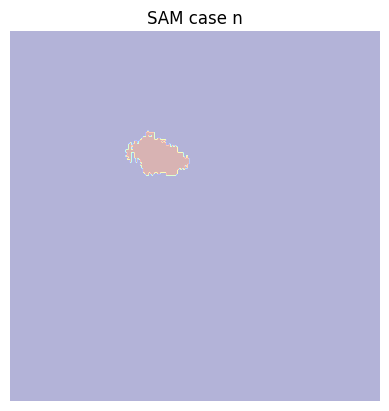

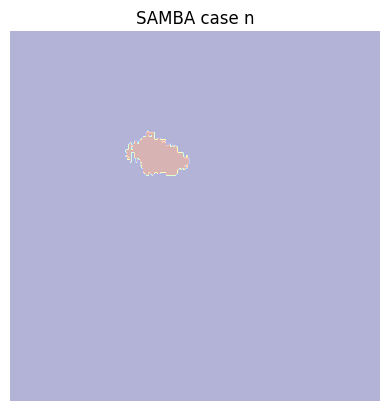

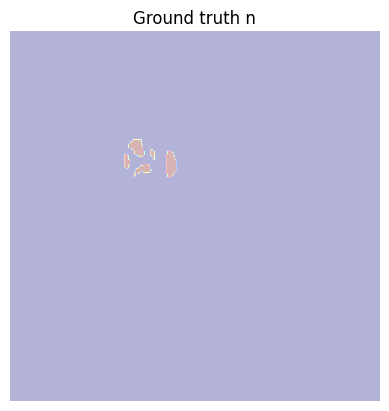

  1%|▏         | 1/78 [00:01<01:30,  1.18s/it]

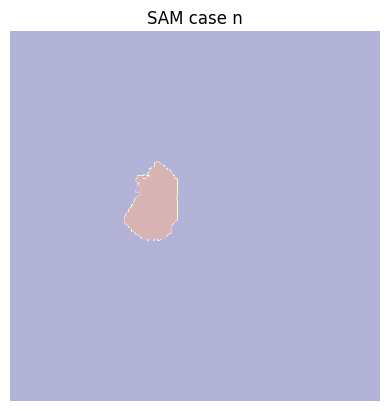

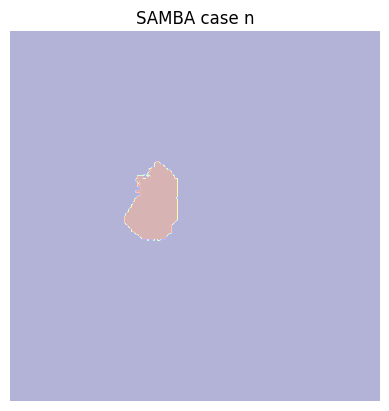

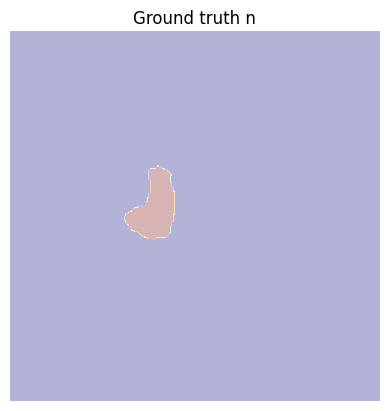

  3%|▎         | 2/78 [00:02<01:18,  1.03s/it]

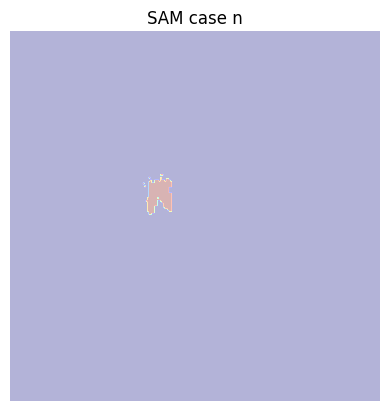

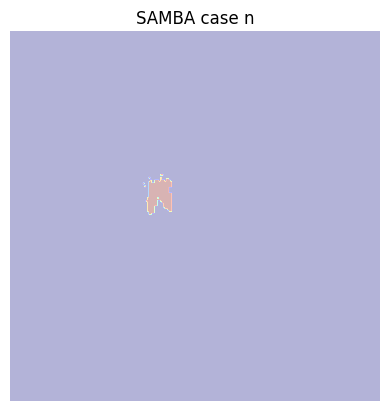

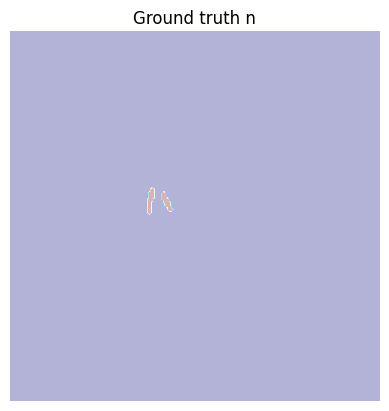

  4%|▍         | 3/78 [00:02<01:07,  1.10it/s]

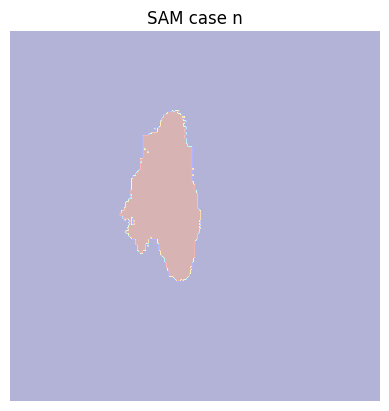

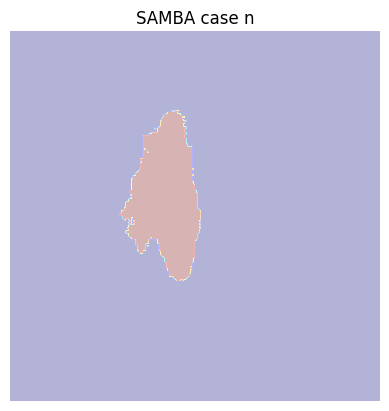

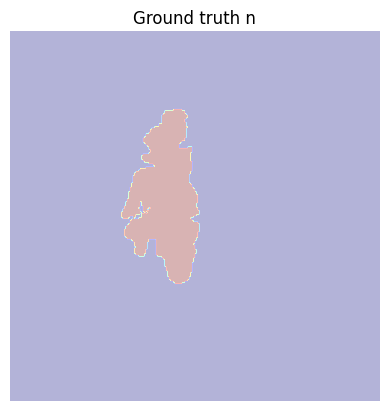

  5%|▌         | 4/78 [00:03<01:09,  1.07it/s]

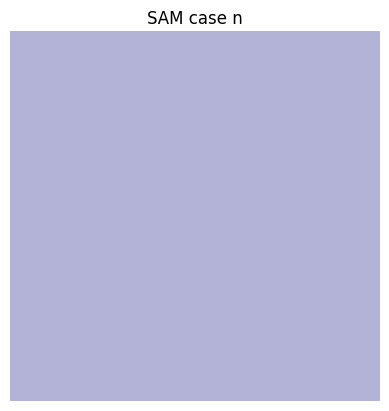

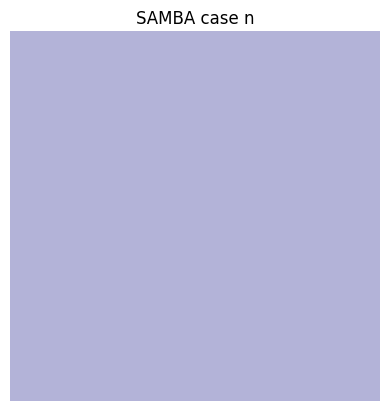

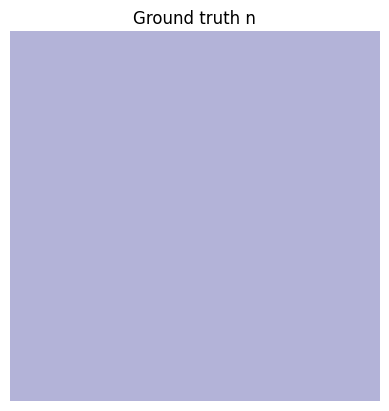

  6%|▋         | 5/78 [00:06<01:43,  1.42s/it]

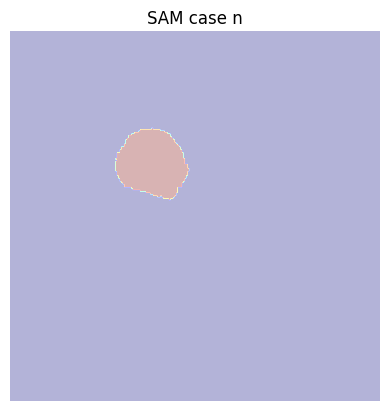

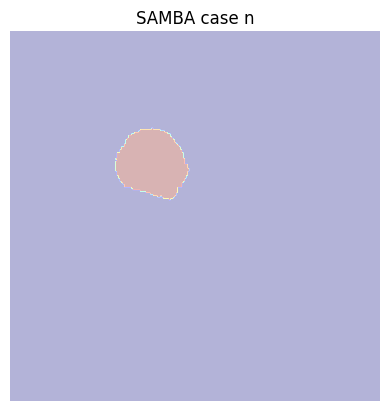

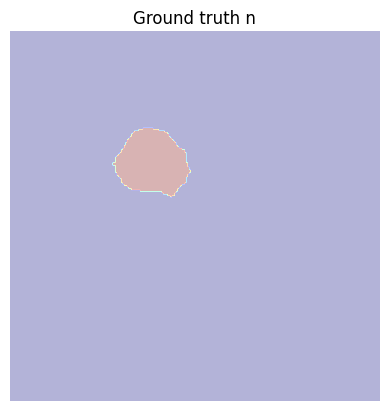

  8%|▊         | 6/78 [00:07<01:40,  1.39s/it]

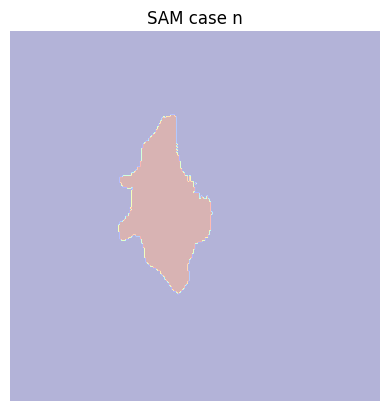

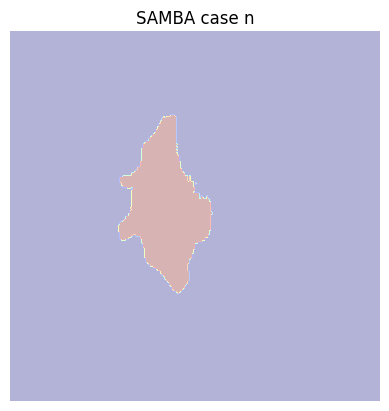

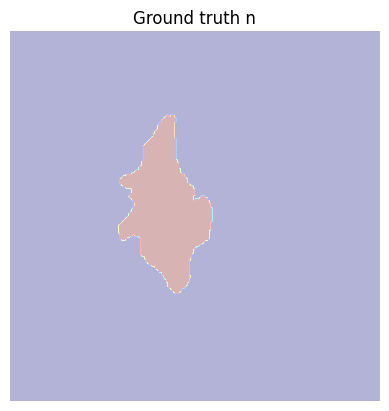

  9%|▉         | 7/78 [00:08<01:34,  1.33s/it]

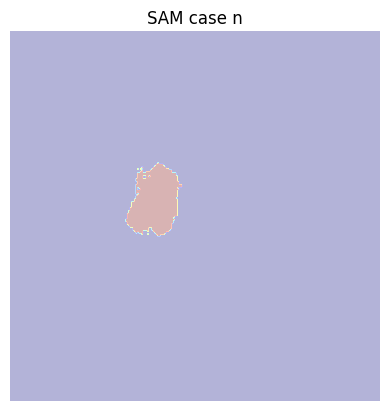

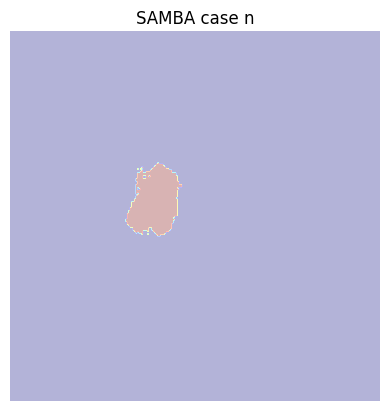

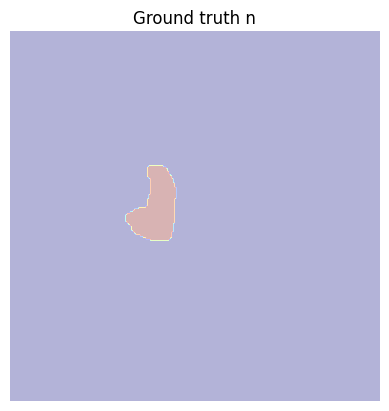

 10%|█         | 8/78 [00:09<01:26,  1.23s/it]

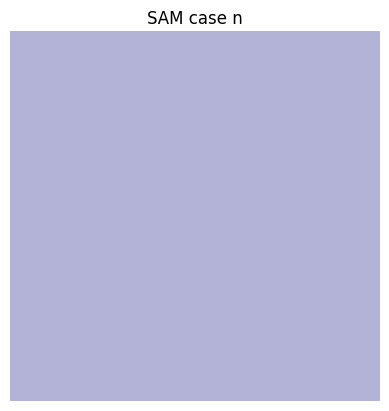

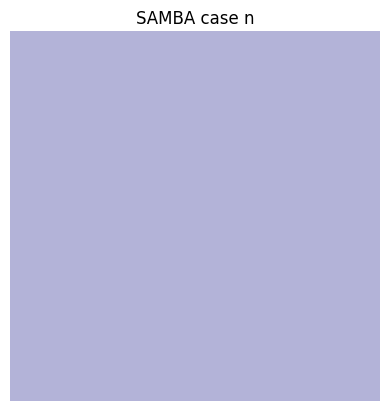

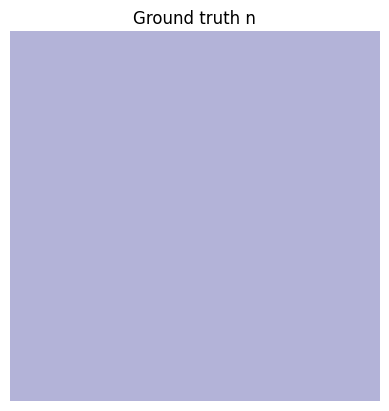

 12%|█▏        | 9/78 [00:10<01:18,  1.14s/it]

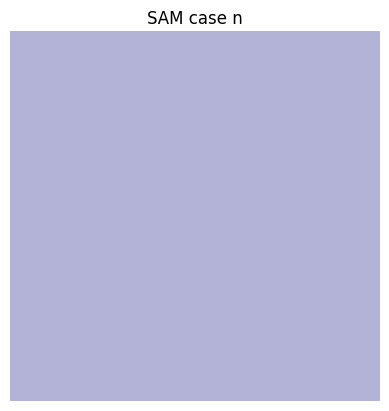

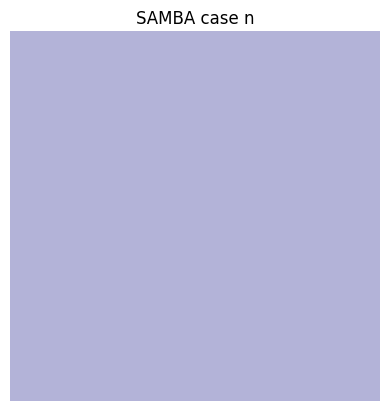

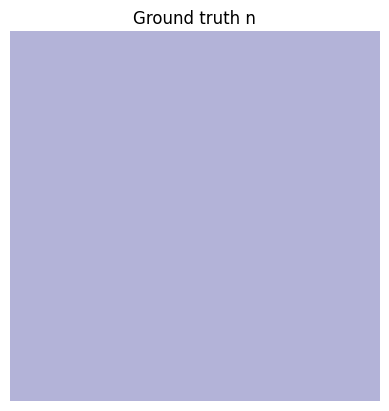

 13%|█▎        | 10/78 [00:11<01:11,  1.06s/it]

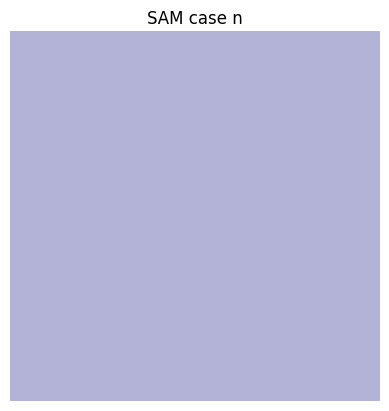

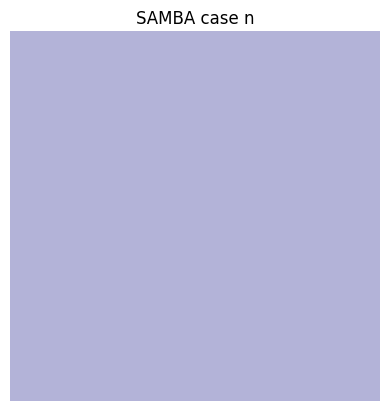

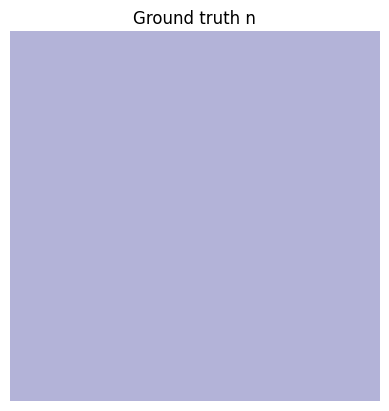

 14%|█▍        | 11/78 [00:12<01:06,  1.01it/s]

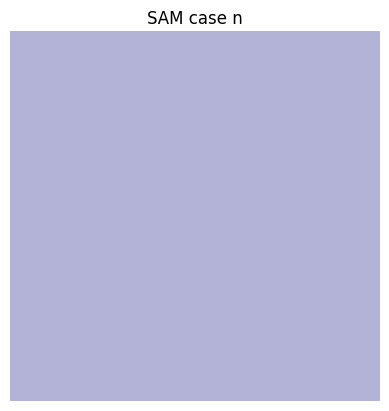

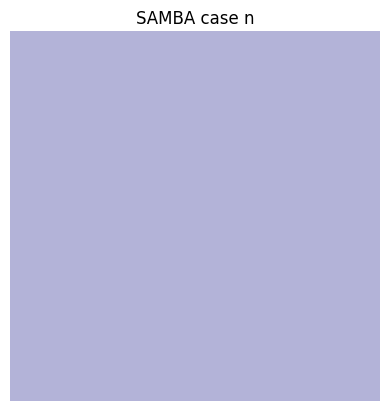

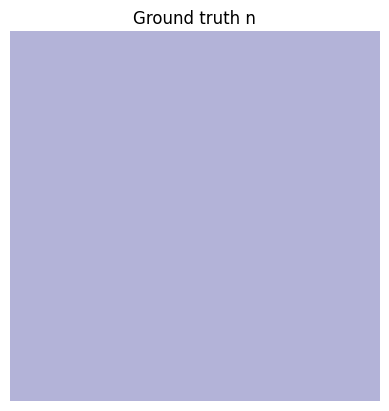

 15%|█▌        | 12/78 [00:13<01:01,  1.07it/s]

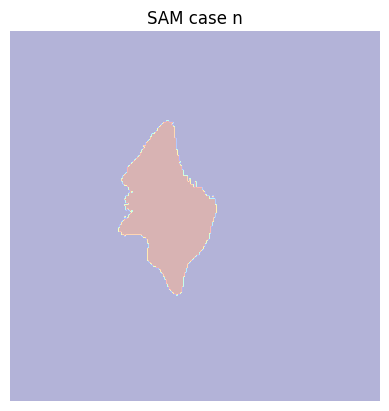

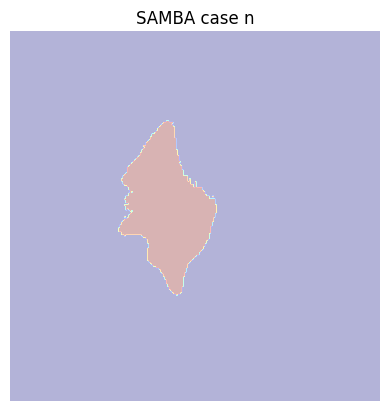

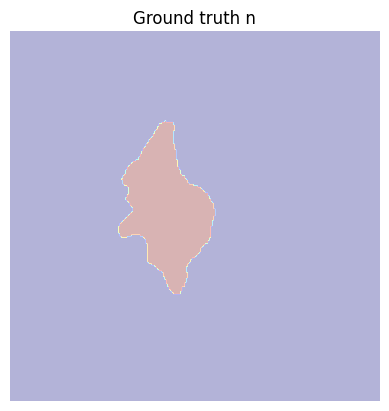

 17%|█▋        | 13/78 [00:13<00:58,  1.11it/s]

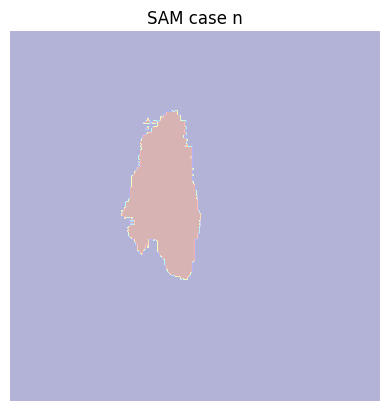

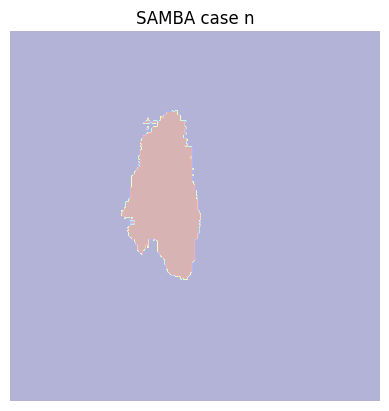

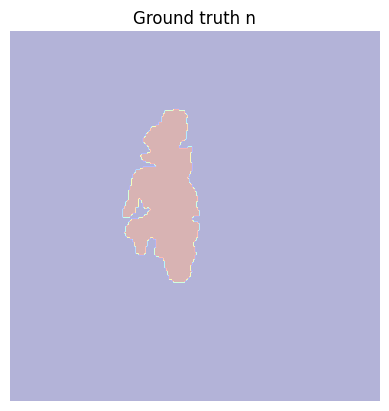

 18%|█▊        | 14/78 [00:14<00:57,  1.12it/s]

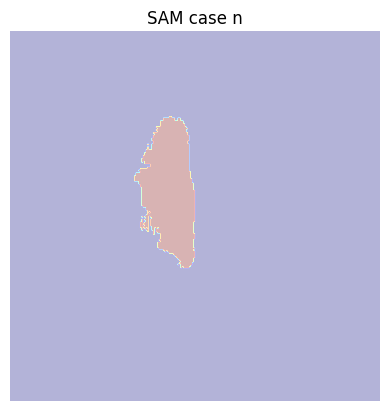

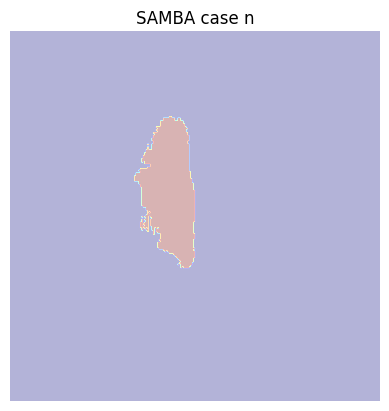

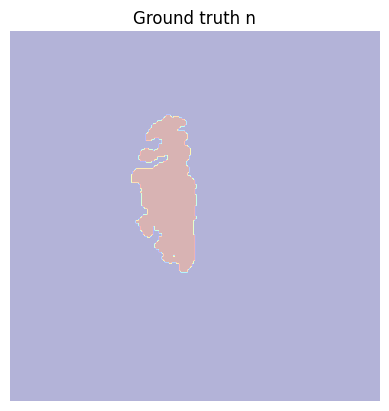

 19%|█▉        | 15/78 [00:15<00:54,  1.15it/s]

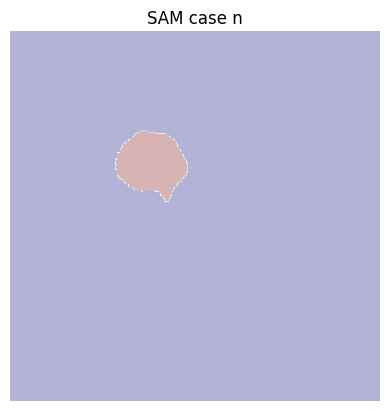

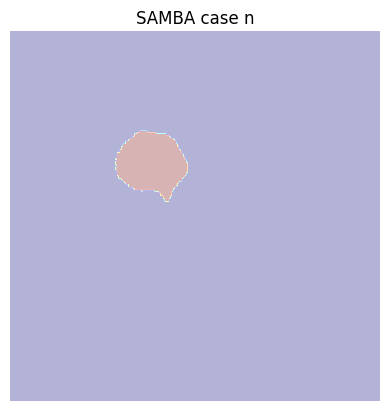

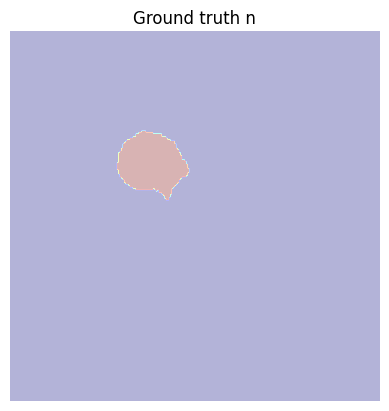

 21%|██        | 16/78 [00:16<00:52,  1.19it/s]

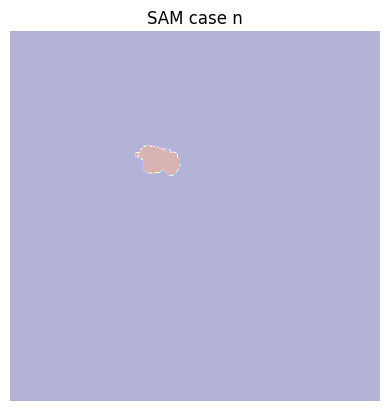

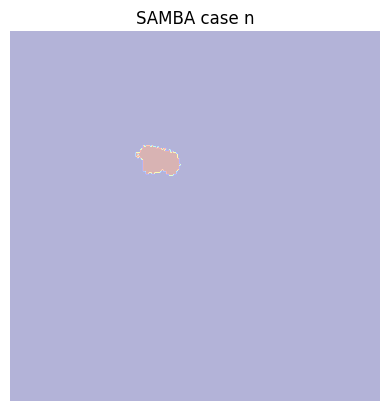

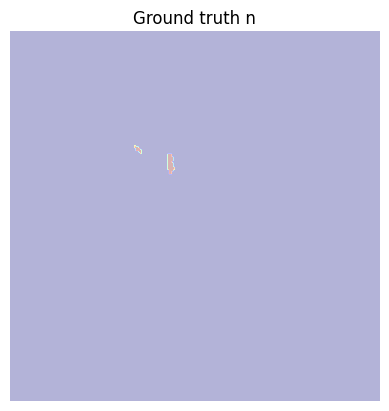

 22%|██▏       | 17/78 [00:17<00:53,  1.14it/s]

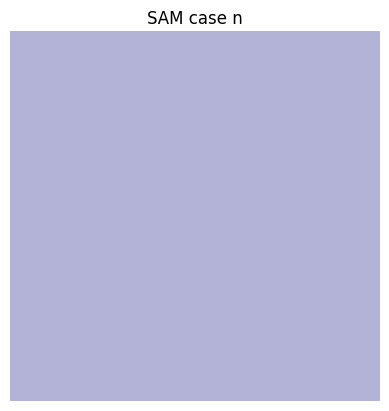

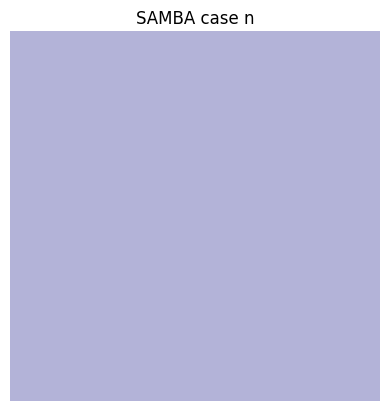

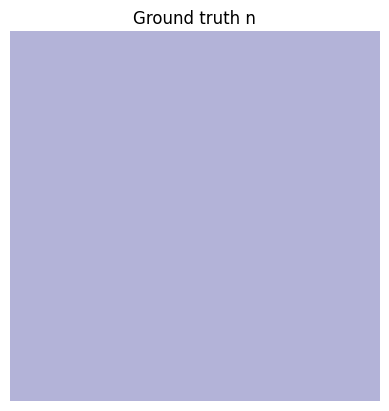

 23%|██▎       | 18/78 [00:18<00:55,  1.07it/s]

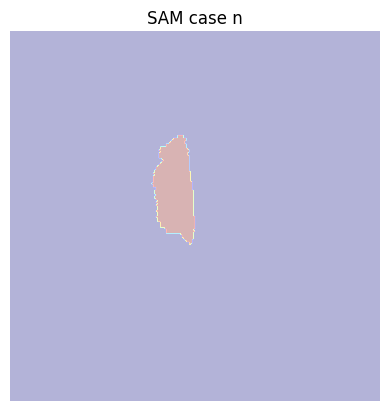

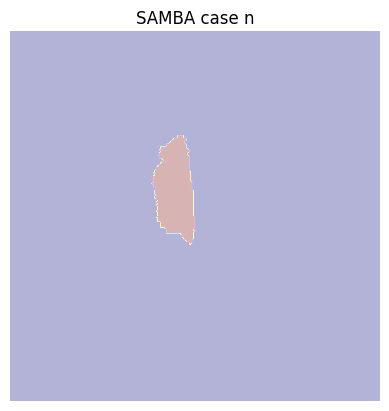

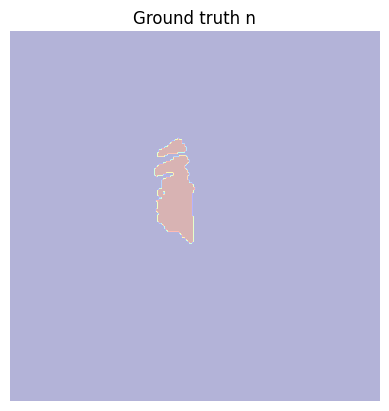

 24%|██▍       | 19/78 [00:19<01:01,  1.04s/it]

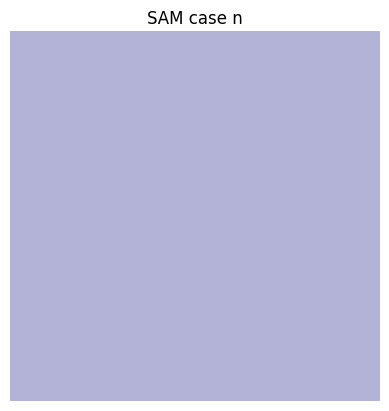

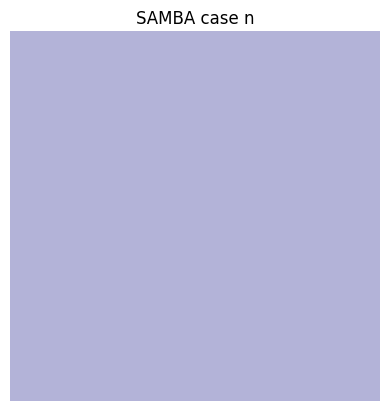

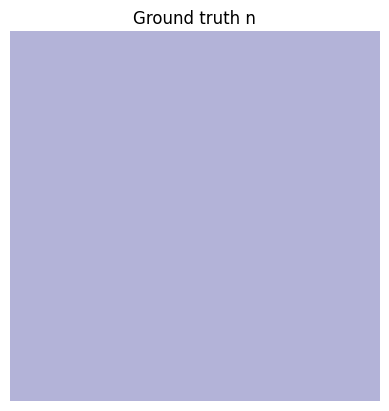

 26%|██▌       | 20/78 [00:21<01:07,  1.16s/it]

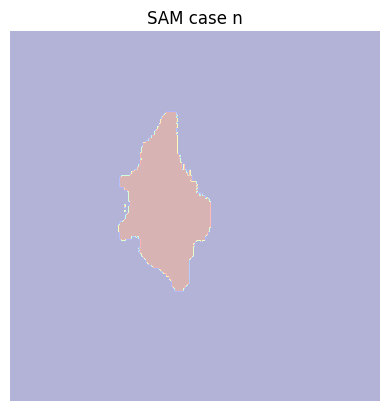

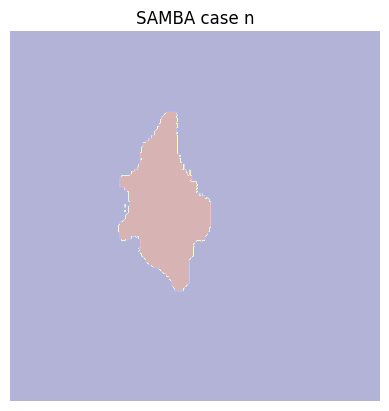

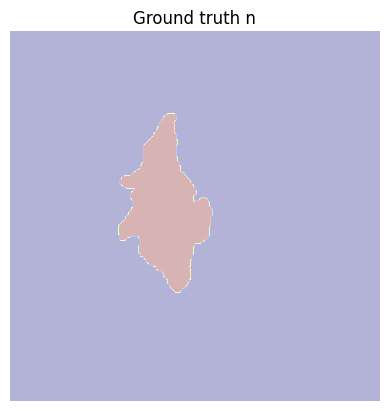

 27%|██▋       | 21/78 [00:22<01:10,  1.24s/it]

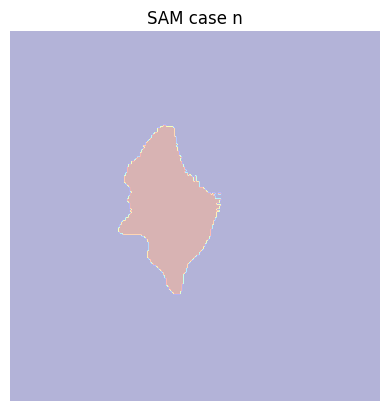

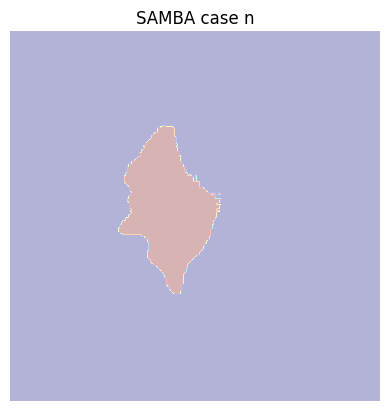

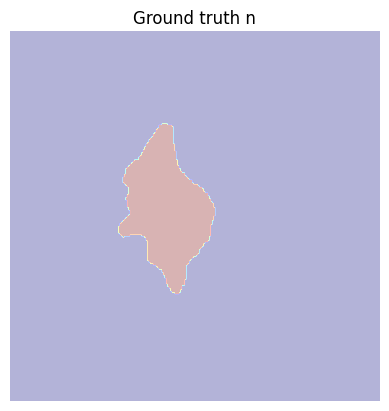

 28%|██▊       | 22/78 [00:23<01:03,  1.13s/it]

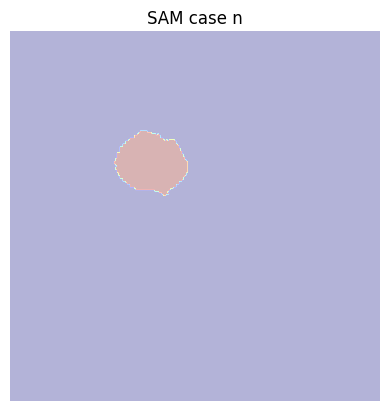

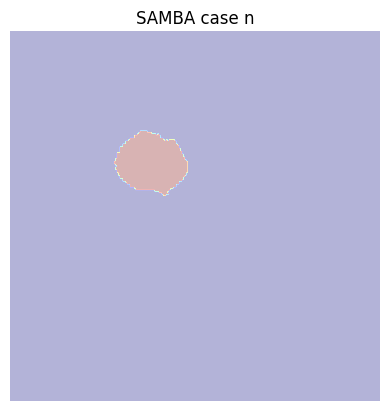

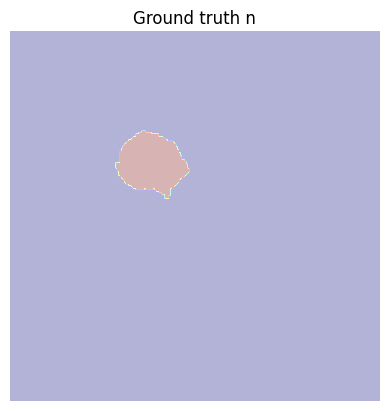

 29%|██▉       | 23/78 [00:24<00:56,  1.03s/it]

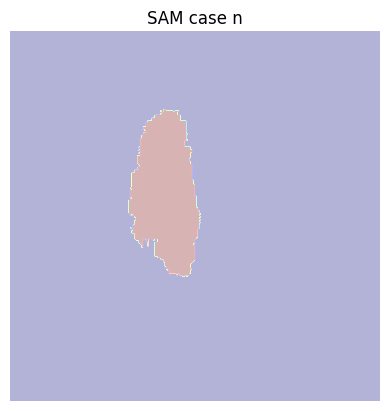

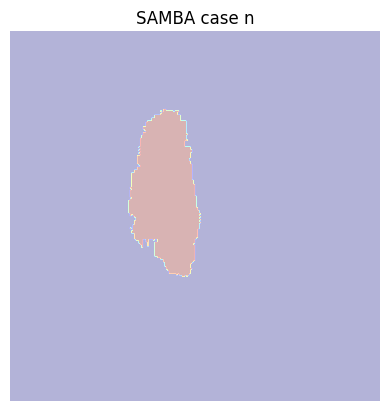

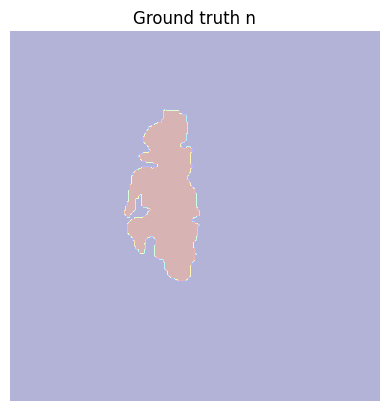

 31%|███       | 24/78 [00:25<00:51,  1.05it/s]

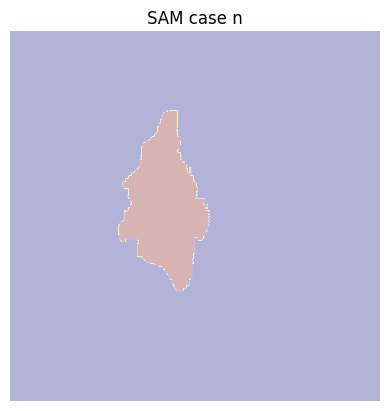

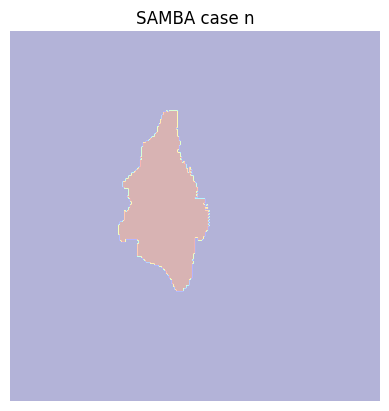

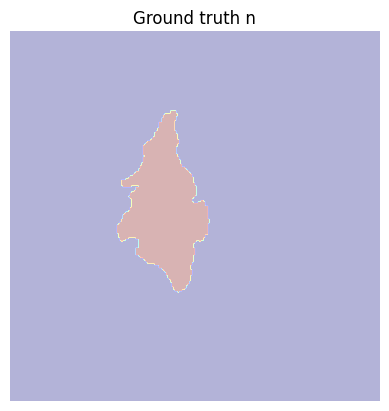

 32%|███▏      | 25/78 [00:25<00:48,  1.10it/s]

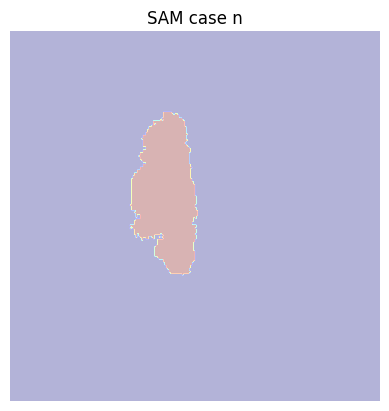

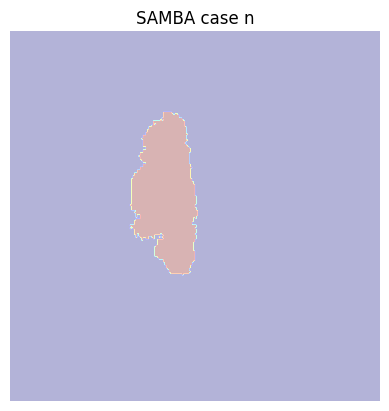

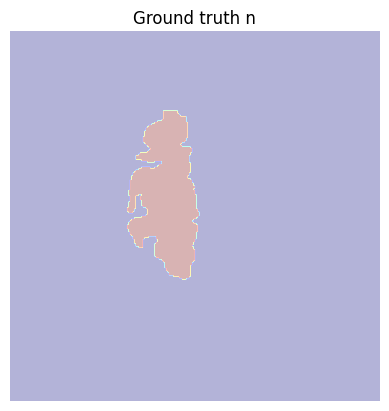

 33%|███▎      | 26/78 [00:26<00:45,  1.14it/s]

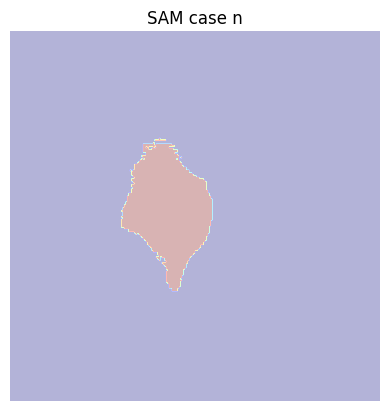

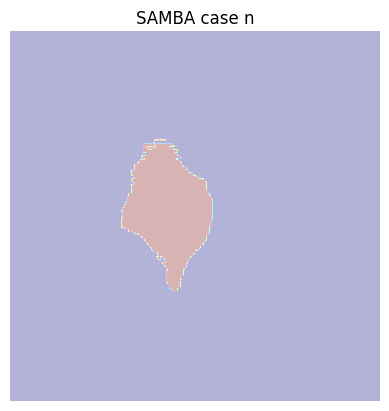

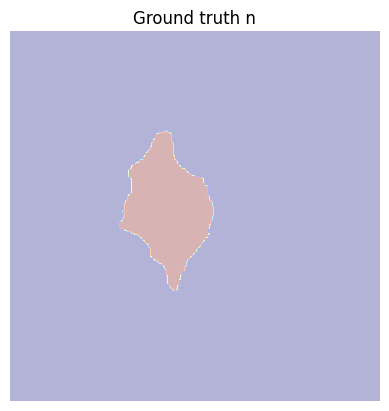

 35%|███▍      | 27/78 [00:27<00:43,  1.17it/s]

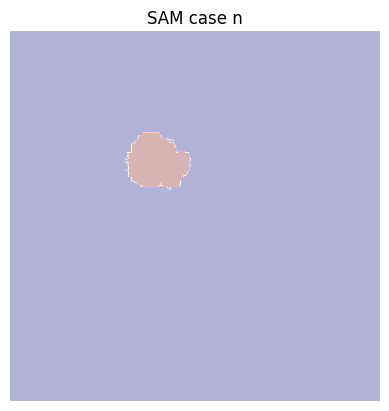

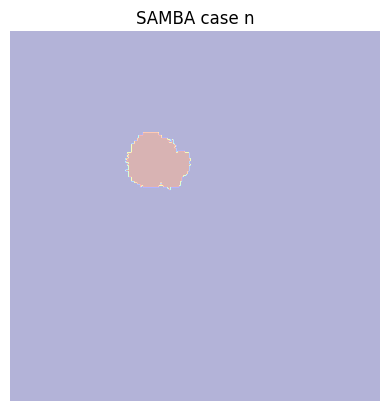

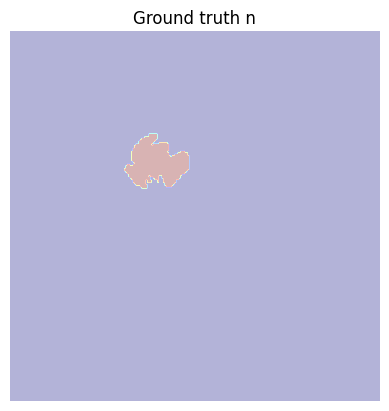

 36%|███▌      | 28/78 [00:28<00:43,  1.15it/s]

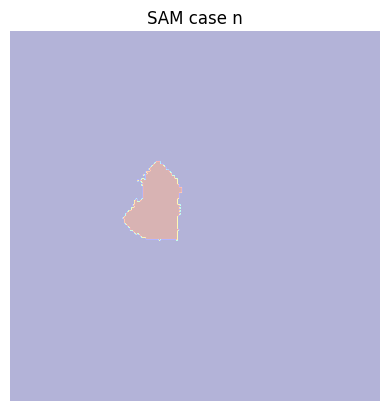

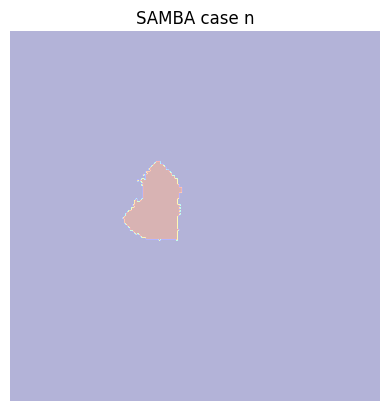

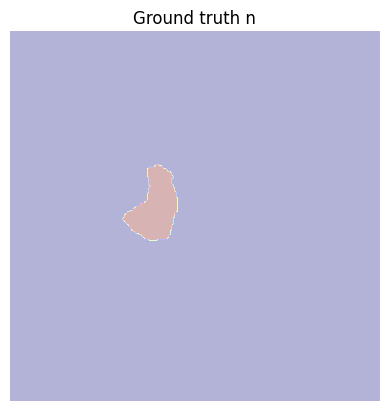

 37%|███▋      | 29/78 [00:29<00:42,  1.16it/s]

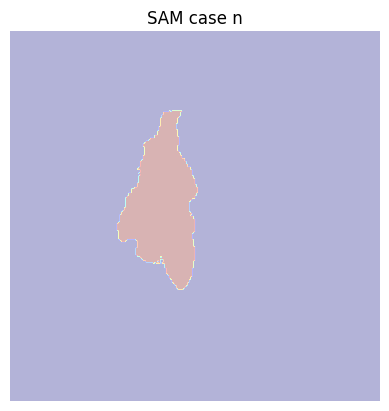

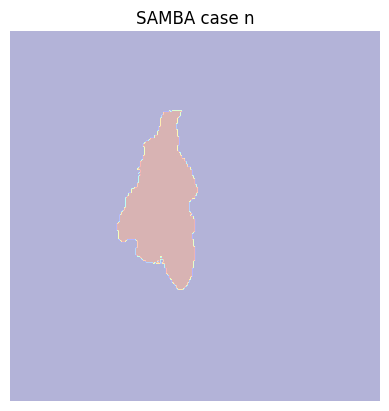

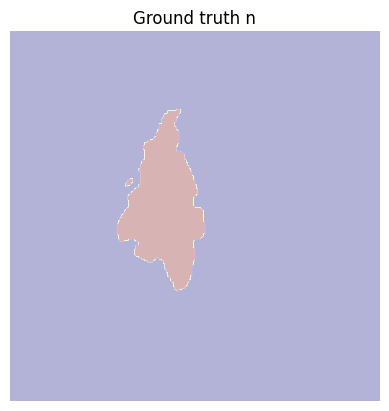

 38%|███▊      | 30/78 [00:30<00:41,  1.15it/s]

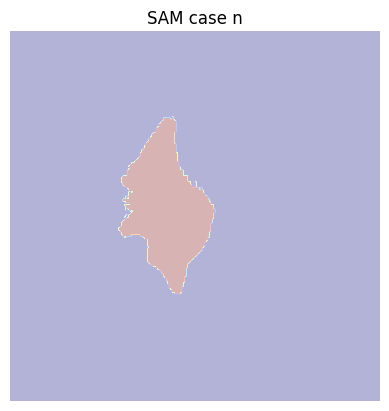

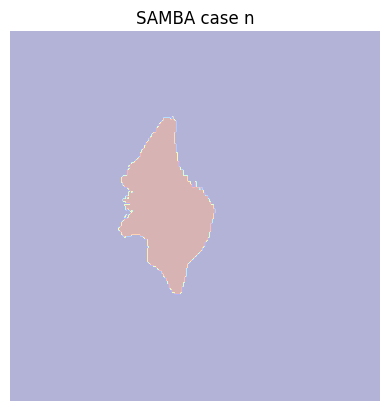

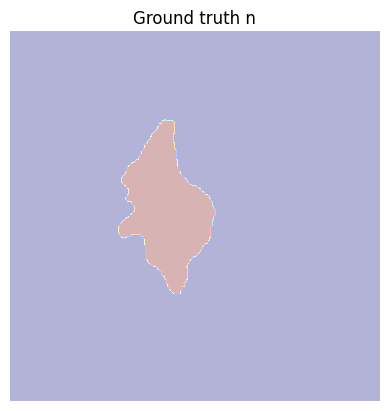

 40%|███▉      | 31/78 [00:31<00:42,  1.12it/s]

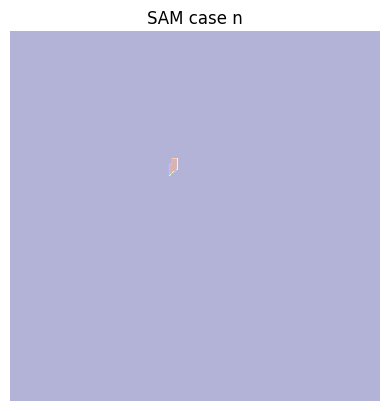

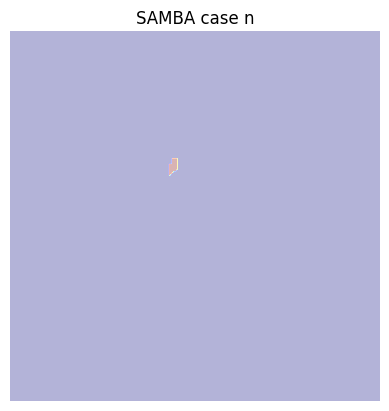

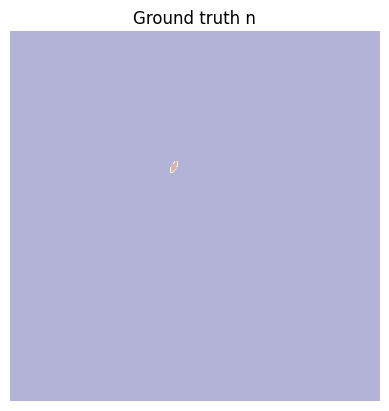

 41%|████      | 32/78 [00:31<00:41,  1.11it/s]

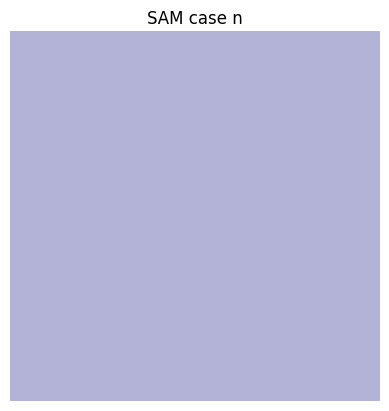

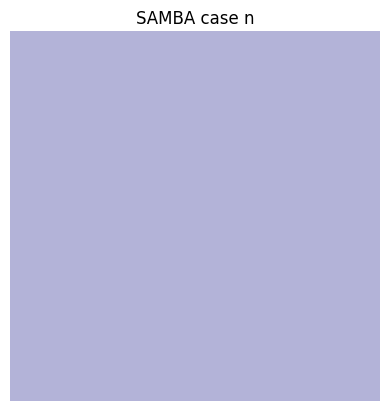

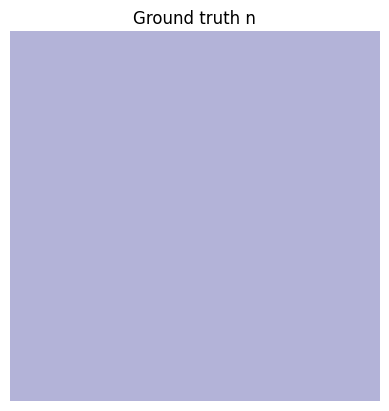

 42%|████▏     | 33/78 [00:32<00:41,  1.07it/s]

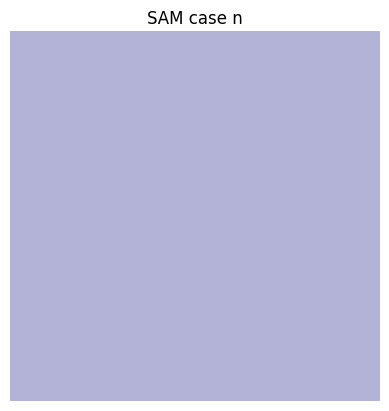

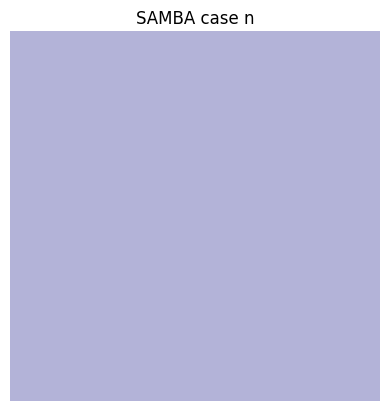

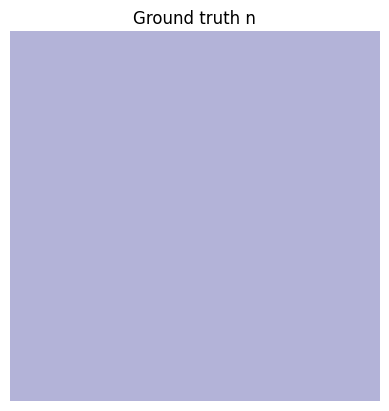

 44%|████▎     | 34/78 [00:34<00:44,  1.01s/it]

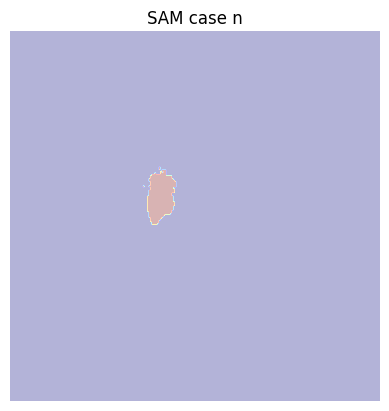

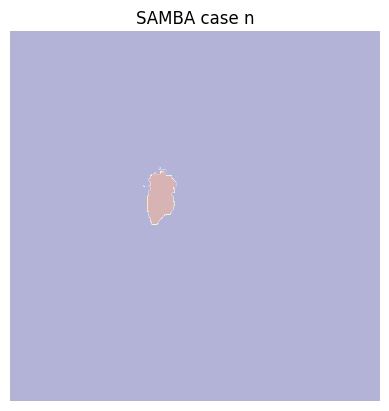

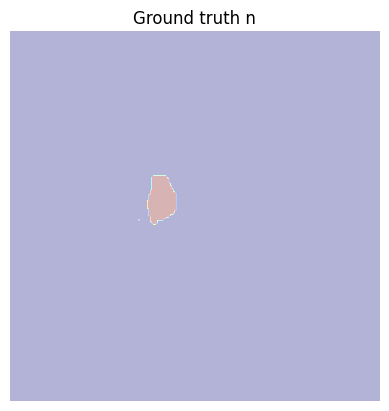

 45%|████▍     | 35/78 [00:35<00:47,  1.12s/it]

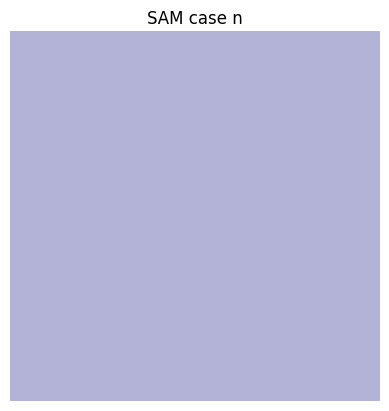

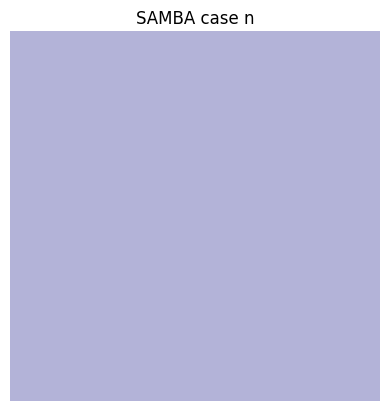

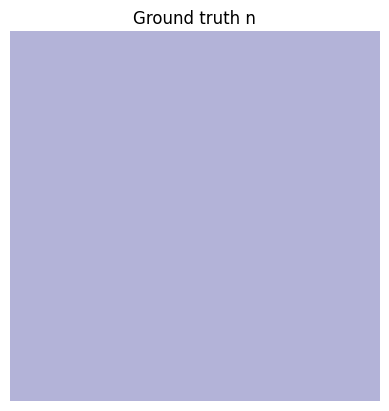

 46%|████▌     | 36/78 [00:36<00:51,  1.22s/it]

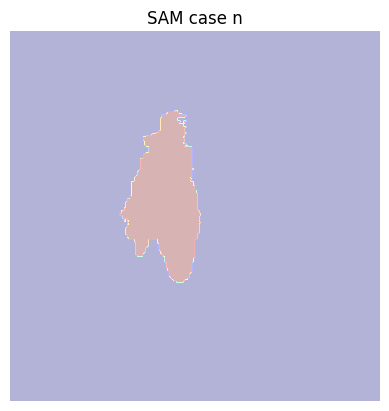

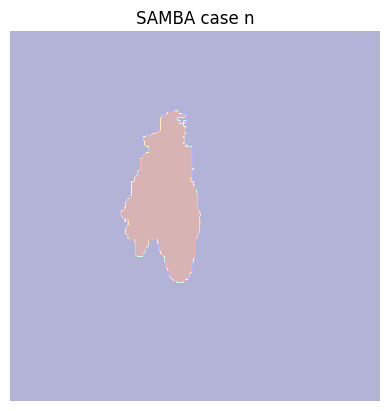

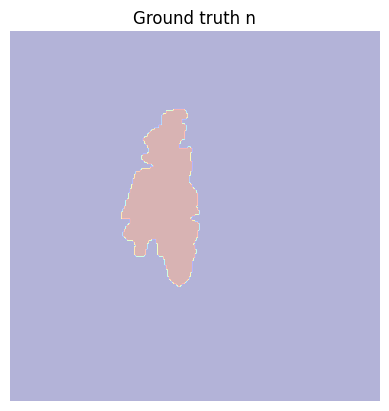

 47%|████▋     | 37/78 [00:38<00:49,  1.22s/it]

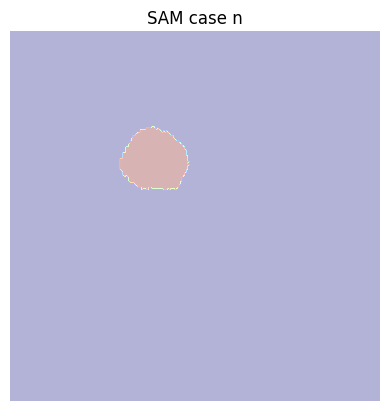

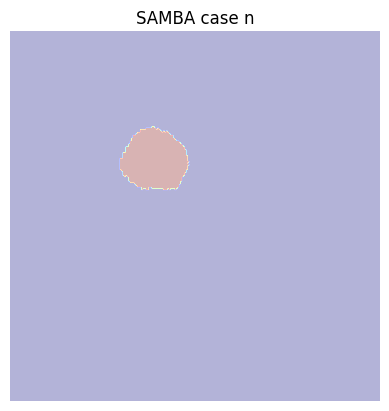

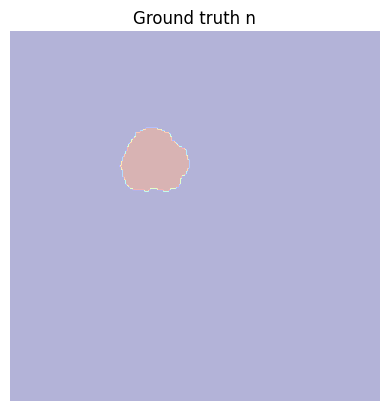

 49%|████▊     | 38/78 [00:39<00:44,  1.12s/it]

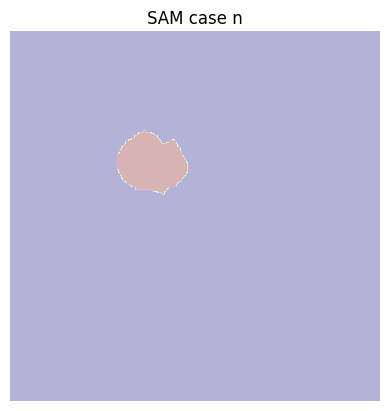

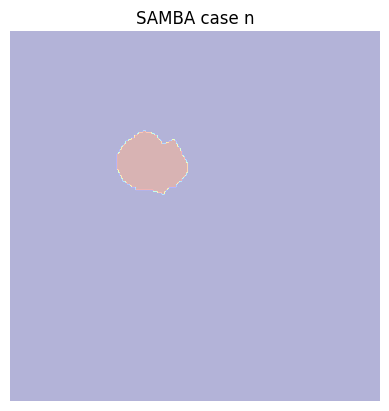

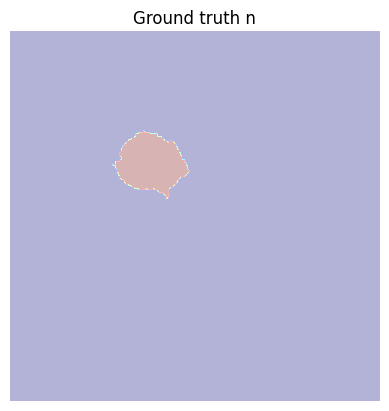

 50%|█████     | 39/78 [00:39<00:40,  1.03s/it]

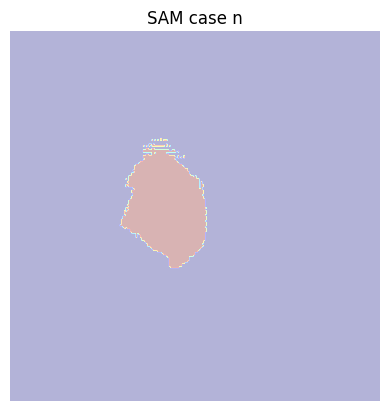

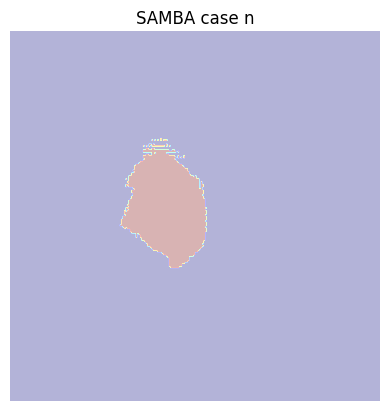

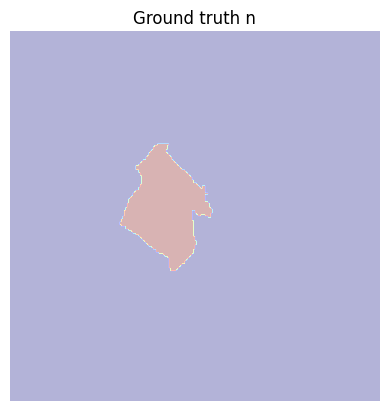

 51%|█████▏    | 40/78 [00:40<00:37,  1.01it/s]

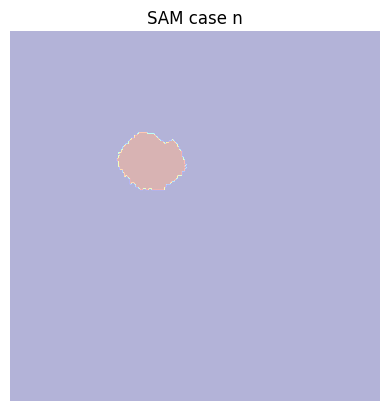

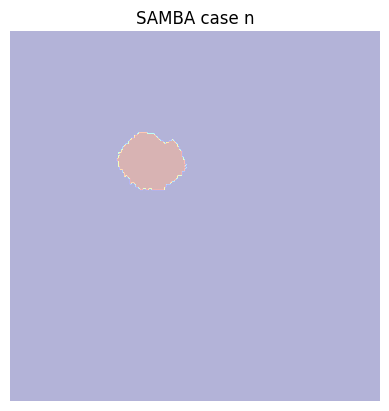

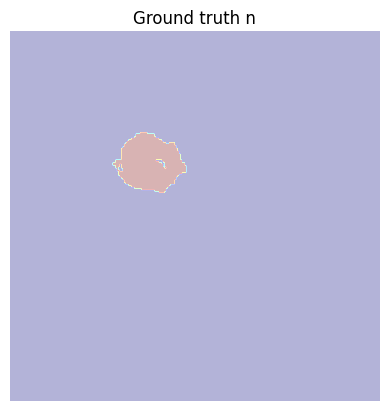

 53%|█████▎    | 41/78 [00:41<00:35,  1.03it/s]

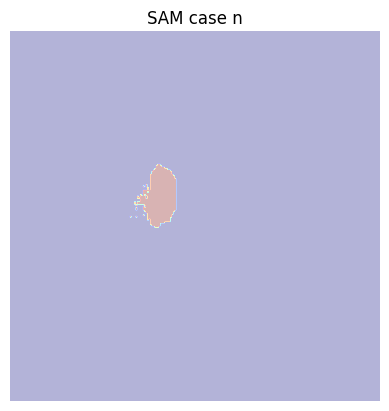

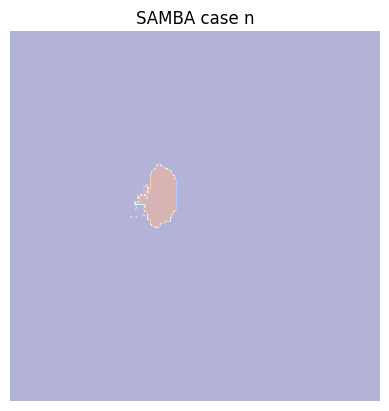

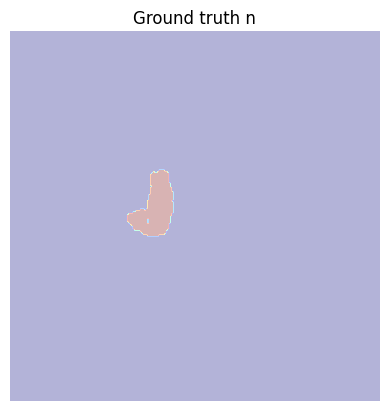

 54%|█████▍    | 42/78 [00:42<00:34,  1.06it/s]

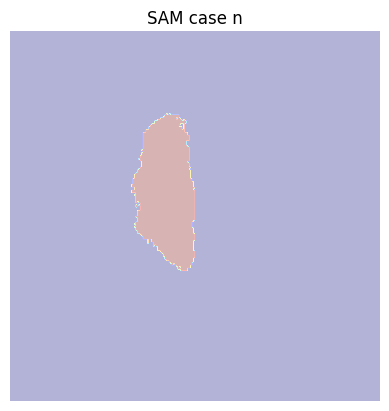

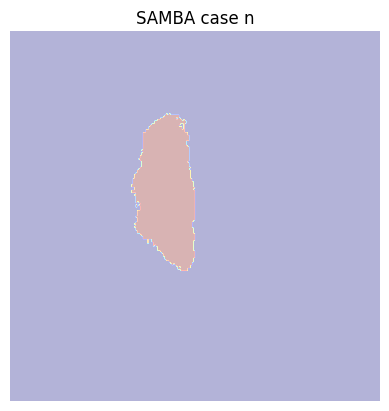

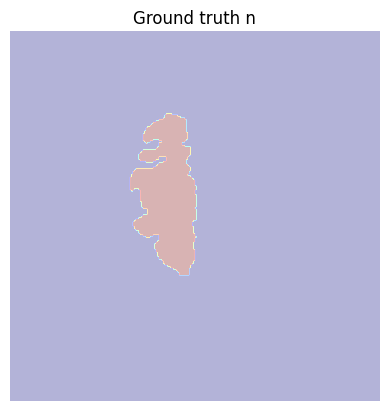

 55%|█████▌    | 43/78 [00:43<00:33,  1.05it/s]

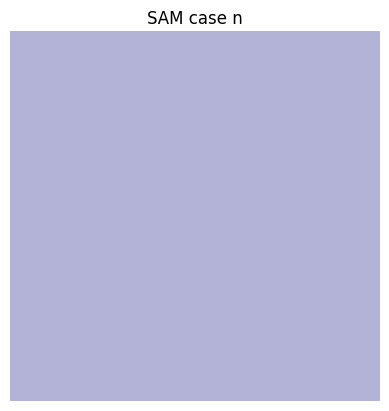

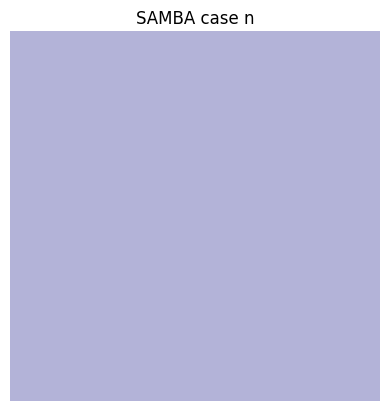

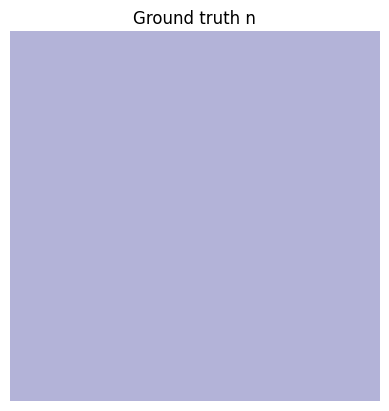

 56%|█████▋    | 44/78 [00:44<00:31,  1.10it/s]

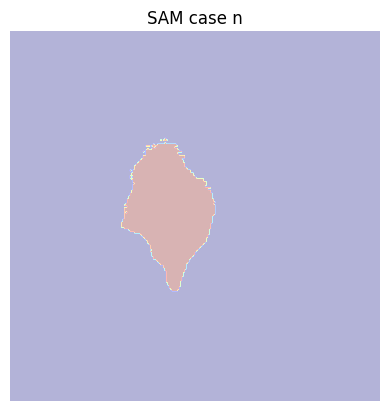

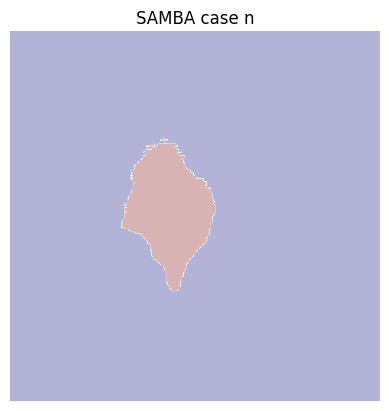

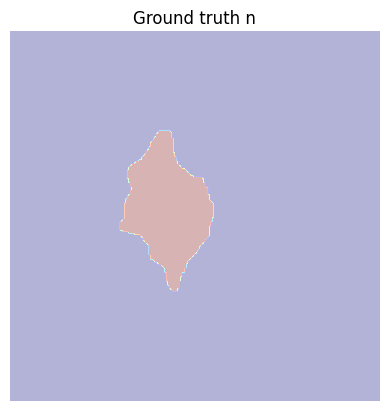

 58%|█████▊    | 45/78 [00:45<00:30,  1.08it/s]

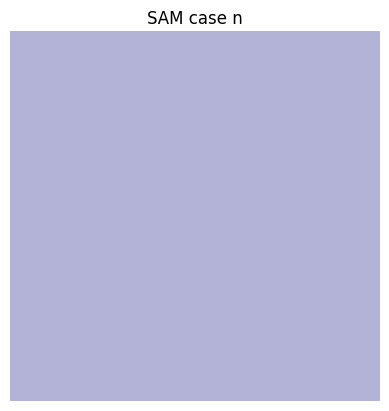

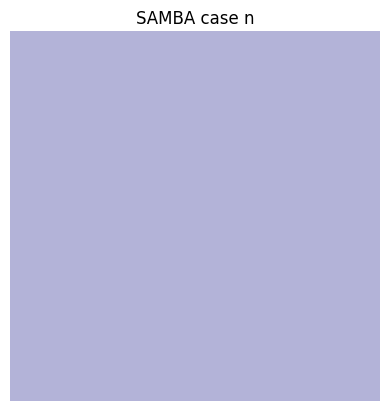

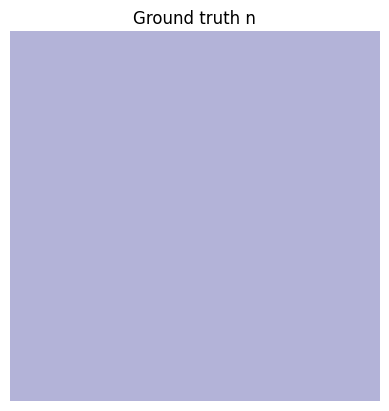

 59%|█████▉    | 46/78 [00:46<00:29,  1.08it/s]

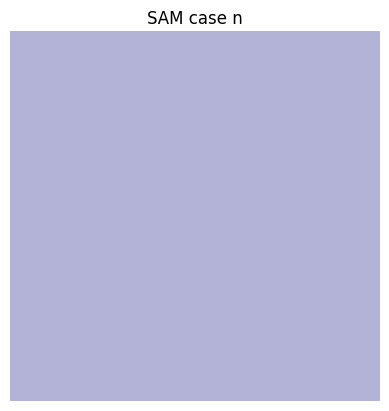

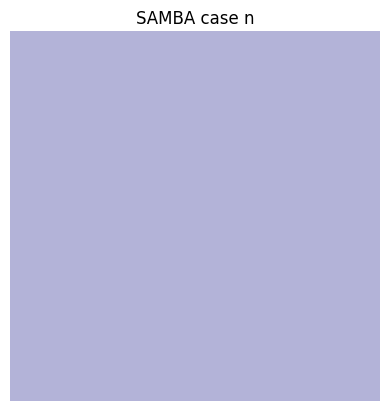

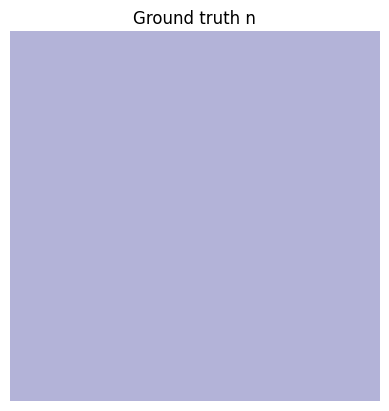

 60%|██████    | 47/78 [00:47<00:28,  1.10it/s]

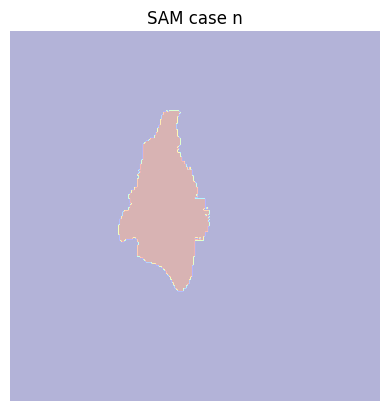

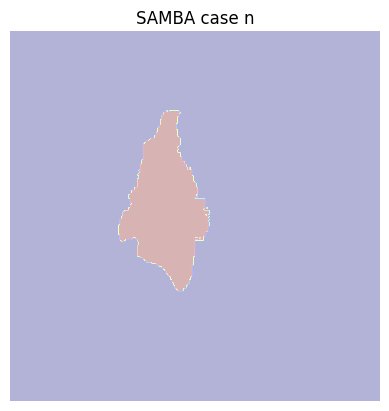

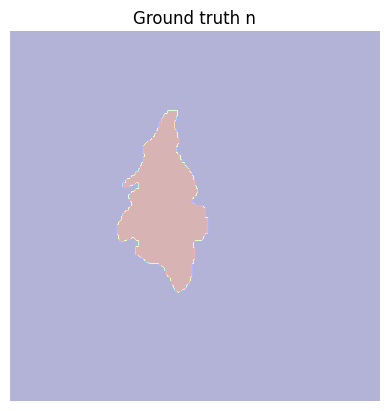

 62%|██████▏   | 48/78 [00:48<00:29,  1.02it/s]

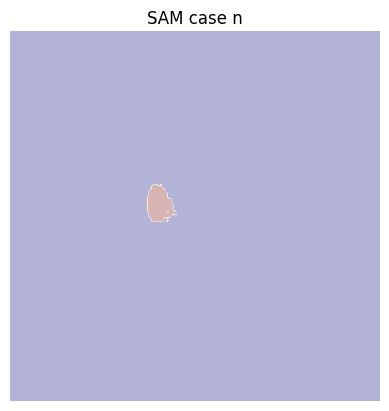

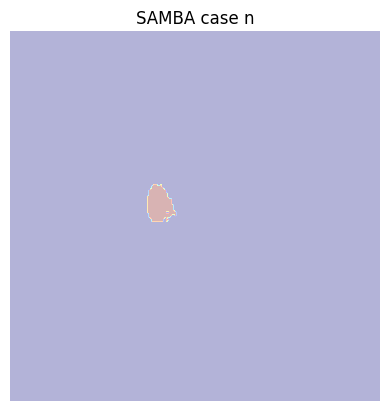

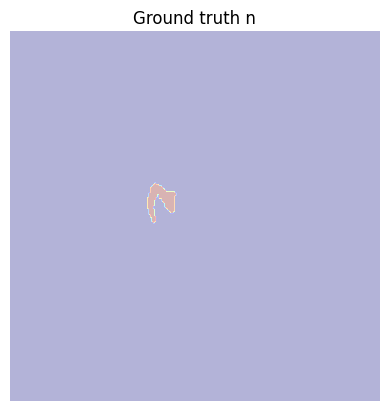

 63%|██████▎   | 49/78 [00:49<00:33,  1.17s/it]

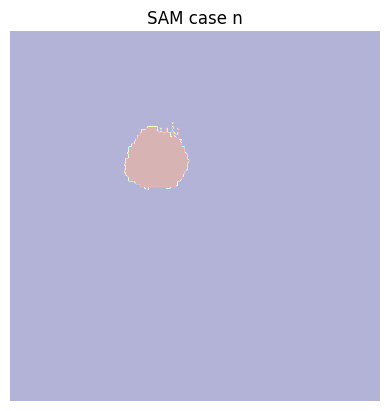

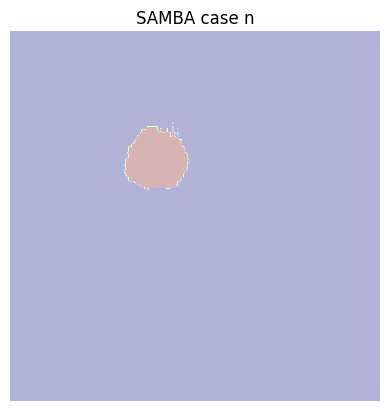

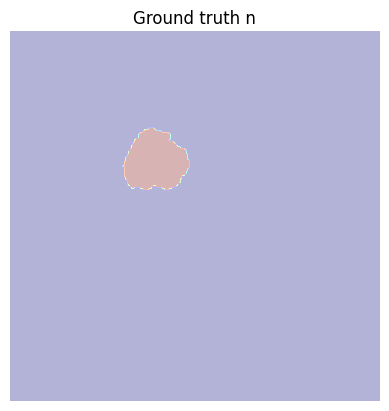

 64%|██████▍   | 50/78 [00:51<00:33,  1.21s/it]

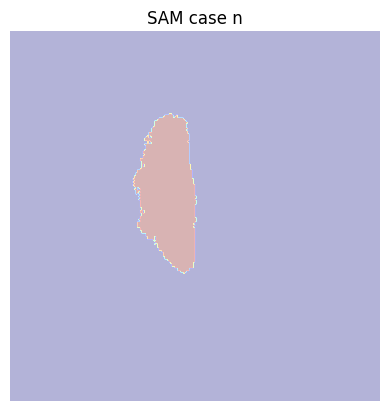

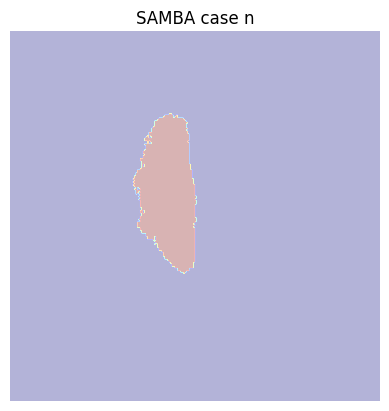

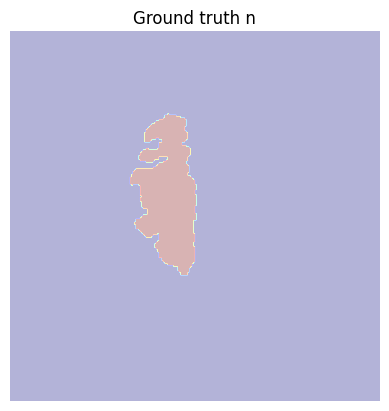

 65%|██████▌   | 51/78 [00:52<00:34,  1.27s/it]

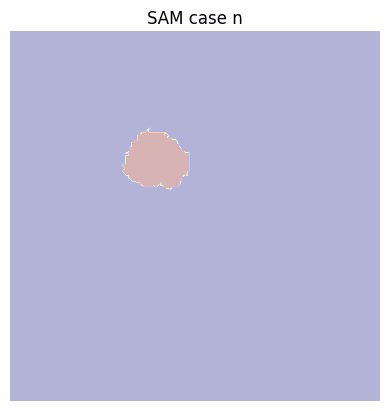

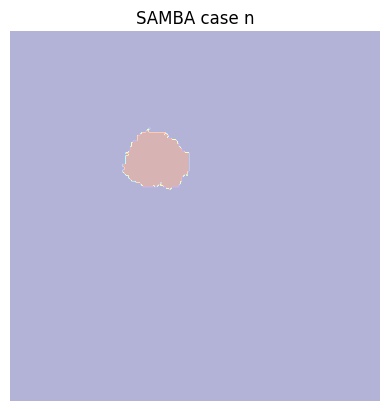

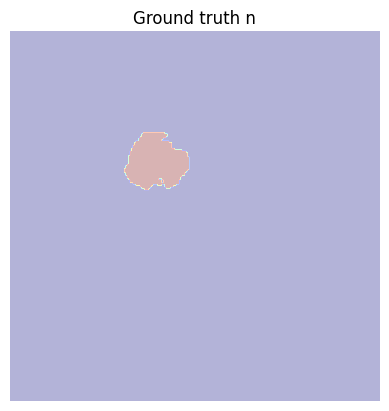

 67%|██████▋   | 52/78 [00:54<00:35,  1.35s/it]

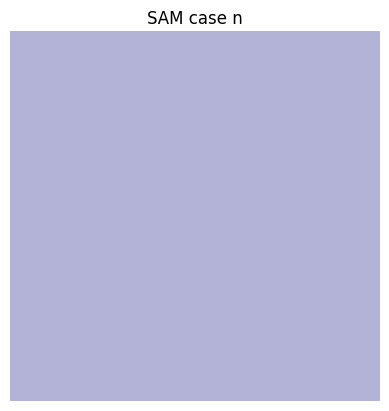

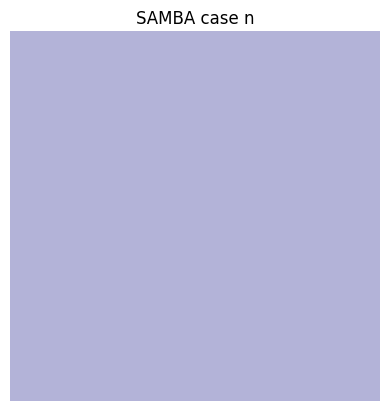

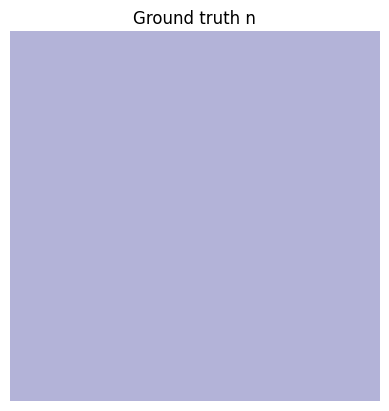

 68%|██████▊   | 53/78 [00:55<00:34,  1.37s/it]

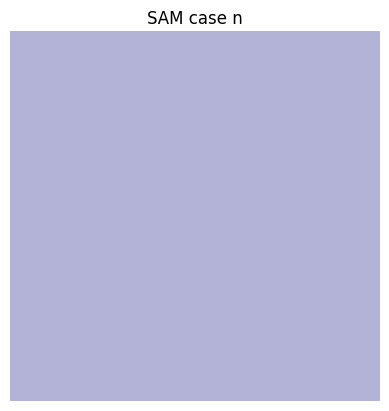

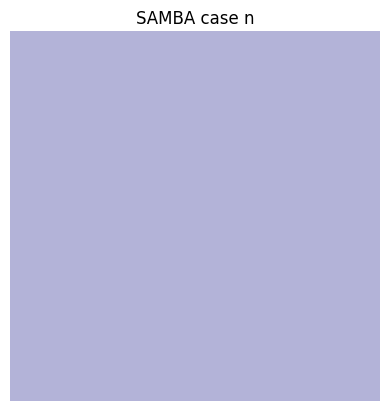

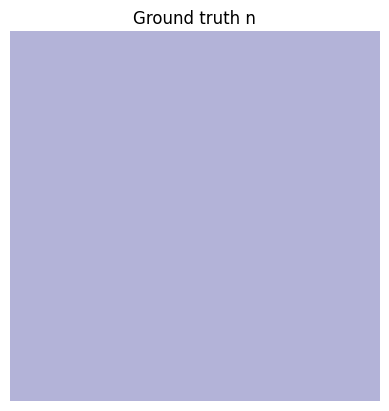

 69%|██████▉   | 54/78 [00:57<00:37,  1.56s/it]

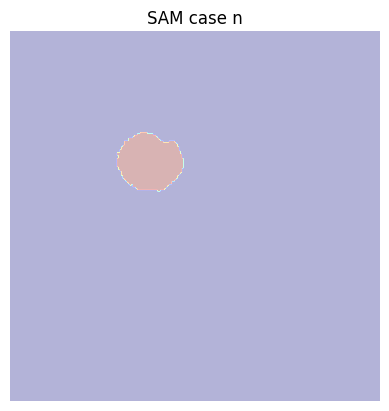

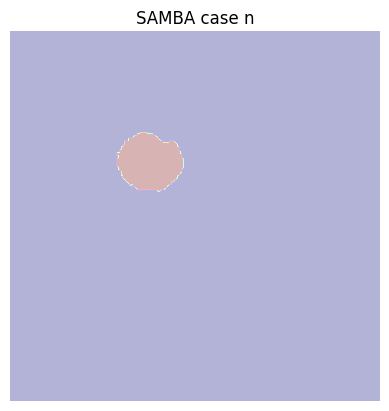

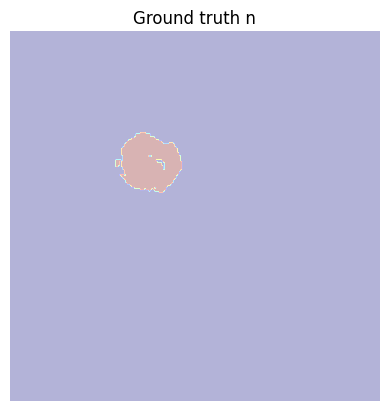

 71%|███████   | 55/78 [00:58<00:31,  1.36s/it]

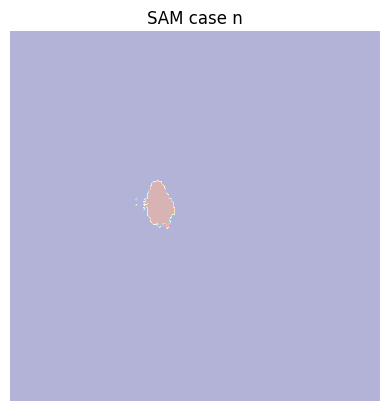

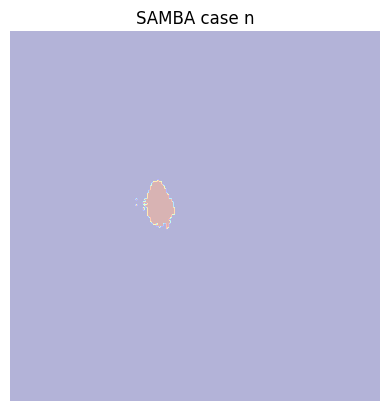

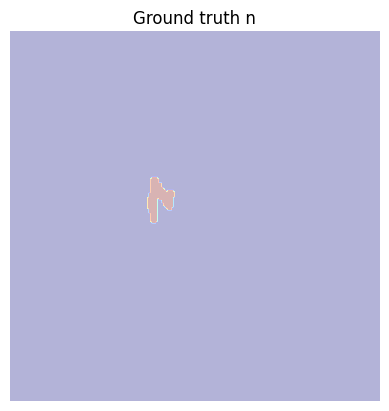

 72%|███████▏  | 56/78 [00:59<00:27,  1.25s/it]

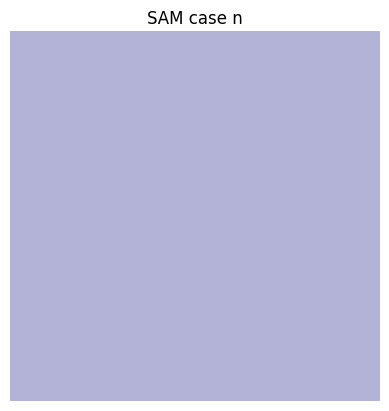

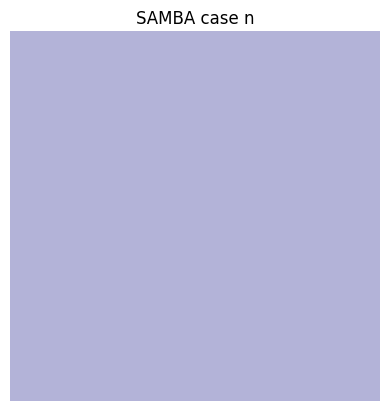

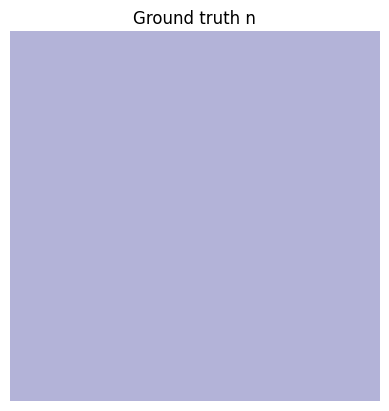

 73%|███████▎  | 57/78 [01:00<00:24,  1.14s/it]

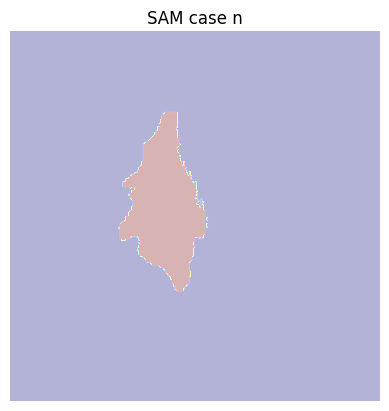

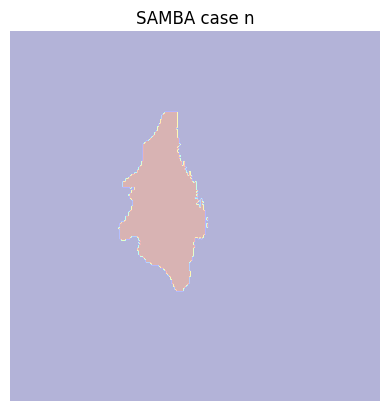

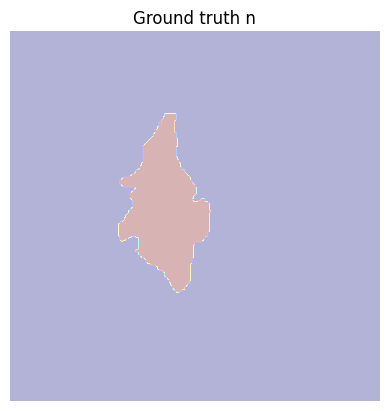

 74%|███████▍  | 58/78 [01:01<00:21,  1.07s/it]

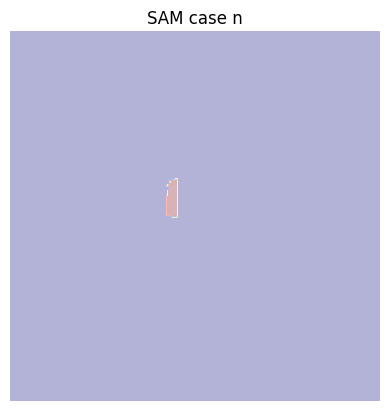

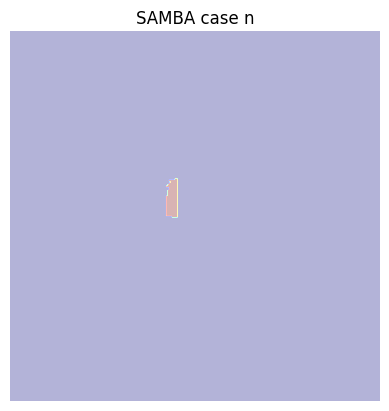

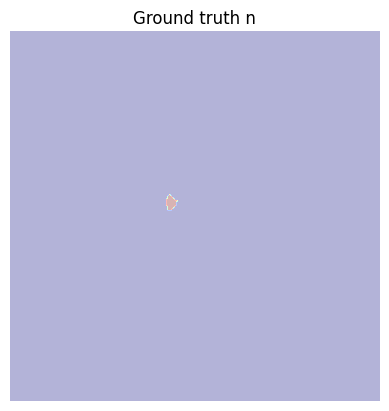

 76%|███████▌  | 59/78 [01:02<00:19,  1.00s/it]

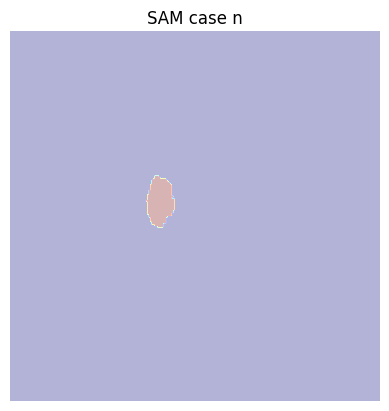

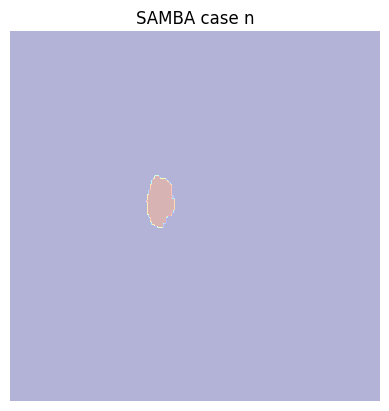

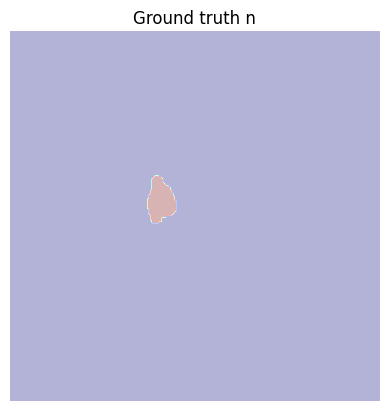

 77%|███████▋  | 60/78 [01:03<00:17,  1.03it/s]

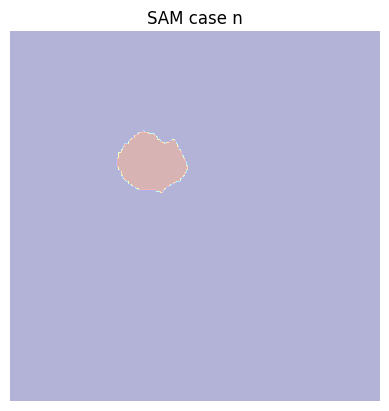

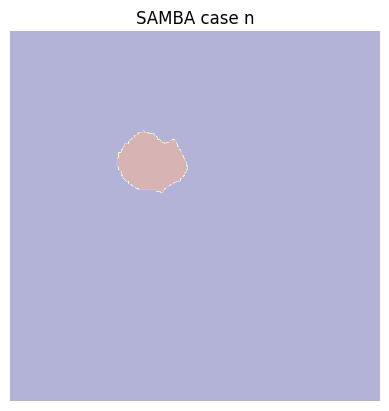

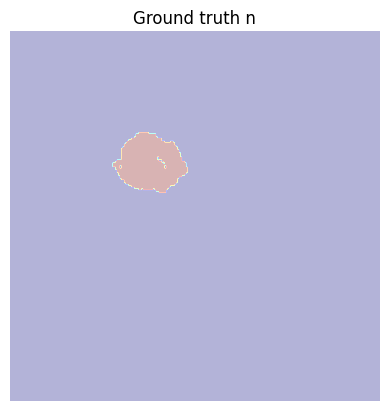

 78%|███████▊  | 61/78 [01:04<00:19,  1.17s/it]

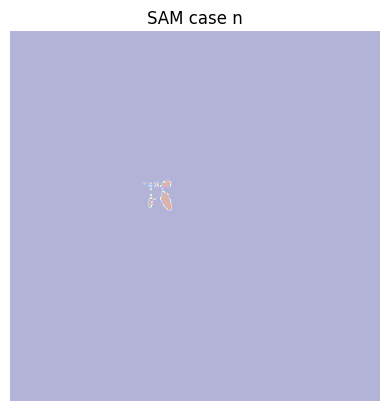

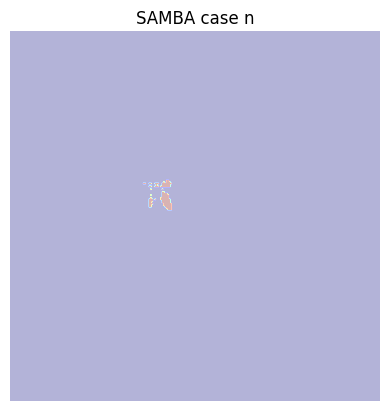

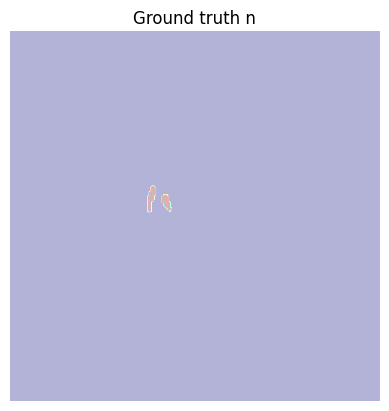

 79%|███████▉  | 62/78 [01:06<00:22,  1.42s/it]

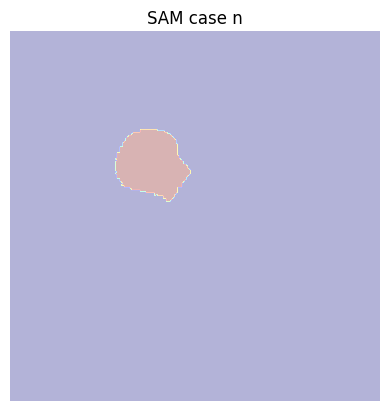

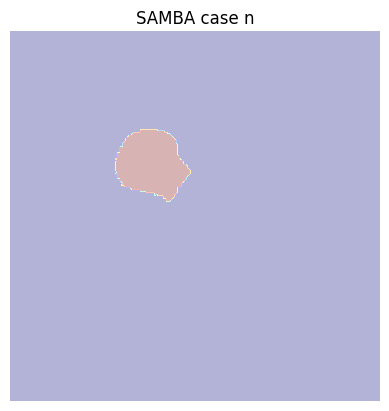

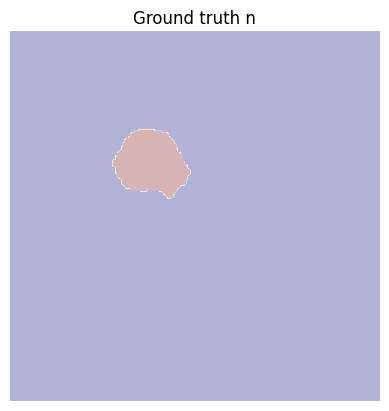

 81%|████████  | 63/78 [01:08<00:23,  1.56s/it]

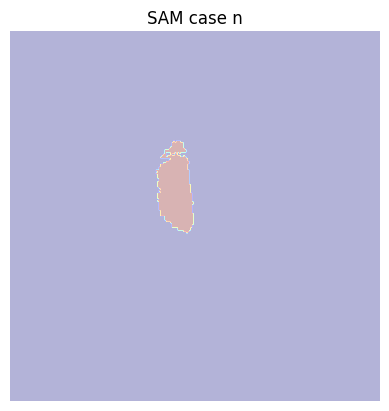

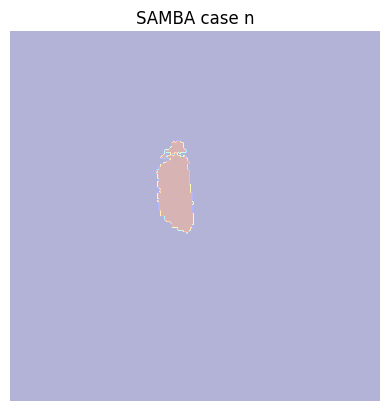

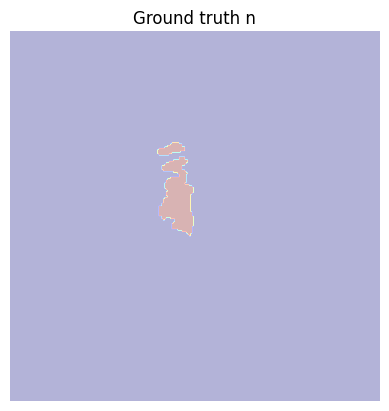

 82%|████████▏ | 64/78 [01:09<00:19,  1.39s/it]

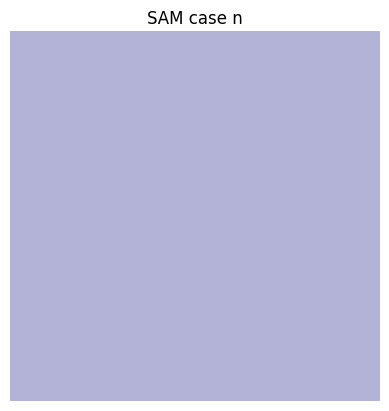

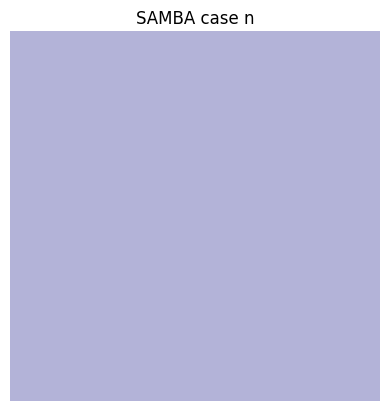

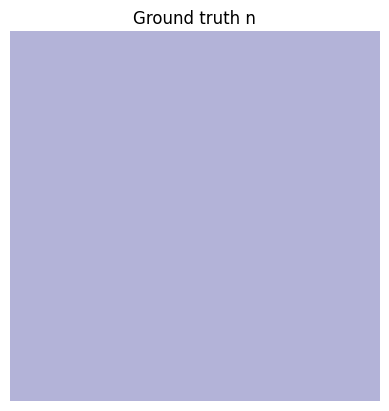

 83%|████████▎ | 65/78 [01:10<00:16,  1.26s/it]

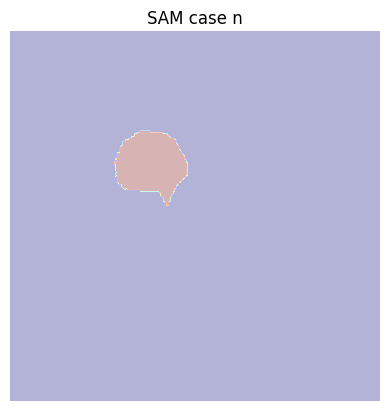

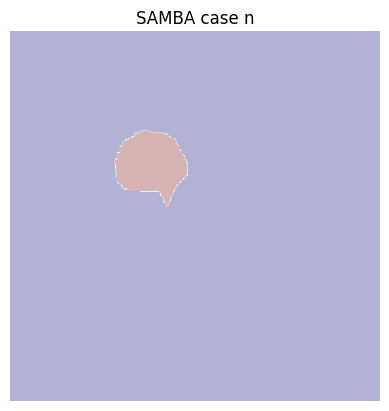

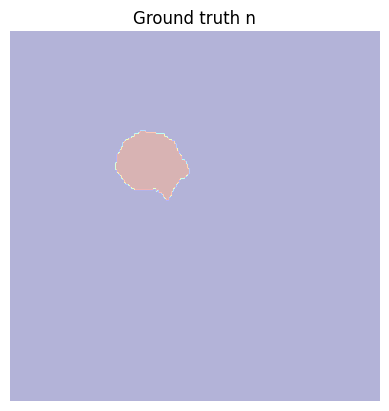

 85%|████████▍ | 66/78 [01:11<00:14,  1.17s/it]

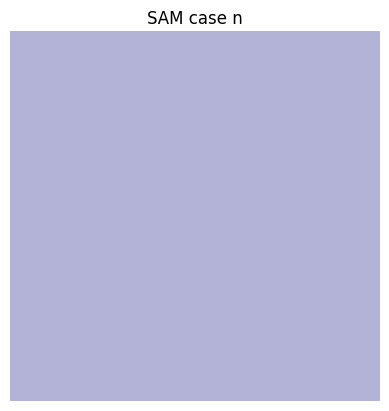

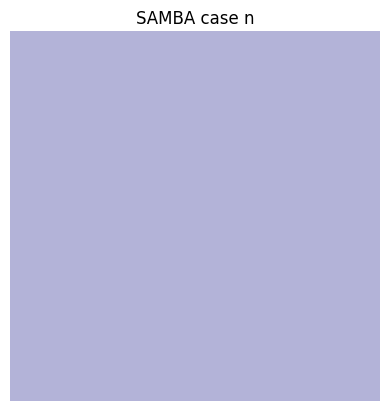

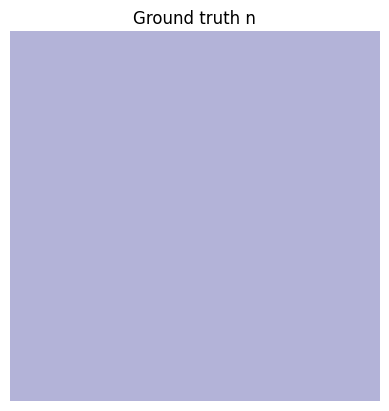

 86%|████████▌ | 67/78 [01:12<00:11,  1.02s/it]

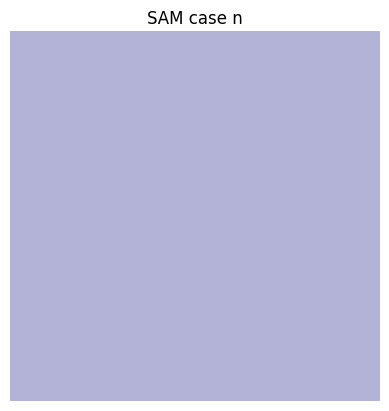

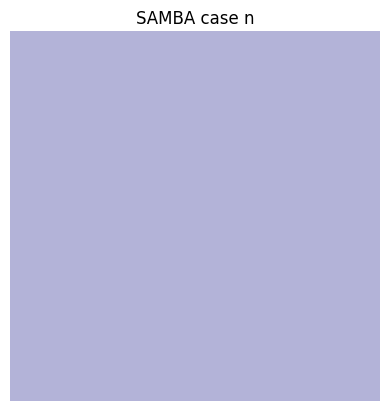

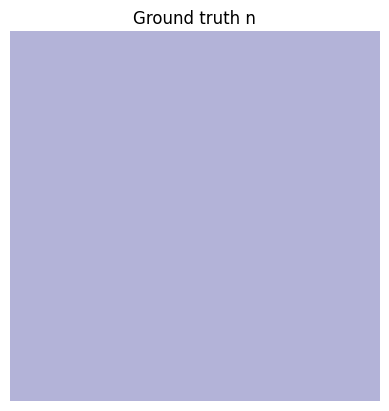

 87%|████████▋ | 68/78 [01:12<00:09,  1.08it/s]

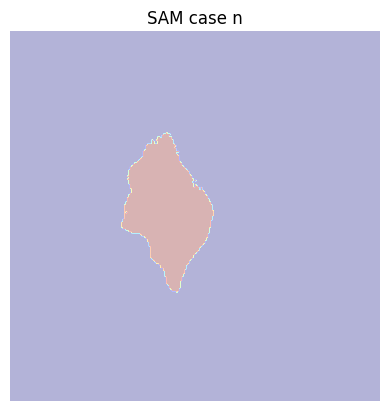

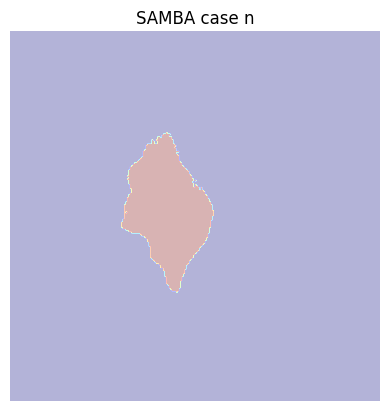

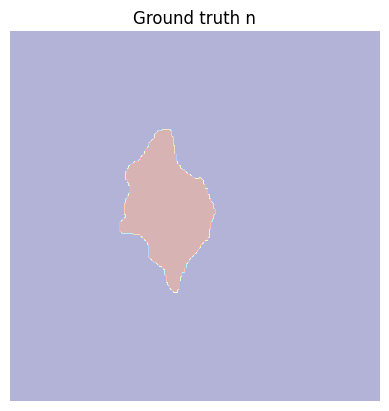

 88%|████████▊ | 69/78 [01:13<00:07,  1.16it/s]

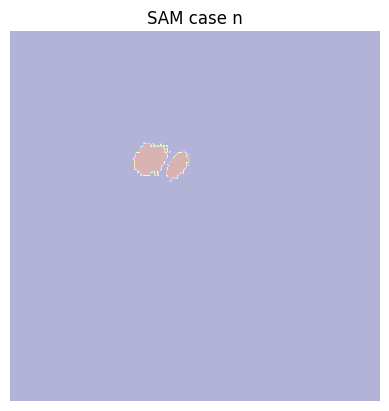

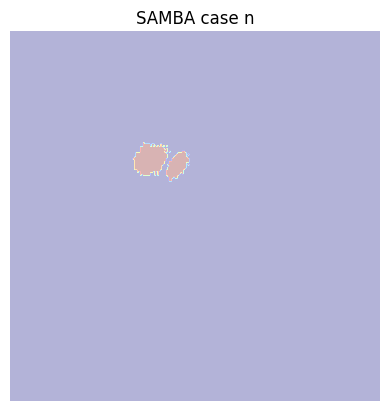

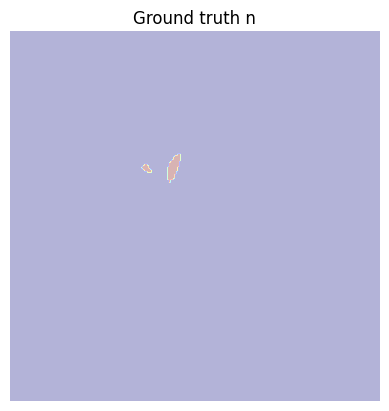

 90%|████████▉ | 70/78 [01:14<00:06,  1.22it/s]

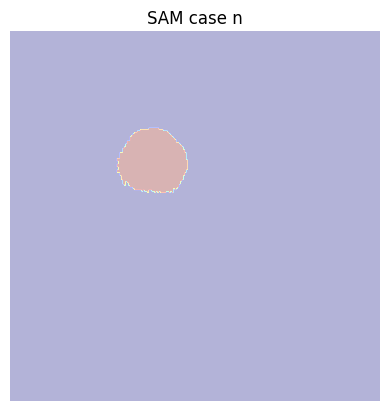

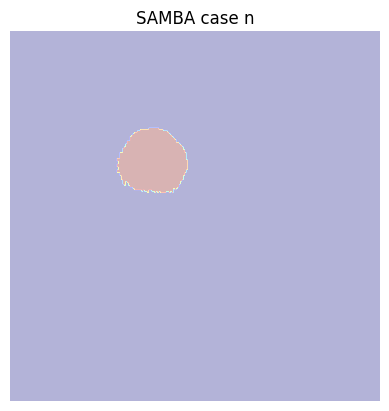

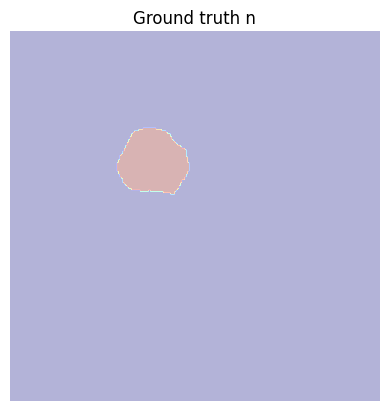

 91%|█████████ | 71/78 [01:14<00:05,  1.28it/s]

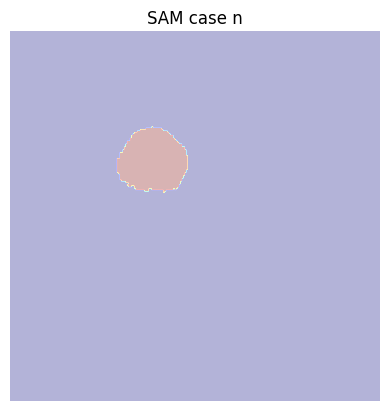

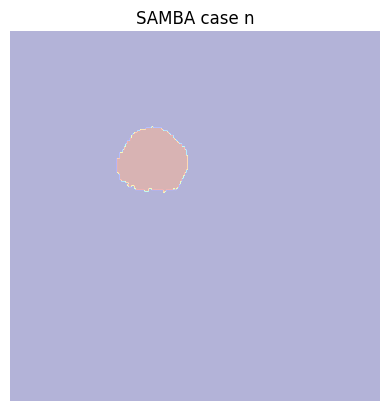

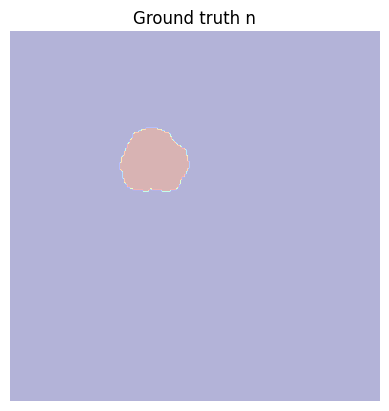

 92%|█████████▏| 72/78 [01:15<00:04,  1.34it/s]

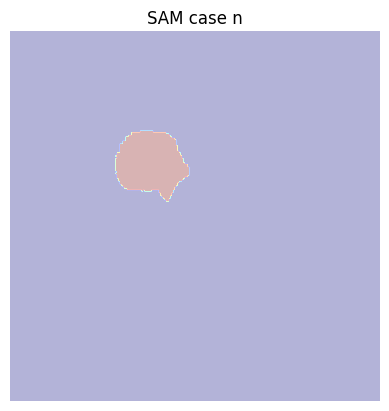

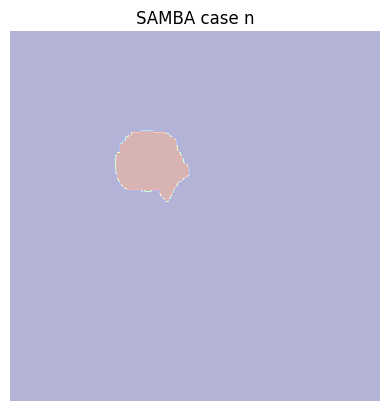

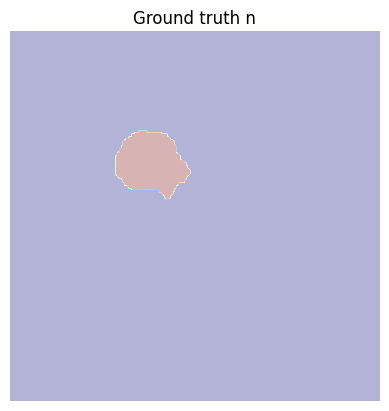

 94%|█████████▎| 73/78 [01:16<00:03,  1.37it/s]

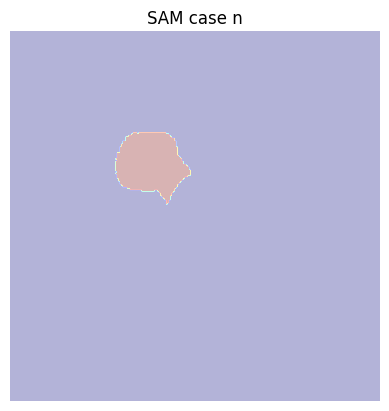

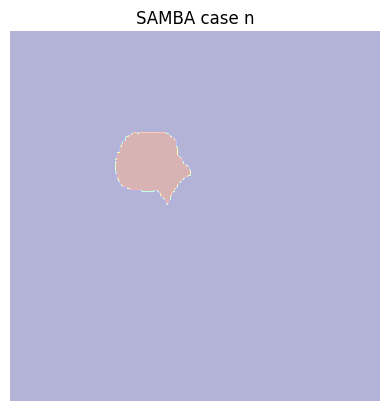

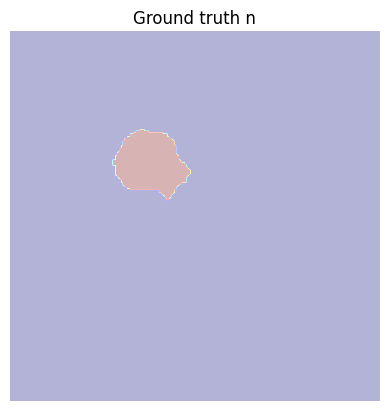

 95%|█████████▍| 74/78 [01:16<00:02,  1.40it/s]

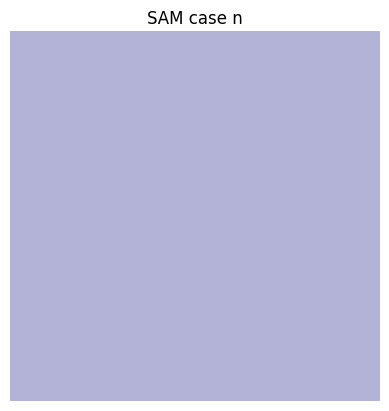

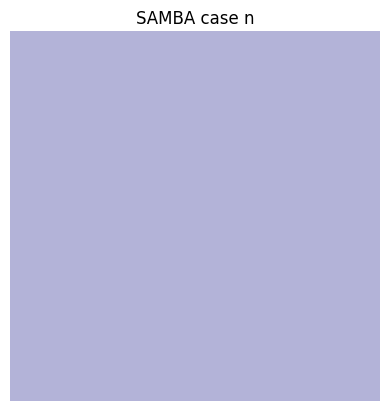

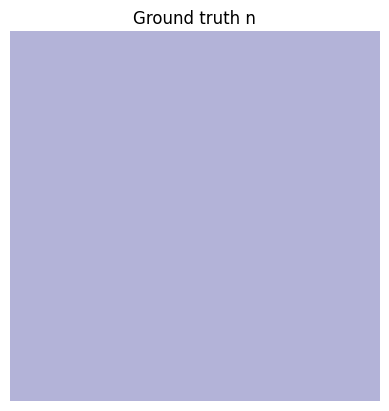

 96%|█████████▌| 75/78 [01:17<00:02,  1.42it/s]

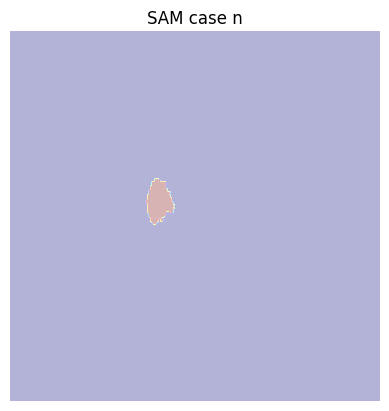

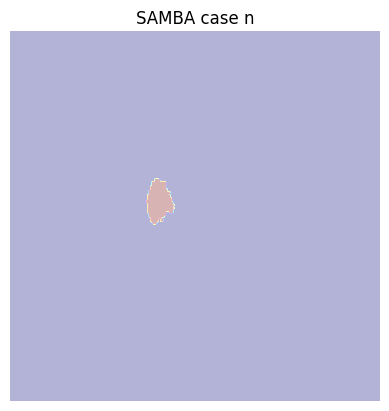

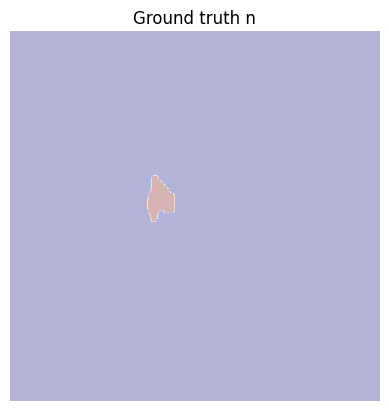

 97%|█████████▋| 76/78 [01:18<00:01,  1.40it/s]

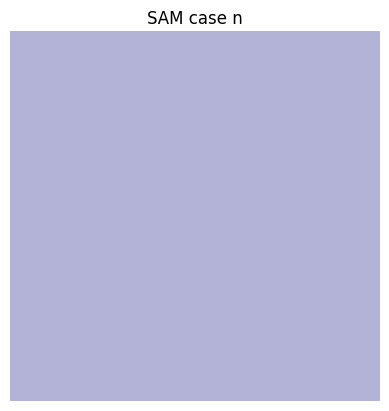

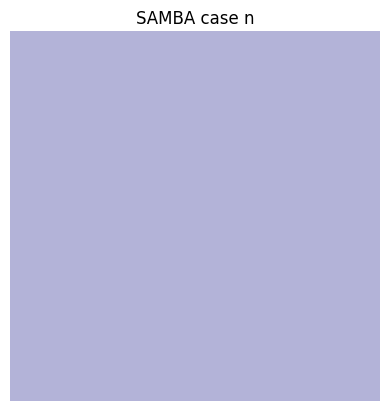

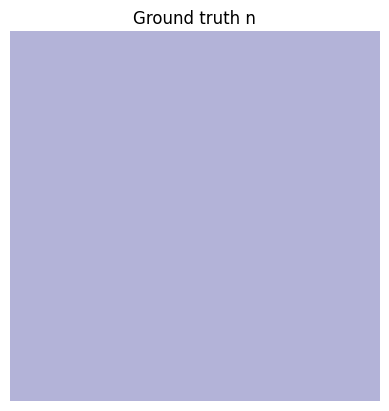

 99%|█████████▊| 77/78 [01:19<00:00,  1.34it/s]

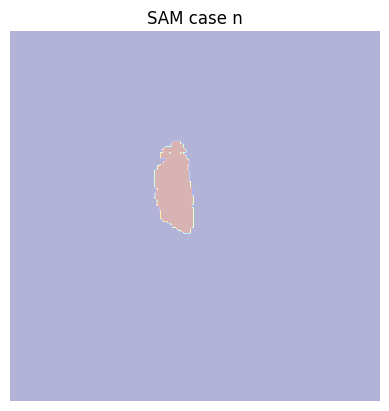

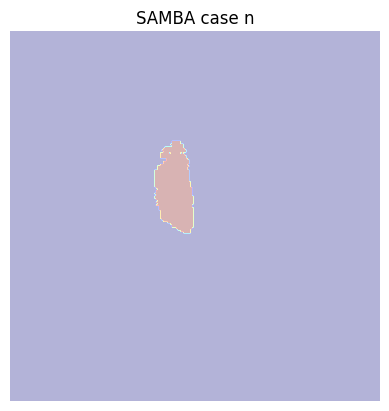

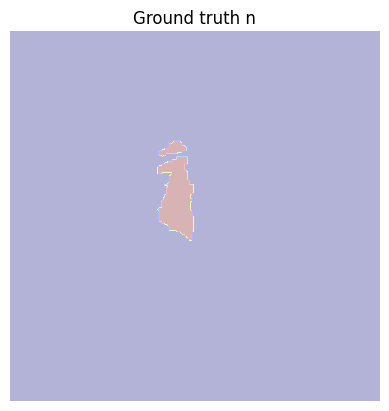

100%|██████████| 78/78 [01:19<00:00,  1.03s/it]

SAM DICE:0.09799629259000818, SAMBA DICE:0.09799629259000818


In [ ]:
import cv2
sam_orig_loss = 0
samba_loss = 0
sam_orig_model = sam_model
seg_loss = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, reduction='mean')

for step, data in enumerate(tqdm(train_loader)):
  embedding, mask, box = data["embedding"], data["mask"], data["box"]


  with torch.no_grad():

    # print(embedding.shape)
    # print(box.shape)

    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
        points=None,
        boxes=box,
        masks=None,
    )

    sparse_embeddings_orig, dense_embeddings_orig = sam_orig_model.prompt_encoder(
        points=None,
        boxes=box,
        masks=None,
    )

    # predicted masks
    mask_predictions, _ = sam_model.mask_decoder(
      image_embeddings= embedding.to(device), # (B, 256, 64, 64)
      image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
      sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
      dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
      multimask_output=False,
    )

    mask_predictions_orig, _ = sam_orig_model.mask_decoder(
      image_embeddings= embedding.to(device), # (B, 256, 64, 64)
      image_pe=sam_orig_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
      sparse_prompt_embeddings=sparse_embeddings_orig, # (B, 2, 256)
      dense_prompt_embeddings=dense_embeddings_orig, # (B, 256, 64, 64)
      multimask_output=False,
    )

  samba_loss += seg_loss(mask_predictions, mask.to(device))
  sam_orig_loss += seg_loss(mask_predictions_orig, mask.to(device))

  # plt_image = np.rot90(cv2.resize(image.cpu().numpy()[0][0], (256, 256)), 3)
  plt_masks_orig =  np.rot90(mask_predictions_orig.cpu().numpy()[0][0]>.5, 3)
  plt_mask_samba =  np.rot90(mask_predictions.cpu().numpy()[0][0]>.5, 3)
  plt_mask_gt = np.rot90(mask.cpu().numpy()[0][0], 3)


  name = "noha"
  plt.figure()
  # plt.imshow(plt_image, cmap='gray')
  plt.imshow(plt_masks_orig, cmap='jet', alpha=0.3)
  plt.title(f'SAM case {name[0].split("/")[-1].split(".")[0]}')
  plt.axis('off')
  plt.show()

  plt.figure()
  # plt.imshow(plt_image, cmap='gray')
  plt.imshow(plt_mask_samba, cmap='jet', alpha=0.3)
  plt.title(f'SAMBA case {name[0].split("/")[-1].split(".")[0]}')
  plt.axis('off')
  plt.show()


  plt.figure()
  # plt.imshow(plt_image, cmap='gray')
  plt.imshow(plt_mask_gt, cmap='jet', alpha=0.3)
  plt.title(f'Ground truth {name[0].split("/")[-1].split(".")[0]}')
  plt.axis('off')
  plt.show()

print(f"SAM DICE:{sam_orig_loss/(step+1)}, SAMBA DICE:{samba_loss/(step+1)}")

### 2d input 3d mask bounding box

In [ ]:
# 2d input 3d mask



print("Bounding box, flair_z")
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
# import wandb
import nibabel as nib
from segment_anything.utils.transforms import ResizeLongestSide
import torch.nn.functional as F
from skimage import transform, io, segmentation
import random


torch.manual_seed(2023)
np.random.seed(2023)

# change here
data_path = "/content/out"


def squarify(M,val = 0):
    (a,b)=M.shape
    if a>b:
        padding=((0,0),(0,a-b))
    else:
        padding=((0,b-a),(0,0))
    return np.pad(M,padding,mode='constant',constant_values=val)



def get_bounding_box(mask):

  y_indices, x_indices = np.where(mask > 0)
  if len(y_indices) == 0:
    return [0,0,0,0]
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = mask.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  # bboxes = np.array([x_min, y_min, x_max, y_max])

  return [x_min, y_min, x_max, y_max]


def get_points(mask):
  mask= mask.cpu().numpy()
  mask = np.squeeze(mask, axis = 0)
  x = np.where(mask>0)
  if len(x[0]) == 0:
    return (0,0)
  all_points = list(zip(x[0], x[1]))
  return random.choices(all_points)


def dice_loss(y_true, y_pred):
    """
    implementation for generalized dice score loss
    GDL = 1 - (2 * sum(intersection)/(sum(pred)+sum(true)))
    """

    # y_pred = tf.round(y_pred)
    intersection = torch.sum(y_true * y_pred)
    pred_sum = torch.sum( y_pred)
    true_sum = torch.sum( y_true)
    smooth = torch.ones_like(intersection)*1e-5
    return 1-((2*intersection+smooth)/(pred_sum+true_sum+smooth))


model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to('cuda')



embedding_path = "/content/BraTS_data/flair/z/embeddings"
ground_truth_path = "/content/drive/MyDrive/SSA"

train_list = os.listdir(embedding_path)
train_list = train_list#[:int(len(train_list)*0.7)]
val_list = train_list#[int(len(train_list)*0.7):]

class BraTSDataset(Dataset):

    def __init__(self, ground_truth_path, embedding_path, list_of_data, device='cuda'):
        """
        Args:
            embedding_path (string): Path to  images.
            masks_path (string): path to masks.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.ground_truth_path = ground_truth_path
        self.device = device
        self.list_of_data = list_of_data
        self.embedding_path = embedding_path

    def __len__(self):
        return len(self.list_of_data)

    def __getitem__(self, idx):


      embedding = np.load(self.embedding_path + "/" + self.list_of_data[idx])
      embedding = torch.as_tensor(embedding, dtype=torch.float, device=self.device)


      #--------------------------------------------------
      case_id = self.list_of_data[idx].split("_")[0]
      slice_ = int(self.list_of_data[idx].split("_")[-1].split(".")[0])
      # "BraTS2021_00000"
      case_name = case_id
      img =  nib.load(self.ground_truth_path + "/" + case_name + "/"+ case_name +"-seg.nii.gz")
      img = img.get_fdata()
      mask = img[:,:,slice_]

      mask[mask>0] = 1
      # mask = squarify(mask)



      mask = transform.resize(
                      mask,
                      (256, 256),
                      order=0,
                      preserve_range=True,
                      mode="constant",
                  )

        # class_1 = np.zeros_like(mask)
        # class_2 = np.zeros_like(mask)
        # class_3 = np.zeros_like(mask)

        # class_1[np.where(mask == 1)] = 1
        # class_2[np.where(mask == 2)] = 1
        # class_3[np.where(mask == 4)] = 1

        # mask = mask = np.stack((class_1, class_2, class_3), axis = -1 )


      box = get_bounding_box(mask)
      # box = [0,0,mask.shape[-2],mask.shape[-1]]
      box_np = np.array(box)
      sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
      box = sam_trans.apply_boxes(box_np, (mask.shape[-2], mask.shape[-1]))
      box_torch = torch.as_tensor(box, dtype=torch.float, device=self.device)

      mask = torch.as_tensor(mask).to(self.device)
      mask = mask[None,...]


      sample = {"embedding": embedding,
                  'mask': mask,
                  'box' : box_torch
                  }

      return sample


train = BraTSDataset(ground_truth_path, embedding_path, train_list)
val = BraTSDataset(ground_truth_path, embedding_path, val_list)



train_loader = DataLoader(train, batch_size= 2, shuffle=True, num_workers=0)
val_loader = DataLoader(val, batch_size= 1, shuffle=True, num_workers=0)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



hprams = {
    "num_epochs": 10,
    "best_loss": 1e10,
    "model_save_path": "/content",
    "lr":1e-4,
    "weight_decay":0,
    "device": device,
    "train_dataloader": train_loader,
    "val_dataloader": val_loader
    }

def eval(val_dataloader, sam_model, seg_loss):
  loss = 0
  for step_val, data in enumerate(val_dataloader):
    embedding, mask, box = data["embedding"], data["mask"], data["box"]

    with torch.no_grad():
      # embedding = sam_model.image_encoder(image)
      sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
          points=None,
          boxes=box,
          masks=None,
      )

      # predicted masks
      mask_predictions, _ = sam_model.mask_decoder(
      image_embeddings= embedding.to(device), # (B, 256, 64, 64)
      image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
      sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
      dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
      multimask_output=False,
      )

      loss += seg_loss(mask_predictions, mask.to(device))
  loss /= step_val+1
  return loss



def train(**kwargs):
    model_save_path = kwargs['model_save_path']
    num_epochs = kwargs['num_epochs']
    best_loss = kwargs['best_loss']
    lr = kwargs['lr']
    weight_decay = kwargs['weight_decay']
    device = kwargs['device']
    train_dataloader = kwargs['train_dataloader']
    # embedding_path = kwargs['embedding_path']
    val_dataloader = kwargs['val_dataloader']

    os.makedirs(model_save_path, exist_ok=True)

    sam_model.train()
    optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, factor=0.25,  patience=3)
    seg_loss = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, reduction='mean')


    for epoch in range(num_epochs):
        epoch_loss = 0
        # train
        for step, data in enumerate(tqdm(train_dataloader)):
            mask, box, embedding =  data["mask"], data["box"], data["embedding"]

            embedding.to(device)

            with torch.no_grad():

              sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                  points=None,
                  boxes=box,
                  masks=None,
              )

            # predicted masks
            mask_predictions, _ = sam_model.mask_decoder(
              image_embeddings= embedding.to(device), # (B, 256, 64, 64)
              image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
              sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
              dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
              multimask_output=False,
            )

            loss = seg_loss(mask_predictions, mask.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            # break
        epoch_loss /= step+1
        scheduler.step(epoch_loss)
        val_loss = None
        if val_dataloader is not None: val_loss = eval(val_dataloader, sam_model, seg_loss)
        print(f'EPOCH: {epoch}, Loss: {epoch_loss}, Val loss {val_loss}')
        # wandb.log({"epoch": epoch, "loss": loss})

        # save the latest model checkpoint
        # torch.save(sam_model.state_dict(), os.path.join(model_save_path, 'sam_model_'+str(epoch)+'.pth'))

        # save the best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(sam_model.state_dict(), os.path.join(model_save_path, 'sam_model_best.pth'))




train(**hprams)

Bounding box, flair_z


100%|██████████| 78/78 [00:33<00:00,  2.34it/s]


EPOCH: 0, Loss: 0.17350555734554107, Val loss 0.13867368904189603


100%|██████████| 78/78 [00:35<00:00,  2.20it/s]


EPOCH: 1, Loss: 0.1314567650222784, Val loss 0.10732789652689087


100%|██████████| 78/78 [00:33<00:00,  2.36it/s]


EPOCH: 2, Loss: 0.11549362063208957, Val loss 0.10359410724722787


100%|██████████| 78/78 [00:33<00:00,  2.31it/s]


EPOCH: 3, Loss: 0.10205579652510659, Val loss 0.10959498125715095


100%|██████████| 78/78 [00:22<00:00,  3.44it/s]


EPOCH: 4, Loss: 0.10379281850050986, Val loss 0.101407551191446


100%|██████████| 78/78 [00:27<00:00,  2.86it/s]


EPOCH: 5, Loss: 0.10281590766993934, Val loss 0.09443384132721147


100%|██████████| 78/78 [00:27<00:00,  2.88it/s]


EPOCH: 6, Loss: 0.0940085523396708, Val loss 0.08447432163873846


100%|██████████| 78/78 [00:26<00:00,  2.92it/s]


EPOCH: 7, Loss: 0.08650105207105595, Val loss 0.09354692626295137


100%|██████████| 78/78 [00:22<00:00,  3.40it/s]


KeyboardInterrupt: ignored

In [ ]:
# 2d input 3d mask



print("Bounding box, flair_z")
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
# import wandb
import nibabel as nib
from segment_anything.utils.transforms import ResizeLongestSide
import torch.nn.functional as F
from skimage import transform, io, segmentation
import random


torch.manual_seed(2023)
np.random.seed(2023)

# change here
data_path = "/content/out"


def squarify(M,val = 0):
    (a,b)=M.shape
    if a>b:
        padding=((0,0),(0,a-b))
    else:
        padding=((0,b-a),(0,0))
    return np.pad(M,padding,mode='constant',constant_values=val)



def get_bounding_box(mask):

  y_indices, x_indices = np.where(mask > 0)
  if len(y_indices) == 0:
    return [0,0,0,0]
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = mask.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  # bboxes = np.array([x_min, y_min, x_max, y_max])

  return [x_min, y_min, x_max, y_max]


def get_points(mask):
  mask= mask.cpu().numpy()
  mask = np.squeeze(mask, axis = 0)
  x = np.where(mask>0)
  if len(x[0]) == 0:
    return (0,0)
  all_points = list(zip(x[0], x[1]))
  return random.choices(all_points)


def dice_loss(y_true, y_pred):
    """
    implementation for generalized dice score loss
    GDL = 1 - (2 * sum(intersection)/(sum(pred)+sum(true)))
    """

    # y_pred = tf.round(y_pred)
    intersection = torch.sum(y_true * y_pred)
    pred_sum = torch.sum( y_pred)
    true_sum = torch.sum( y_true)
    smooth = torch.ones_like(intersection)*1e-5
    return 1-((2*intersection+smooth)/(pred_sum+true_sum+smooth))


model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to('cuda')



embedding_path = "/content/BraTS_data/flair/z/embeddings"
ground_truth_path = "/content/out"

train_list = os.listdir(embedding_path)
train_list = train_list#[:int(len(train_list)*0.7)]
val_list = train_list#[int(len(train_list)*0.7):]

class BraTSDataset(Dataset):

    def __init__(self, ground_truth_path, embedding_path, list_of_data, device='cuda'):
        """
        Args:
            embedding_path (string): Path to  images.
            masks_path (string): path to masks.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.ground_truth_path = ground_truth_path
        self.device = device
        self.list_of_data = list_of_data
        self.embedding_path = embedding_path

    def __len__(self):
        return len(self.list_of_data)

    def __getitem__(self, idx):


      embedding = np.load(self.embedding_path + "/" + self.list_of_data[idx])
      embedding = torch.as_tensor(embedding, dtype=torch.float, device=self.device)


      #--------------------------------------------------
      case_id = self.list_of_data[idx].split("_")[1]
      slice_ = int(self.list_of_data[idx].split("_")[-1].split(".")[0])
      # "BraTS2021_00000"
      case_name = "BraTS2021_"+ case_id
      img =  nib.load(self.ground_truth_path + "/" + case_name + "/"+ case_name +"_seg.nii.gz")
      img = img.get_fdata()
      mask = img[:,:,slice_]

      mask[mask>0] = 1
      # mask = squarify(mask)



      mask = transform.resize(
                      mask,
                      (256, 256),
                      order=0,
                      preserve_range=True,
                      mode="constant",
                  )

        # class_1 = np.zeros_like(mask)
        # class_2 = np.zeros_like(mask)
        # class_3 = np.zeros_like(mask)

        # class_1[np.where(mask == 1)] = 1
        # class_2[np.where(mask == 2)] = 1
        # class_3[np.where(mask == 4)] = 1

        # mask = mask = np.stack((class_1, class_2, class_3), axis = -1 )


      box = get_bounding_box(mask)
      # box = [0,0,mask.shape[-2],mask.shape[-1]]
      box_np = np.array(box)
      sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
      box = sam_trans.apply_boxes(box_np, (mask.shape[-2], mask.shape[-1]))
      box_torch = torch.as_tensor(box, dtype=torch.float, device=self.device)

      mask = torch.as_tensor(mask).to(self.device)
      mask = mask[None,...]


      sample = {"embedding": embedding,
                  'mask': mask,
                  'box' : box_torch
                  }

      return sample


train = BraTSDataset(ground_truth_path, embedding_path, train_list)
val = BraTSDataset(ground_truth_path, embedding_path, val_list)



train_loader = DataLoader(train, batch_size= 2, shuffle=True, num_workers=0)
val_loader = DataLoader(val, batch_size= 1, shuffle=True, num_workers=0)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



hprams = {
    "num_epochs": 10,
    "best_loss": 1e10,
    "model_save_path": "/content",
    "lr":1e-4,
    "weight_decay":0,
    "device": device,
    "train_dataloader": train_loader,
    "val_dataloader": val_loader
    }

def eval(val_dataloader, sam_model, seg_loss):
  loss = 0
  for step_val, data in enumerate(val_dataloader):
    embedding, mask, box = data["embedding"], data["mask"], data["box"]

    with torch.no_grad():
      # embedding = sam_model.image_encoder(image)
      sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
          points=None,
          boxes=box,
          masks=None,
      )

      # predicted masks
      mask_predictions, _ = sam_model.mask_decoder(
      image_embeddings= embedding.to(device), # (B, 256, 64, 64)
      image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
      sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
      dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
      multimask_output=False,
      )

      loss += seg_loss(mask_predictions, mask.to(device))
  loss /= step_val+1
  return loss



def train(**kwargs):
    model_save_path = kwargs['model_save_path']
    num_epochs = kwargs['num_epochs']
    best_loss = kwargs['best_loss']
    lr = kwargs['lr']
    weight_decay = kwargs['weight_decay']
    device = kwargs['device']
    train_dataloader = kwargs['train_dataloader']
    # embedding_path = kwargs['embedding_path']
    val_dataloader = kwargs['val_dataloader']

    os.makedirs(model_save_path, exist_ok=True)

    sam_model.train()
    optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, factor=0.25,  patience=3)
    seg_loss = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, reduction='mean')


    for epoch in range(num_epochs):
        epoch_loss = 0
        # train
        for step, data in enumerate(tqdm(train_dataloader)):
            mask, box, embedding =  data["mask"], data["box"], data["embedding"]

            embedding.to(device)

            with torch.no_grad():

              sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                  points=None,
                  boxes=box,
                  masks=None,
              )

            # predicted masks
            mask_predictions, _ = sam_model.mask_decoder(
              image_embeddings= embedding.to(device), # (B, 256, 64, 64)
              image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
              sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
              dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
              multimask_output=False,
            )

            loss = seg_loss(mask_predictions, mask.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            # break
        epoch_loss /= step+1
        scheduler.step(epoch_loss)
        val_loss = None
        if val_dataloader is not None: val_loss = eval(val_dataloader, sam_model, seg_loss)
        print(f'EPOCH: {epoch}, Loss: {epoch_loss}, Val loss {val_loss}')
        # wandb.log({"epoch": epoch, "loss": loss})

        # save the latest model checkpoint
        # torch.save(sam_model.state_dict(), os.path.join(model_save_path, 'sam_model_'+str(epoch)+'.pth'))

        # save the best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(sam_model.state_dict(), os.path.join(model_save_path, 'sam_model_best.pth'))




train(**hprams)

### 3D Data bounding box

In [ ]:
# 3d embedding saved

print("")
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
# import wandb
import nibabel as nib
from segment_anything.utils.transforms import ResizeLongestSide
import torch.nn.functional as F
from skimage import transform, io, segmentation
import random



torch.manual_seed(2023)
np.random.seed(2023)

# change here
data_path = "/content/out"


def squarify(M,val = 0):
    (a,b)=M.shape
    if a>b:
        padding=((0,0),(0,a-b))
    else:
        padding=((0,b-a),(0,0))
    return np.pad(M,padding,mode='constant',constant_values=val)



def get_bounding_box(mask):

  y_indices, x_indices = np.where(mask > 0)
  if len(y_indices) == 0:
    return [0,0,0,0]
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = mask.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  # bboxes = np.array([x_min, y_min, x_max, y_max])

  return [x_min, y_min, x_max, y_max]


def dice_loss(y_true, y_pred):
    """
    implementation for generalized dice score loss
    GDL = 1 - (2 * sum(intersection)/(sum(pred)+sum(true)))
    """

    # y_pred = tf.round(y_pred)
    intersection = torch.sum(y_true * y_pred)
    pred_sum = torch.sum( y_pred)
    true_sum = torch.sum( y_true)
    smooth = torch.ones_like(intersection)*1e-5
    return 1-((2*intersection+smooth)/(pred_sum+true_sum+smooth))


model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to('cuda')



embedding_path = "/content/BraTS_data/flair"
ground_truth_path = "/content/out"

train_list = sorted(os.listdir(embedding_path + "/z/embeddings"))
train_list = train_list#[:int(len(train_list)*0.7)]
val_list = train_list#[int(len(train_list)*0.7):]

class BraTSDataset(Dataset):

    def __init__(self, ground_truth_path, embedding_path, list_of_data, device='cuda'):
        """
        Args:
            embedding_path (string): Path to  images.
            masks_path (string): path to masks.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.ground_truth_path = ground_truth_path
        self.device = device
        self.list_of_data = list_of_data
        self.embedding_path = embedding_path
        # self.gt_list = sorted(os.listdir(self.ground_truth_path))

    def __len__(self):
      return len(self.list_of_data)*240

    def __getitem__(self, idx):
      # print("here")
      case_num = idx % len(self.list_of_data)
      # print("case_num ", case_num)
      dimention = random.choice(["x", "y", "z"])
      # print("dimention ", dimention)
      case_name = self.list_of_data[case_num]
      # print("case_name ", case_name)

      img =  nib.load(self.ground_truth_path + "/" + case_name.split(".")[0] + "/"+ case_name.split(".")[0] +"_seg.nii.gz")
      img = img.get_fdata()

      if dimention == "z":
        num_slices = img.shape[-1]-1
        slice_num = random.randint(0, num_slices)
        mask = img[:,:,slice_num]
      elif dimention == "y":
        num_slices = img.shape[1]-1
        slice_num = random.randint(0, num_slices)
        mask = img[:,slice_num,:]
      elif dimention == "x":
        num_slices = img.shape[0]-1
        slice_num = random.randint(0, num_slices)
        mask = img[slice_num,:,:]

      # print("load ", self.embedding_path + "/" + dimention + "/embeddings/" + case_name)
      d_embedding = np.load(self.embedding_path + "/" + dimention + "/embeddings/" + case_name)
      embedding = d_embedding[slice_num,:,:,:]
      embedding = torch.as_tensor(embedding, dtype=torch.float, device=self.device)

      #--------------------------------------------------


      mask[mask>0] = 1
      if dimention != "z":
        mask = squarify(mask)

      mask = transform.resize(
                      mask,
                      (256, 256),
                      order=0,
                      preserve_range=True,
                      mode="constant",
                  )


        # class_1 = np.zeros_like(mask)
        # class_2 = np.zeros_like(mask)
        # class_3 = np.zeros_like(mask)

        # class_1[np.where(mask == 1)] = 1
        # class_2[np.where(mask == 2)] = 1
        # class_3[np.where(mask == 4)] = 1

        # mask = mask = np.stack((class_1, class_2, class_3), axis = -1 )


      box = get_bounding_box(mask)
      # box = [0,0,mask.shape[-2],mask.shape[-1]]
      box_np = np.array(box)
      sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
      box = sam_trans.apply_boxes(box_np, (mask.shape[-2], mask.shape[-1]))
      box_torch = torch.as_tensor(box, dtype=torch.float, device=self.device)


      mask = torch.as_tensor(mask).to(self.device)
      mask = mask[None,...]

      sample = {"embedding": embedding,
                  'mask': mask,
                  'box' : box_torch
                  }

      return sample


train = BraTSDataset(ground_truth_path, embedding_path, train_list)
val = BraTSDataset(ground_truth_path, embedding_path, val_list)



train_loader = DataLoader(train, batch_size= 8, shuffle=True, num_workers=0)
val_loader = DataLoader(val, batch_size= 4, shuffle=True, num_workers=0)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



hprams = {
    "num_epochs": 15,
    "best_loss": 1e10,
    "model_save_path": "/content",
    "lr":1e-5,
    "weight_decay":0,
    "device": device,
    "train_dataloader": train_loader,
    "val_dataloader": val_loader
    }

def eval(val_dataloader, sam_model, seg_loss):
  loss = 0
  for step_val, data in enumerate(val_dataloader):
    embedding, mask, box = data["embedding"], data["mask"], data["box"]

    with torch.no_grad():
      # embedding = sam_model.image_encoder(image)
      sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
          points=None,
          boxes=box,
          masks=None,
      )

      # predicted masks
      mask_predictions, _ = sam_model.mask_decoder(
      image_embeddings= embedding.to(device), # (B, 256, 64, 64)
      image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
      sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
      dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
      multimask_output=False,
      )

      loss += seg_loss(mask_predictions, mask.to(device))
  loss /= step_val+1
  return loss



def train(**kwargs):
    model_save_path = kwargs['model_save_path']
    num_epochs = kwargs['num_epochs']
    best_loss = kwargs['best_loss']
    lr = kwargs['lr']
    weight_decay = kwargs['weight_decay']
    device = kwargs['device']
    train_dataloader = kwargs['train_dataloader']
    # embedding_path = kwargs['embedding_path']
    val_dataloader = kwargs['val_dataloader']

    os.makedirs(model_save_path, exist_ok=True)

    sam_model.train()
    optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, factor=0.25,  patience=5)
    seg_loss = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, reduction='mean')


    for epoch in range(num_epochs):
        epoch_loss = 0
        # train
        for step, data in enumerate(tqdm(train_dataloader)):
            mask, box, embedding =  data["mask"], data["box"], data["embedding"]
            embedding.to(device)

            with torch.no_grad():

              sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                  points=None,
                  boxes=box,
                  masks=None,
              )

            # predicted masks
            mask_predictions, _ = sam_model.mask_decoder(
              image_embeddings= embedding.to(device), # (B, 256, 64, 64)
              image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
              sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
              dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
              multimask_output=False,
            )

            loss = seg_loss(mask_predictions, mask.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            # break
        epoch_loss /= step+1
        scheduler.step(epoch_loss)
        val_loss = None
        if val_dataloader is not None: val_loss = eval(val_dataloader, sam_model, seg_loss)
        print(f'EPOCH: {epoch}, Loss: {epoch_loss}, Val loss {val_loss}')
        # wandb.log({"epoch": epoch, "loss": loss})

        # save the latest model checkpoint
        # torch.save(sam_model.state_dict(), os.path.join(model_save_path, 'sam_model_'+str(epoch)+'.pth'))

        # save the best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(sam_model.state_dict(), os.path.join(model_save_path, 'sam_model_best.pth'))




train(**hprams)

100%|██████████| 30/30 [02:38<00:00,  5.28s/it]


EPOCH: 0, Loss: 0.7988438378757458, Val loss 0.3856282816872183


100%|██████████| 30/30 [01:29<00:00,  2.99s/it]


EPOCH: 1, Loss: 0.09863034727151887, Val loss 0.08338226538287938


100%|██████████| 30/30 [01:33<00:00,  3.10s/it]


EPOCH: 2, Loss: 0.06896541947805802, Val loss 0.07994356163089743


100%|██████████| 30/30 [01:33<00:00,  3.12s/it]


EPOCH: 3, Loss: 0.06563626750859229, Val loss 0.06892285899690641


100%|██████████| 30/30 [01:28<00:00,  2.97s/it]


EPOCH: 4, Loss: 0.07491849153776912, Val loss 0.0677525324918902


100%|██████████| 30/30 [01:35<00:00,  3.19s/it]


EPOCH: 5, Loss: 0.05570869399403145, Val loss 0.08008886997064923


100%|██████████| 30/30 [01:26<00:00,  2.87s/it]


EPOCH: 6, Loss: 0.06977581771663437, Val loss 0.07813699568029078


100%|██████████| 30/30 [01:21<00:00,  2.72s/it]


EPOCH: 7, Loss: 0.04885797242173533, Val loss 0.07424530788603946


100%|██████████| 30/30 [01:23<00:00,  2.78s/it]


EPOCH: 8, Loss: 0.06889657579494993, Val loss 0.04297592236216378


100%|██████████| 30/30 [01:33<00:00,  3.12s/it]


EPOCH: 9, Loss: 0.09022685590375676, Val loss 0.0818023432714045


100%|██████████| 30/30 [01:25<00:00,  2.84s/it]


EPOCH: 10, Loss: 0.056509598981051616, Val loss 0.06383700802814066


100%|██████████| 30/30 [01:23<00:00,  2.79s/it]


EPOCH: 11, Loss: 0.05698066823430859, Val loss 0.06004206981440264


100%|██████████| 30/30 [01:25<00:00,  2.86s/it]


EPOCH: 12, Loss: 0.06111269520512788, Val loss 0.0614928682096635


100%|██████████| 30/30 [01:22<00:00,  2.76s/it]


Epoch 00014: reducing learning rate of group 0 to 2.5000e-06.
EPOCH: 13, Loss: 0.056693815905440224, Val loss 0.04931717715829617


100%|██████████| 30/30 [01:21<00:00,  2.73s/it]


EPOCH: 14, Loss: 0.04653335464343914, Val loss 0.06226881564714842


In [ ]:
# 3d embedding saved

print("")
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
# import wandb
import nibabel as nib
from segment_anything.utils.transforms import ResizeLongestSide
import torch.nn.functional as F
from skimage import transform, io, segmentation
import random
from monai.data import ThreadDataLoader, CacheDataset



torch.manual_seed(2023)
np.random.seed(2023)

# change here
data_path = "/content/out"


def squarify(M,val = 0):
    (a,b)=M.shape
    if a>b:
        padding=((0,0),(0,a-b))
    else:
        padding=((0,b-a),(0,0))
    return np.pad(M,padding,mode='constant',constant_values=val)



def get_bounding_box(mask):

  y_indices, x_indices = np.where(mask > 0)
  if len(y_indices) == 0:
    return [0,0,0,0]
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = mask.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  # bboxes = np.array([x_min, y_min, x_max, y_max])

  return [x_min, y_min, x_max, y_max]


def get_cases_list(input_base, masks_path):
  images = []
  # for i in os.listdir(masks_path):
  for i in  ["BraTS-SSA-00002-000"]:
    img =  nib.load(masks_path + "/" + i + "/"+ i +"-seg.nii.gz")
    img = img.get_fdata()
    sclices_z = img.shape[2]
    sclices_y = img.shape[1]
    sclices_x = img.shape[0]
    for z in range(sclices_z):
      if img[:,:,z].max() != 0:
        images.append((i ,z, "flair/z"))
        images.append((i ,z, "t1/z"))
        images.append((i ,z, "t2/z"))
        images.append((i ,z, "t1ce/z"))

    for y in range(sclices_y):
      if img[:,y,:].max() != 0:
        images.append((i ,y, "flair/y"))
        images.append((i ,y, "t1/y"))
        images.append((i ,y, "t2/y"))
        images.append((i ,y, "t1ce/y"))


    for x in range(sclices_x):
      if img[x,:,:].max() != 0:
        images.append(( i ,x, "flair/x"))
        images.append(( i ,x, "t1/x"))
        images.append((i ,x, "t2/x"))
        images.append(( i ,x, "t1ce/x"))

    return images


def dice_loss(y_true, y_pred):
    """
    implementation for generalized dice score loss
    GDL = 1 - (2 * sum(intersection)/(sum(pred)+sum(true)))
    """

    # y_pred = tf.round(y_pred)
    intersection = torch.sum(y_true * y_pred)
    pred_sum = torch.sum( y_pred)
    true_sum = torch.sum( y_true)
    smooth = torch.ones_like(intersection)*1e-5
    return 1-((2*intersection+smooth)/(pred_sum+true_sum+smooth))


# model_type = 'vit_h'
# checkpoint = 'sam_vit_h_4b8939.pth'
# sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to('cuda')



embedding_path = "/content/BraTS_data"
ground_truth_path = "/content/drive/MyDrive/SSA"

data = get_cases_list(embedding_path, ground_truth_path)
print(len(data))
train_list = data[:155]
val_list = data[155:200]
# train_list = train_list[:int(len(train_list)*0.7)]
# val_list = train_list[int(len(train_list)*0.7):]

class BraTSDataset(CacheDataset):

    def __init__(self, ground_truth_path, embedding_path, list_of_data, device='cuda'):
        """
        Args:
            embedding_path (string): Path to  images.
            masks_path (string): path to masks.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.ground_truth_path = ground_truth_path
        self.device = device
        self.list_of_data = list_of_data
        self.embedding_path = embedding_path

    def __len__(self):
      return len(self.list_of_data)

    def __getitem__(self, idx):
      case_name, slic, d = self.list_of_data[idx]

      img =  nib.load(self.ground_truth_path + "/" + case_name.split(".")[0] + "/"+ case_name.split(".")[0] +"-seg.nii.gz")
      img = img.get_fdata()

      dim =  d.split("/")[-1]
      if dim == "x":
        mask = img[slic,:,:]
      elif dim == "y":
        mask = img[:,slic,:]
      elif dim == "z":
        mask = img[:,:,slic]


      d_embedding = np.load(self.embedding_path + "/" + d + "/embeddings/" + case_name + ".npy")
      embedding = d_embedding[:,:,:, slic]
      embedding = torch.as_tensor(embedding, dtype=torch.float)#, device=self.device)

      #--------------------------------------------------
      # mask[mask>0] = 1
      mask = transform.resize(
                      mask,
                      (256, 256),
                      order=0,
                      preserve_range=True,
                      mode="constant",
                  )

      box = get_bounding_box(mask)
      box_np = np.array(box)
      sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
      box = sam_trans.apply_boxes(box_np, (mask.shape[-2], mask.shape[-1]))
      box_torch = torch.as_tensor(box, dtype=torch.float)#, device=self.device)

      class_1 = np.zeros_like(mask)
      class_2 = np.zeros_like(mask)
      class_3 = np.zeros_like(mask)

      class_1[np.where(mask == 1)] = 1
      class_2[np.where(mask == 2)] = 1
      class_3[np.where(mask == 3)] = 1

      mask = mask = np.stack((class_1, class_2, class_3), axis = 0 )


      mask = torch.as_tensor(mask)#.to(self.device)
      # mask = mask[None,...]

      sample = {"embedding": embedding,
                  'mask': mask,
                  'box' : box_torch
                  }

      return sample


train = BraTSDataset(ground_truth_path, embedding_path, train_list)
val = BraTSDataset(ground_truth_path, embedding_path, val_list)


train_loader = ThreadDataLoader(train, batch_size= 2, shuffle=True, num_workers=0)
val_loader = ThreadDataLoader(val, batch_size= 2, shuffle=True, num_workers=0)

# print(next(iter(train_loader)))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



hprams = {
    "num_epochs": 5,
    "best_loss": 1e10,
    "model_save_path": "/content",
    "lr":1e-5,
    "weight_decay":0,
    "device": device,
    "train_dataloader": train_loader,
    "val_dataloader": val_loader
    }

def eval(val_dataloader, sam_model, seg_loss):
  loss = 0
  for step_val, data in enumerate(val_dataloader):
    embedding, mask, box = data["embedding"], data["mask"], data["box"]

    with torch.no_grad():
      with torch.cuda.amp.autocast():
        # embedding = sam_model.image_encoder(image)
        sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
            points=None,
            boxes=box.to(device),
            masks=None,
        )

        # predicted masks
        mask_predictions, _ = sam_model.mask_decoder(
        image_embeddings= embedding.to(device), # (B, 256, 64, 64)
        image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=True,
        )

        loss += seg_loss(mask_predictions, mask.to(device))
  loss /= step_val+1
  return loss



def train(**kwargs):
    model_save_path = kwargs['model_save_path']
    num_epochs = kwargs['num_epochs']
    best_loss = kwargs['best_loss']
    lr = kwargs['lr']
    weight_decay = kwargs['weight_decay']
    device = kwargs['device']
    train_dataloader = kwargs['train_dataloader']
    # embedding_path = kwargs['embedding_path']
    val_dataloader = kwargs['val_dataloader']

    os.makedirs(model_save_path, exist_ok=True)

    sam_model.train()
    optimizer = monai.optimizers.Novograd(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, factor=0.25,  patience=5)
    seg_loss = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, reduction='mean')


    for epoch in range(num_epochs):
        epoch_loss = 0
        # train
        for step, data in enumerate(tqdm(train_dataloader)):
            mask, box, embedding =  data["mask"], data["box"], data["embedding"]
            # embedding.to(device)

            with torch.no_grad():
              with torch.cuda.amp.autocast():

                sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                    points=None,
                    boxes=box.to(device),
                    masks=None,
                )
            with torch.cuda.amp.autocast():
            # predicted masks
              mask_predictions, _ = sam_model.mask_decoder(
                image_embeddings= embedding.to(device), # (B, 256, 64, 64)
                image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
                sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
                dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
                multimask_output=True,
              )

              loss = seg_loss(mask_predictions, mask.to(device))
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              epoch_loss += loss.item()
              # break
        epoch_loss /= step+1
        scheduler.step(epoch_loss)
        val_loss = None
        if val_dataloader is not None: val_loss = eval(val_dataloader, sam_model, seg_loss)
        print(f'EPOCH: {epoch}, Loss: {epoch_loss}, Val loss {val_loss}')
        # wandb.log({"epoch": epoch, "loss": loss})

        # save the latest model checkpoint
        # torch.save(sam_model.state_dict(), os.path.join(model_save_path, 'sam_model_'+str(epoch)+'.pth'))

        # save the best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(sam_model.state_dict(), os.path.join(model_save_path, 'sam_model_best.pth'))




train(**hprams)


1220


 13%|█▎        | 10/78 [00:21<01:48,  1.59s/it]

In [ ]:
import multiprocessing
multiprocessing.set_start_method('spawn')

RuntimeError: ignored